In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/Tetris/Torch')

import os
import pickle
import time
from datetime import datetime
from statistics import mean, median
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from google.colab.patches import cv2_imshow
from tqdm.notebook import tqdm
from collections import deque

from matplotlib import animation

from tetrisActions import Tetris as TetrisA
from tetrisbActions import Tetris as TetrisB


from plotting import modified_plot,simple_plot

In [ ]:
env_name='FullBoard'
algo='DuellingDQNActions'
Rew_Fun='Reward_C'
big=True
see_piece=True

In [2]:
load_checkpoint=False
baseRoot='/content/gdrive/MyDrive/Tetris/Torch/Runs'

if env_name=='FullBoard':
    env=TetrisA(Rew_Fun)
elif env_name=='SmallBoard':
    env=TetrisB(Rew_Fun)
else:
    print('NOT A CORRECT NAME SPECIFIED')
    exit()

if algo=='DQNActions':
    from DQNActionsAgent import DQNAgent
elif algo=='DoubleDQNActions':
    from DoubleDQNActionsAgent import DoubleDQNAgent as DQNAgent
elif algo=='DuellingDQNActions':
    from DuellingDQNActionsAgent import DuellingDQNAgent as DQNAgent
elif algo=='DDuellingDQNActions':
    from DoubleDuellingDQNActionsAgent import DDuellingDQNAgent as DQNAgent
else:
    print('NOT A CORRECT NAME SPECIFIED')
    exit()

board_dim=np.expand_dims(np.array(env.board),axis=0).shape

all_actions=env.get_all_actions()
n_actions=len(all_actions)
all_actions=[i for i in all_actions]
action_dictionary={i:all_actions[i] for i in range(len(all_actions))}

### 10k episodes -- 200k frames
### 100k episodes --- 2m frames
if not load_checkpoint:
    if big:
      start=0
      n_games=220_000
      epsilon=0.99
      gamma = 0.5
      lr=0.0001
      epsilon_greedy_frames = 3_000_000
      epsilon_random_frames =1000
      epsilon_min = 0.1
      max_memory_length = 300_000
      update_network =5000
      batch_size =32
      num_actions=n_actions

      stepping=1000
      parameters=[start,n_games,epsilon,gamma,lr,epsilon_greedy_frames,epsilon_random_frames,\
              epsilon_min,max_memory_length,update_network,batch_size,num_actions,stepping,see_piece]
      params=['start','n_games','epsilon','gamma','lr','epsilon_greedy_frames','epsilon_random_frames',\
        'epsilon_min','max_memory_length','update_network','batch_size','num_actions','stepping','See_piece']
    else:
      start=0
      n_games=15_000
      epsilon=0.9
      gamma = 0.5
      lr=0.0001
      epsilon_greedy_frames = 50_000
      epsilon_random_frames =1000
      epsilon_min = 0.1
      max_memory_length = 100_000
      update_network = 1000
      batch_size =32
      num_actions=n_actions
      stepping=100
      parameters=[start,n_games,epsilon,gamma,lr,epsilon_greedy_frames,epsilon_random_frames,\
        epsilon_min,max_memory_length,update_network,batch_size,num_actions,stepping,see_piece]
      params=['start','n_games','epsilon','gamma','lr','epsilon_greedy_frames','epsilon_random_frames',\
        'epsilon_min','max_memory_length','update_network','batch_size','num_actions','stepping','See_piece']

    baseRoot=os.path.join(baseRoot,algo)
    if os.path.isdir(baseRoot):
        baseRoot=os.path.join(baseRoot,env_name)
        if os.path.isdir(baseRoot):
            baseRoot=os.path.join(baseRoot,Rew_Fun)
            if os.path.isdir(baseRoot):
              pass
            else:
              os.mkdir(baseRoot)
        else:
            os.mkdir(baseRoot)
            baseRoot=os.path.join(baseRoot,Rew_Fun)
            os.mkdir(baseRoot)
    else:
        os.mkdir(baseRoot)
        baseRoot=os.path.join(baseRoot,env_name)
        os.mkdir(baseRoot)
        baseRoot=os.path.join(baseRoot,Rew_Fun)
        os.mkdir(baseRoot)


    t = time.localtime()
    current_time = time.asctime(t)
    current_time=current_time.replace(':',' ')
    Root=os.path.join(baseRoot,str(current_time))

    os.mkdir(Root)
    print('ROOT  :: \n',Root)
    os.mkdir(Root+'/logs')
    os.mkdir(Root+'/models')
    os.mkdir(Root+'/buffer')
    os.mkdir(Root+'/statistics')
    log_summaries='/logs/summaries'
    log_trainings='/logs/training'
    with open(Root+log_trainings+'.txt','w') as c:
      c.write(f'Hyperparameters :: Starting model = {start},\
      epsilon = {epsilon}, \
      Learing Rate = {lr}, \
      gamma = {gamma}, \
      epsilon_greedy_frames = {epsilon_greedy_frames},\
      epsilon_random_frames ={epsilon_random_frames},\
      epsilon_min = {epsilon_min},\
      max_memory_length = {max_memory_length},\
      update_network = {update_network}, \
      batch_size ={batch_size},\
      Total Games ={n_games},\
      num_actions={num_actions},\
      See Piece={see_piece}')
      c.write('\n')
    pickle.dump( parameters, open( Root+'/hyperparameters.p', "wb" ))
    print(f'Hyperparameters :: Starting model = {start},\
    epsilon = {epsilon}, \
    Learing Rate = {lr}, \
    gamma = {gamma}, \
    epsilon_greedy_frames = {epsilon_greedy_frames},\
    epsilon_random_frames ={epsilon_random_frames},\
    epsilon_min = {epsilon_min},\
    max_memory_length = {max_memory_length},\
    update_network = {update_network}, \
    batch_size ={batch_size},\
    Total Games ={n_games},\
    num_actions={num_actions},\
    See Piece={see_piece}')
    best_score=0
    max_score=0
    scores, eps_history, steps_array,stats,lines_c = [], [], [],[],[]
    latest_Root=Root

    agent=DQNAgent(dims=board_dim,all_actions=all_actions,
             epsilon =epsilon, gamma = gamma,lr=lr,
             epsilon_greedy_frames = epsilon_greedy_frames,
             epsilon_random_frames =epsilon_random_frames,
             epsilon_min = epsilon_min,
             max_memory_length = max_memory_length,
             update_network = update_network,
             batch_size =batch_size,num_actions=num_actions,
             algo=algo,
             chkpt_dir=Root,
             env_name=env_name)
   
else:
  # Root=latest_Root
  Root='/content/gdrive/MyDrive/Tetris/Torch/Runs/DDuellingDQNActions/FullBoard/Reward_C/Sat Aug 21 14 17 50 2021'
  log_summaries='/logs/summaries'
  log_trainings='/logs/training'
  parameters=pickle.load(open(Root+'/hyperparameters.p','rb'))
  start=pickle.load(open(Root+'/statistics/episode.p','rb'))
  f_episode=start
  n_games=parameters[1]
  epsilon=parameters[2]
  gamma=parameters[3]
  lr=parameters[4]
  epsilon_greedy_frames=parameters[5]
  epsilon_random_frames=parameters[6]
  epsilon_min=parameters[7]
  max_memory_length=parameters[8]
  update_network=parameters[9]
  batch_size=parameters[10]
  num_actions=parameters[11]
  stepping=parameters[12]
  see_piece=parameters[13]

  best_score=0
  max_score=0
  scores=pickle.load( open( Root+'/statistics/scores.p', "rb" ))
  stats=pickle.load( open( Root+'/statistics/summary.p', "rb" ))
  steps_array=pickle.load( open( Root+'/statistics/steps.p', "rb" ))
  eps_history=pickle.load( open( Root+'/statistics/eps_history.p', "rb" ))
  lines_c=pickle.load( open( Root+'/statistics/lines_cleared.p', "rb" ))

  agent=DQNAgent(dims=board_dim,all_actions=all_actions,
          epsilon =epsilon, gamma = gamma,lr=lr,
          epsilon_greedy_frames = epsilon_greedy_frames,
          epsilon_random_frames =epsilon_random_frames,
          epsilon_min = epsilon_min,
          max_memory_length = max_memory_length,
          update_network = update_network,
          batch_size =batch_size,num_actions=num_actions,
          algo=algo,
          chkpt_dir=Root,
          env_name=env_name)
  agent.frames=steps_array[-1]
  agent.epsilon=eps_history[-1]
  if agent.frames > 6_000_000:
    agent.eps_min=0.01
    epsilon_min=0.01

  agent.load_models(start)
  agent.memory.load_buffer(Root)
  epsilon=agent.epsilon
  print('LOADED CHECKPOINT')
  print('ROOT  :: \n',Root)
  print(f'Hyperparameters :: Starting model = {start},\
  epsilon = {epsilon}, \
  Learing Rate = {lr}, \
  gamma = {gamma}, \
  epsilon_greedy_frames = {epsilon_greedy_frames},\
  epsilon_random_frames ={epsilon_random_frames},\
  epsilon_min = {epsilon_min},\
  max_memory_length = {max_memory_length},\
  update_network = {update_network}, \
  batch_size ={batch_size},\
  Total Games ={n_games},\
  num_actions={num_actions},\
  See Piece={see_piece}')


for episode in tqdm(range(start+1,n_games+1)):
    if agent.frames> 6_000_000:
      agent.eps_min=0.01
    env.reset()
    if see_piece:
      current_state=env._get_complete_board()
    else:
      current_state=env.board
    done = False
    score=0
    tops=1000
    lines=0

    while not done :
        act=agent.choose_action(current_state)
        action=action_dictionary[act]
        reward, done,lc = env.play(action[0],action[1], render=False,
                                render_delay=0)
        if see_piece:
          next_state=env._get_complete_board()
        else:
          next_state=env.board
        agent.store_transition(current_state,reward,next_state,done,act)
        agent.learn()
        current_state=next_state
        score+=reward

        lines+=lc
        if (score >tops):
            tops+=1000
            with open(Root+log_trainings+'.txt','a') as c:
              c.write(f'Score : {score} ')
              c.write('\n')
    scores.append(score)
    lines_c.append(lines)

    if score > max_score:
      max_score=score
    steps_array.append(agent.frames)
    eps_history.append(agent.epsilon)
    if episode % 10 == 0:
        avg_score = np.mean(scores[-10:])
        if avg_score>best_score:
            best_score=avg_score
        t = time.localtime()
        current_time = time.strftime("%H:%M:%S", t)
        with open(Root+log_trainings+'.txt','a') as c:
            c.write(f'episode: {episode} ,score: , {score}, lines cleared:{lines}\
average score {avg_score}, best score {best_score},\
epsilon {agent.epsilon},steps {agent.frames} ,time : {current_time}')
            c.write('\n')
    if (episode % 100)==0:
        summary={}
        summary['min'] = np.min(scores[-100:])
        summary['max'] = np.max(scores[-100:])
        summary['mean'] = np.mean(scores[-100:])
        stats.append(summary)
    if (episode % 1000)==0:
        print('Mean Score :: ',np.mean(scores[-1000:]),'Best Score :: ',best_score,' -- Max Score :: ',max_score)
        print('Mean Lines Cleared :: ',np.mean(lines_c[-1000:]))
        agent.save_models(episode)
    if (episode % 5000)==0:
        agent.memory.save_buffer(Root)
        pickle.dump( scores, open( Root+'/statistics/scores.p', "wb" ))
        pickle.dump( stats, open( Root+'/statistics/summary.p', "wb" ))
        pickle.dump( steps_array, open( Root+'/statistics/steps.p', "wb" ))
        pickle.dump( eps_history, open( Root+'/statistics/eps_history.p', "wb" ))
        pickle.dump( lines_c, open( Root+'/statistics/lines_cleared.p', "wb" ))

        pickle.dump(episode, open( Root+'/statistics/episode.p', "wb" ))
        f_episode=episode


modified_plot(steps_array, lines_c, eps_history, Root+'/learning_lines.png',stepping,'Lines Cleared')


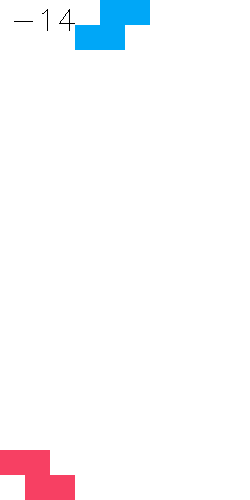

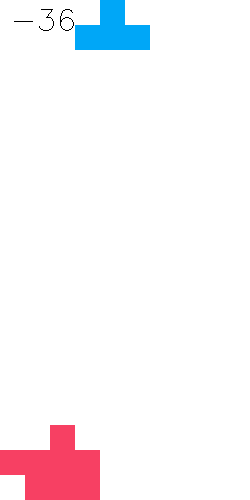

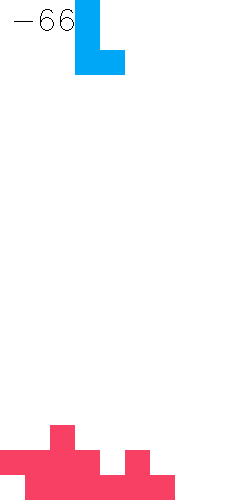

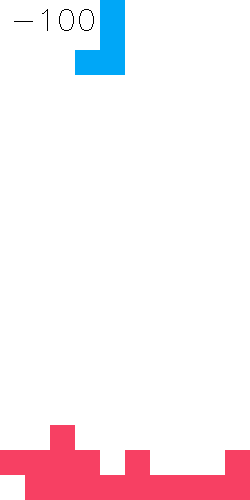

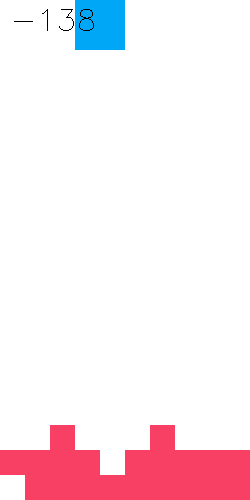

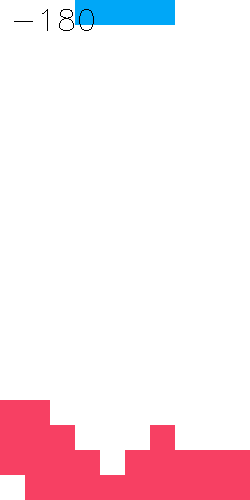

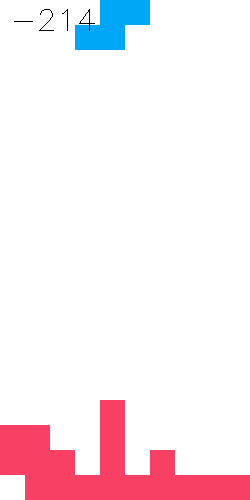

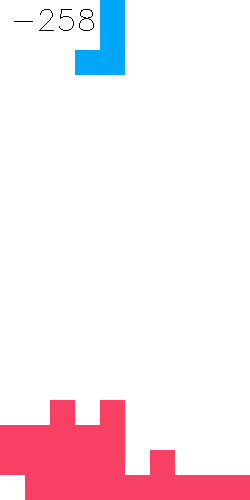

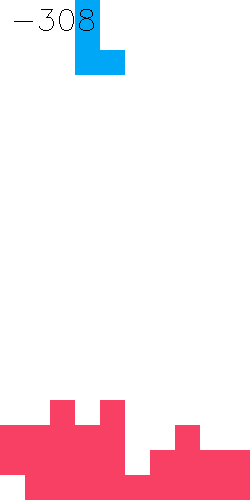

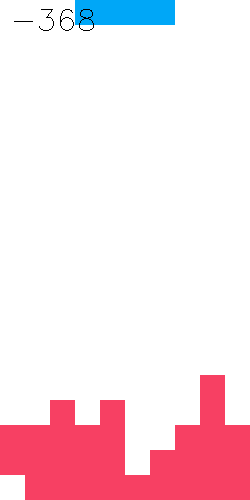

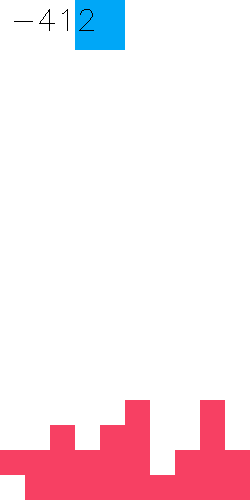

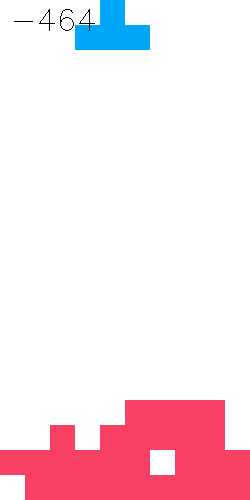

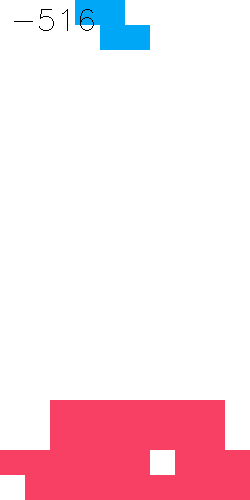

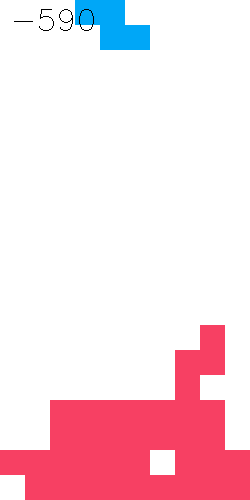

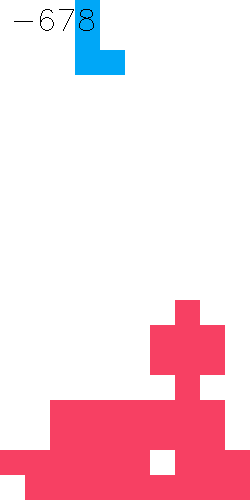

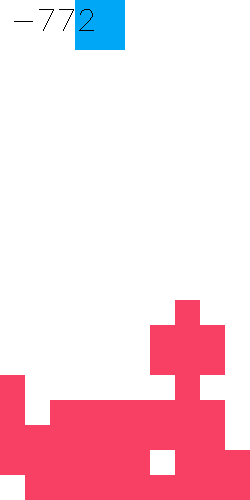

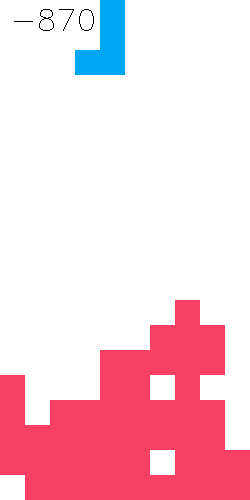

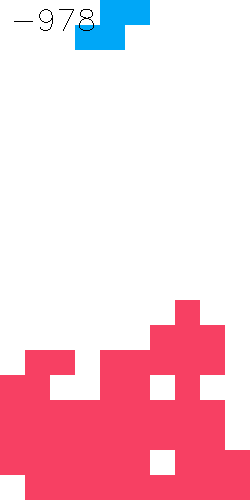

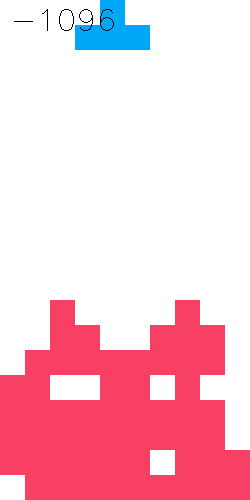

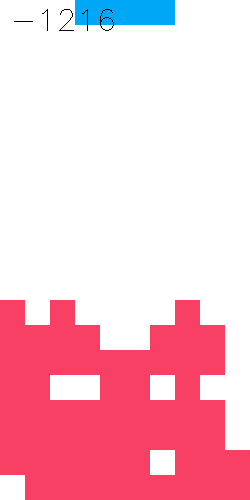

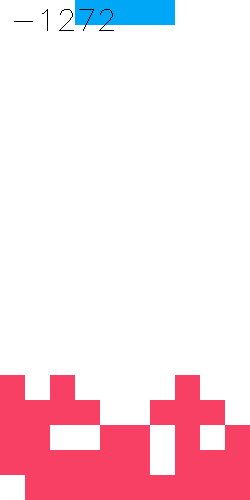

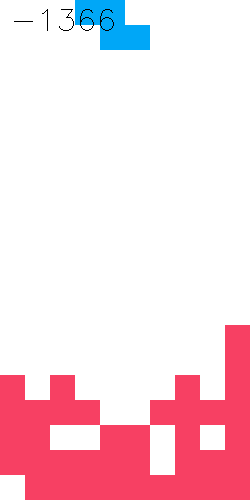

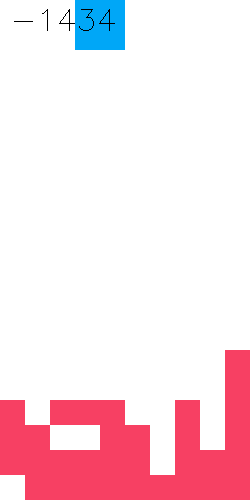

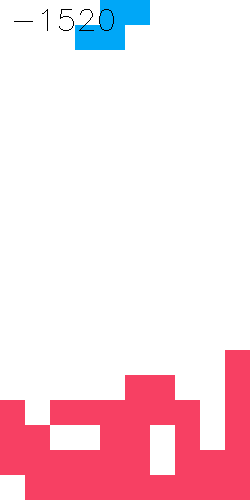

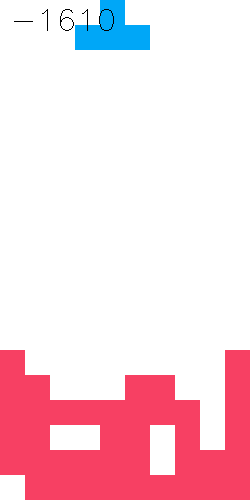

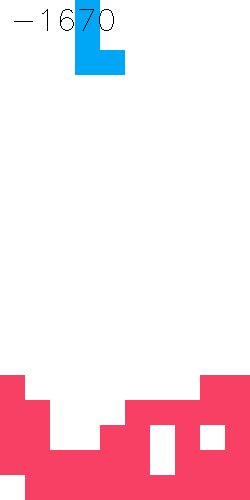

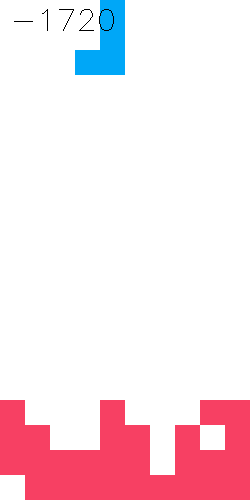

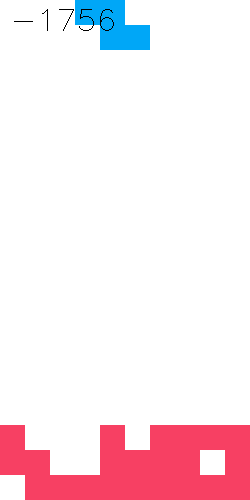

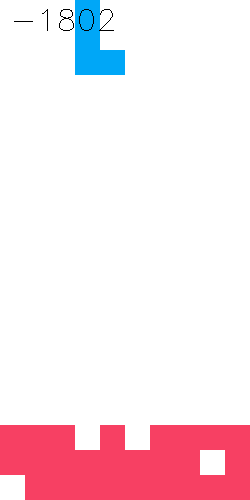

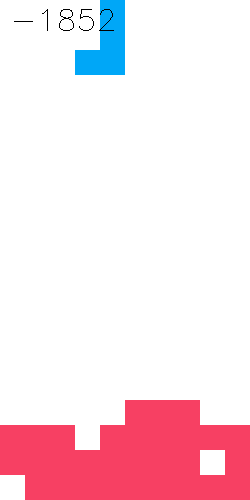

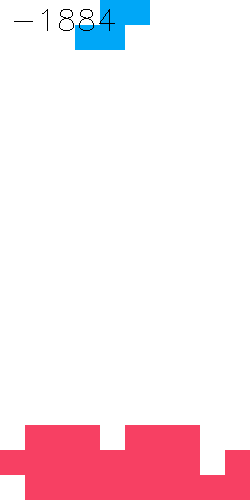

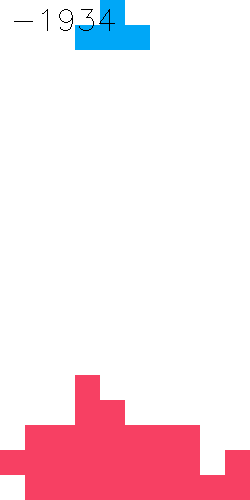

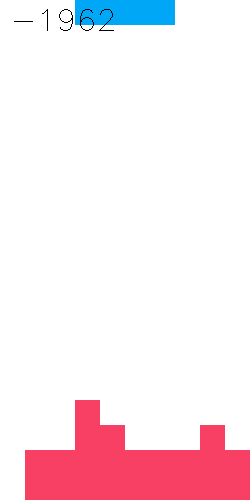

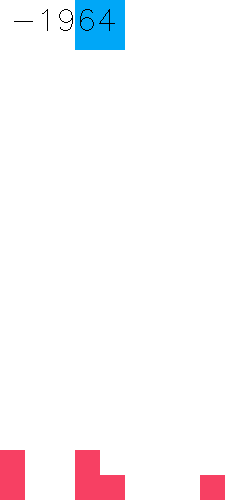

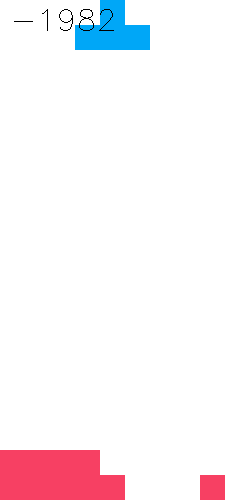

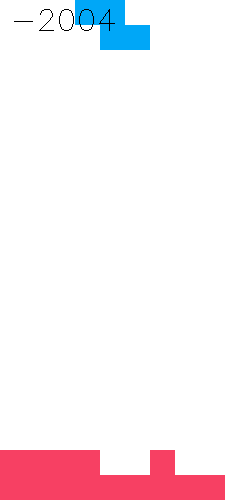

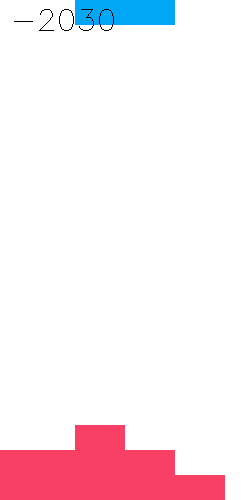

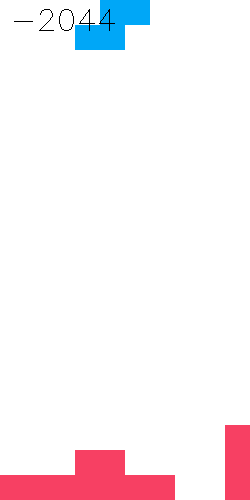

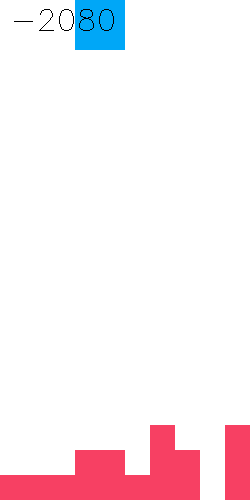

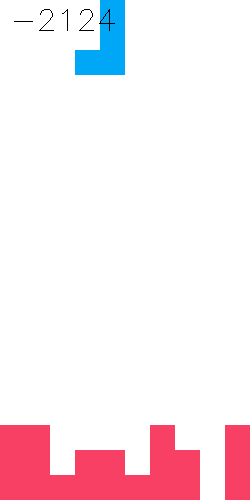

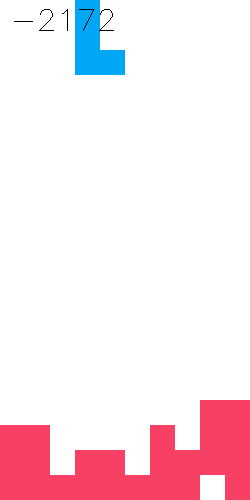

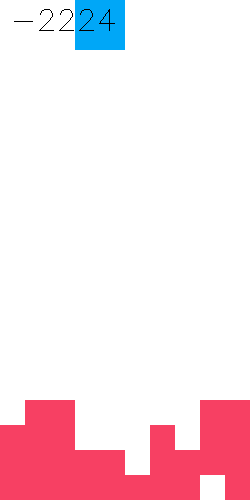

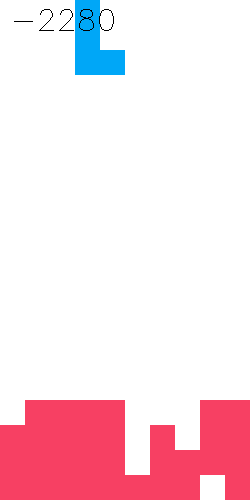

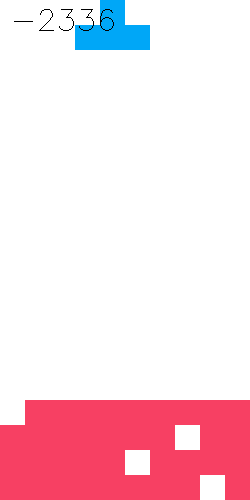

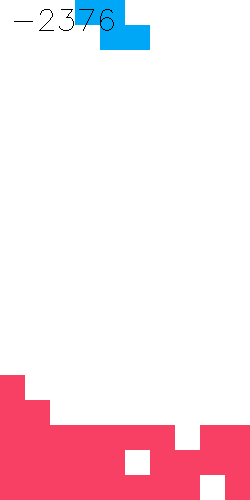

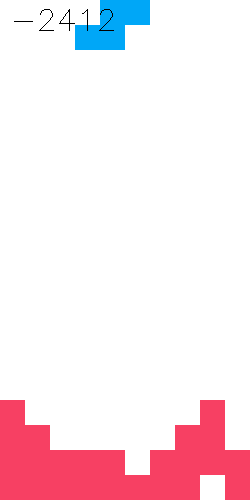

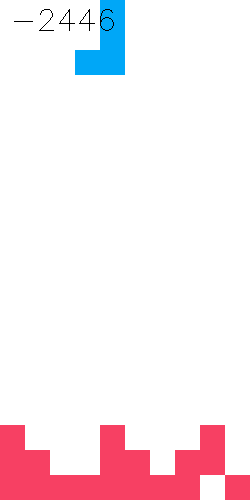

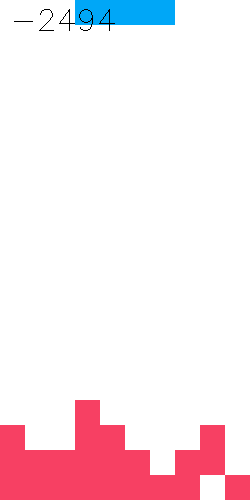

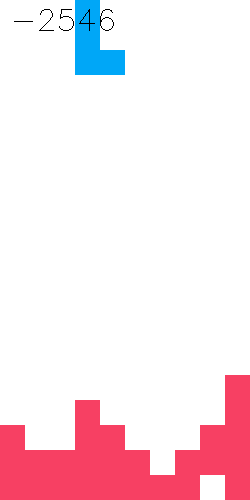

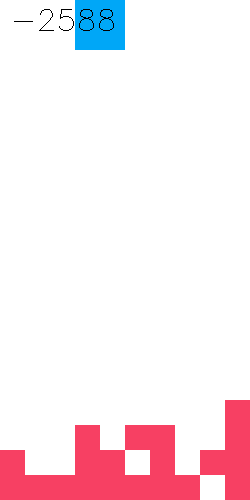

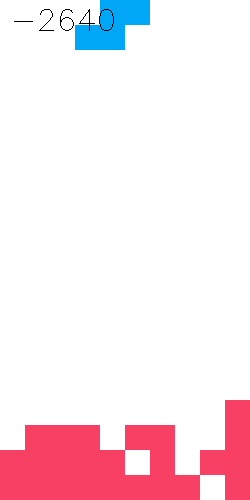

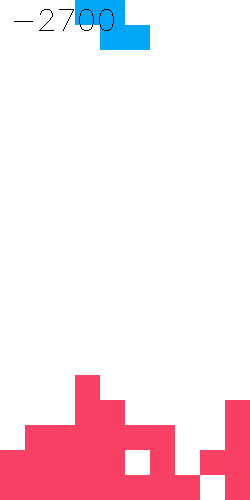

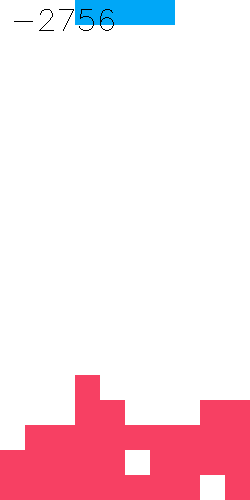

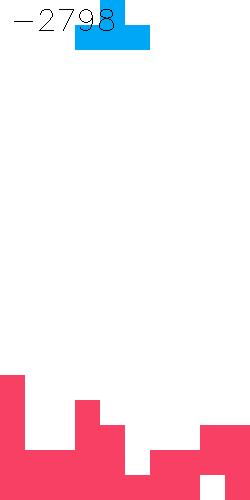

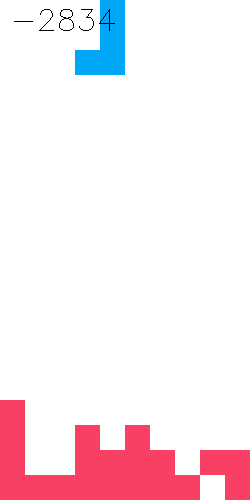

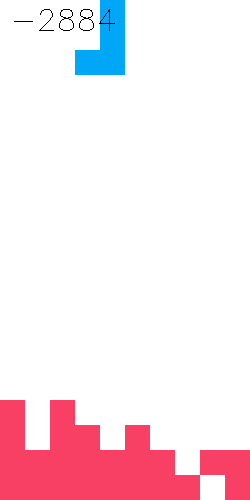

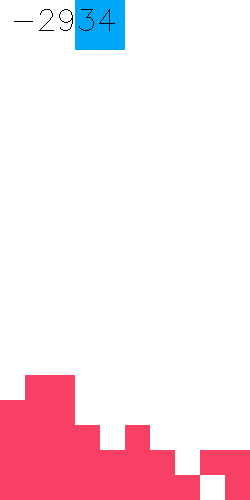

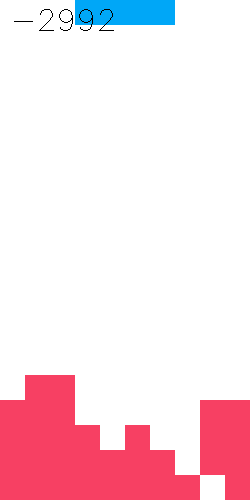

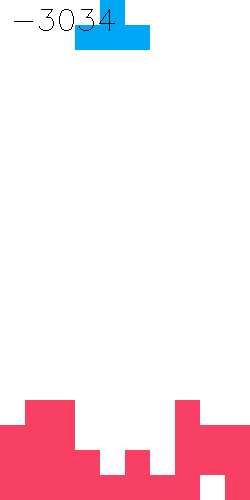

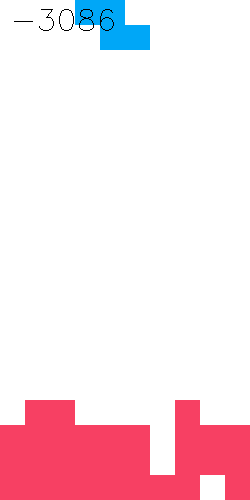

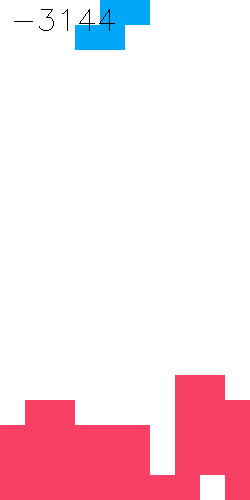

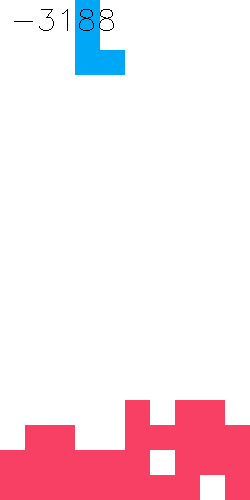

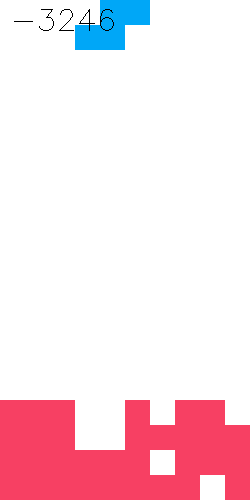

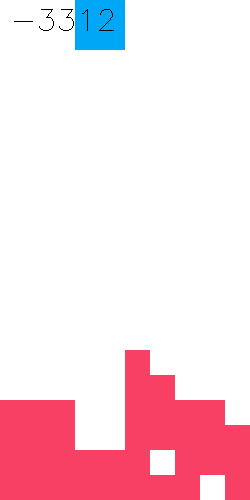

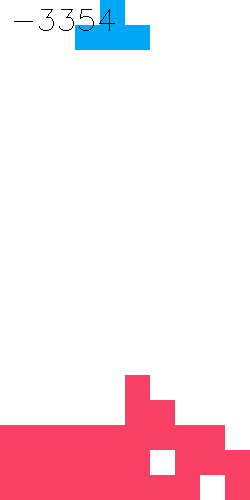

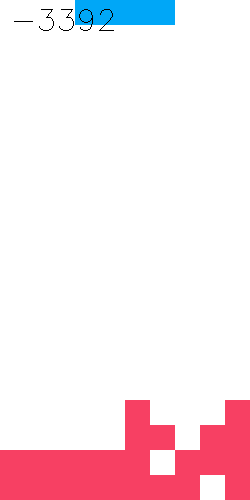

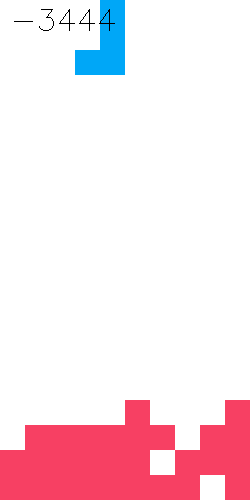

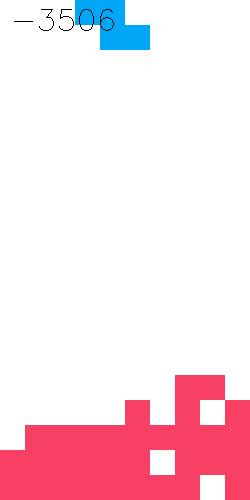

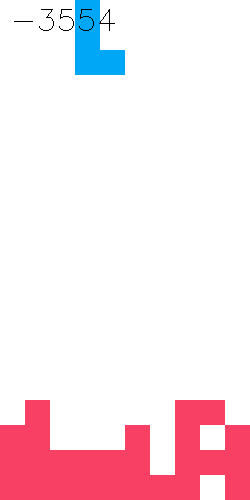

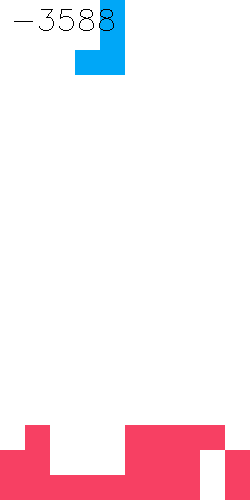

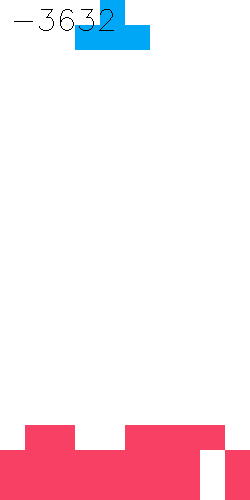

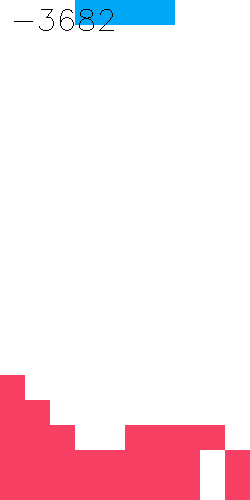

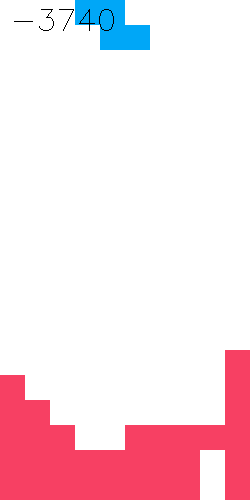

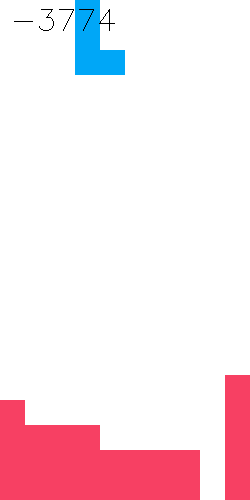

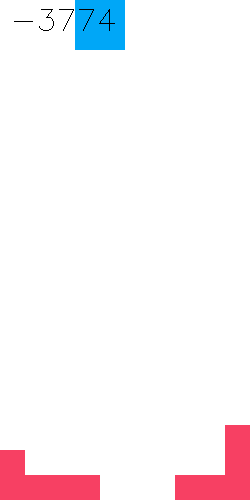

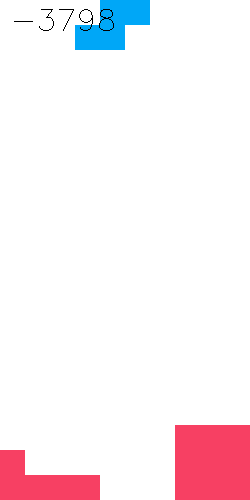

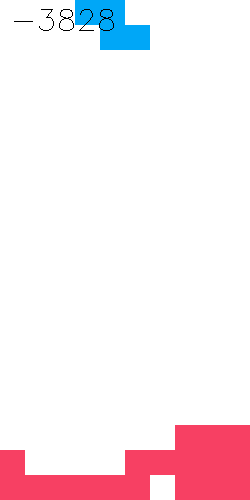

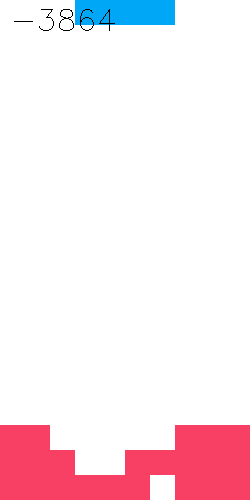

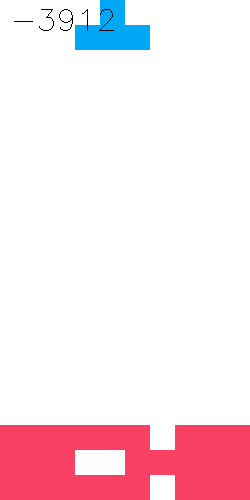

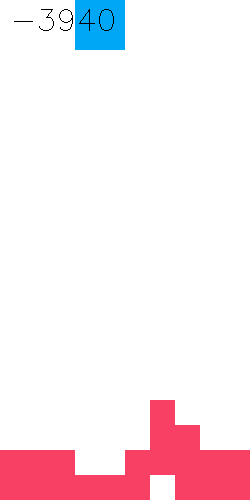

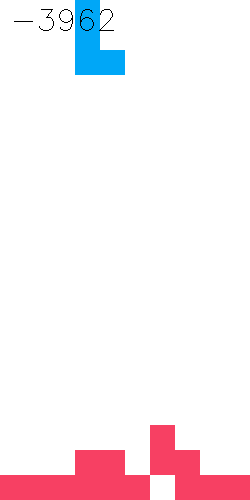

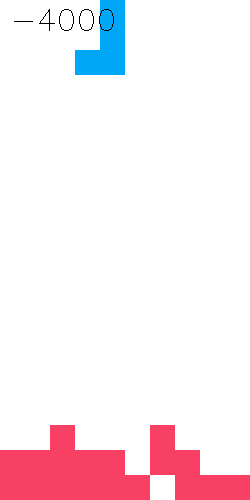

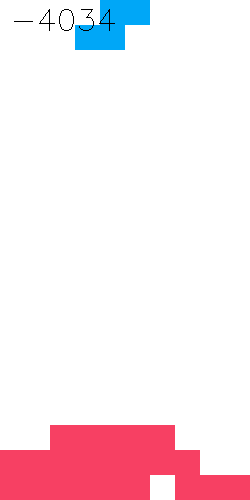

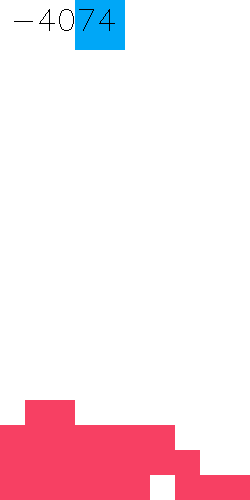

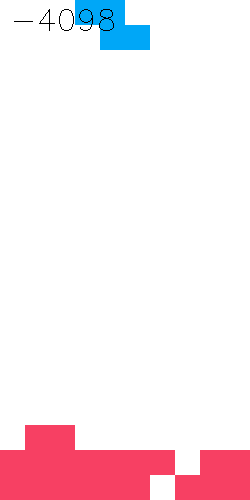

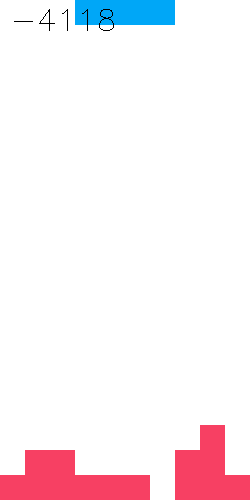

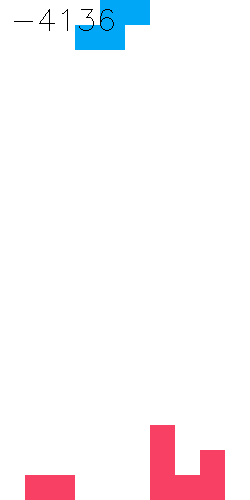

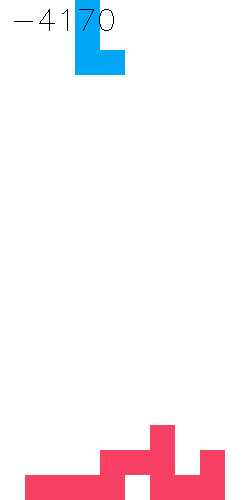

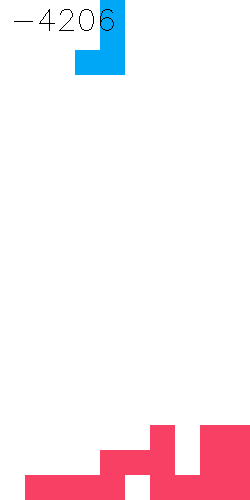

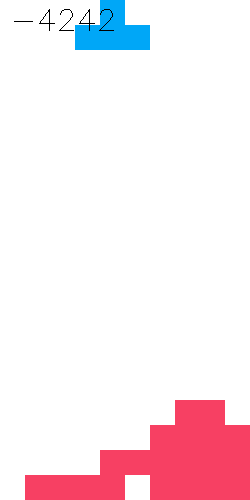

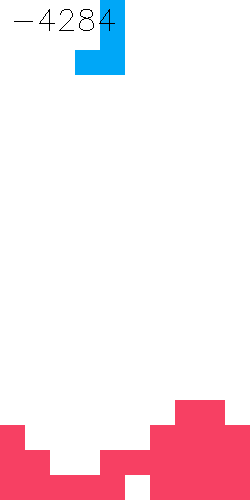

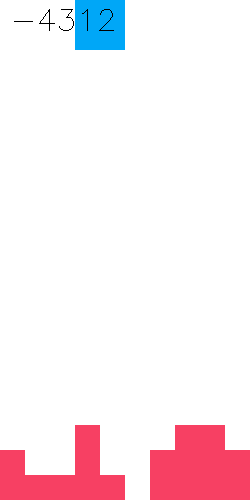

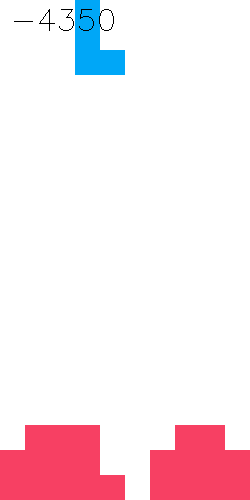

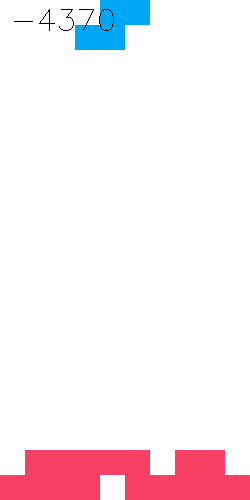

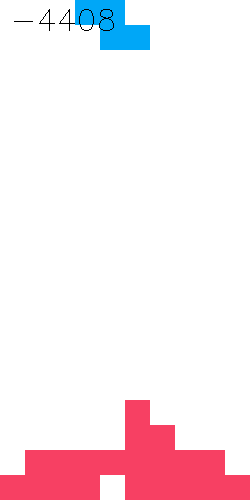

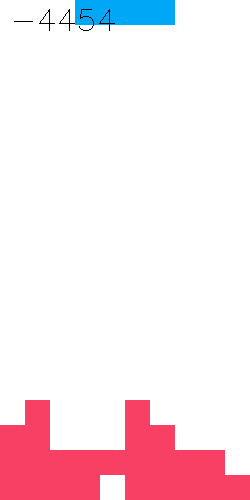

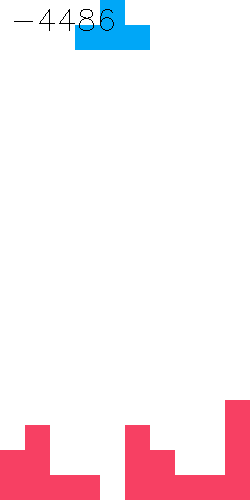

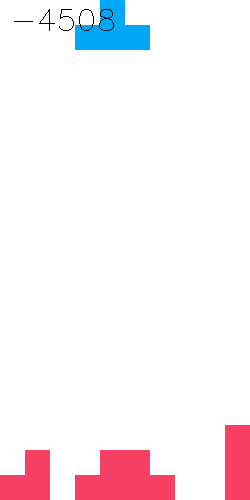

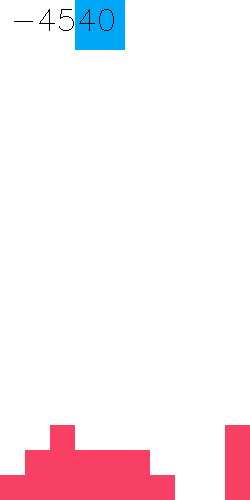

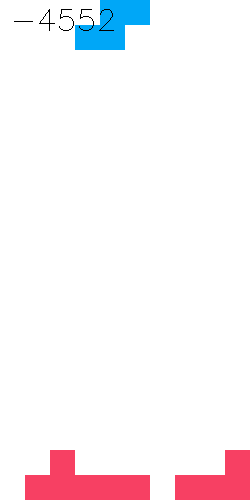

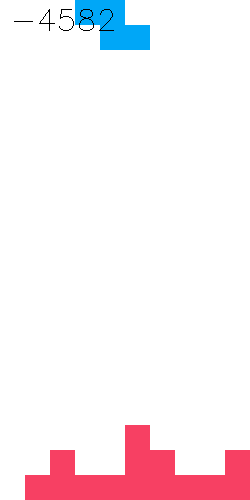

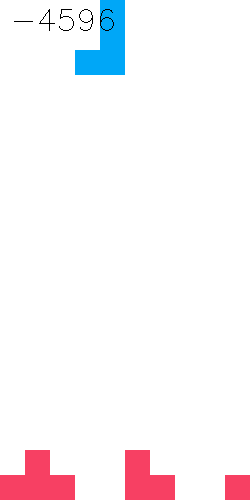

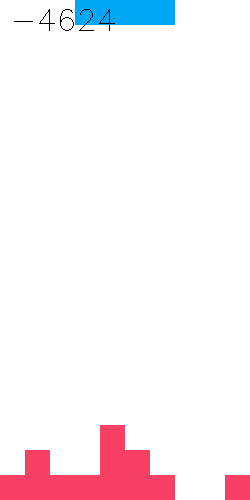

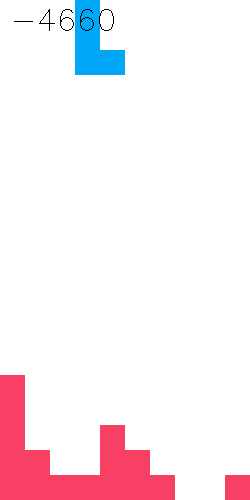

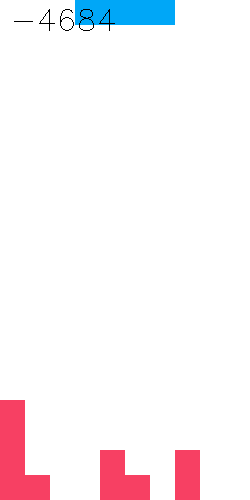

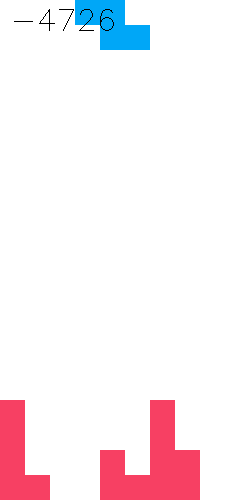

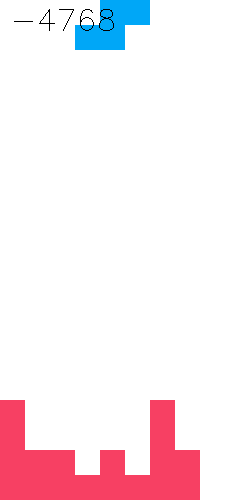

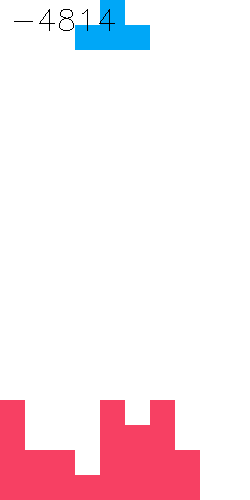

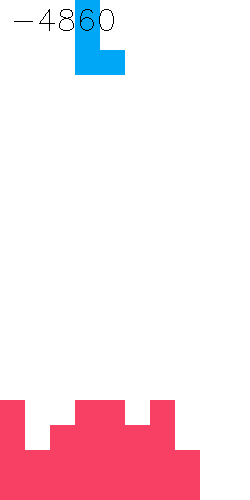

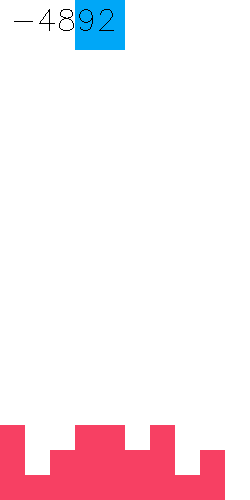

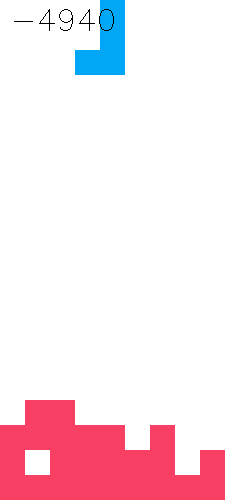

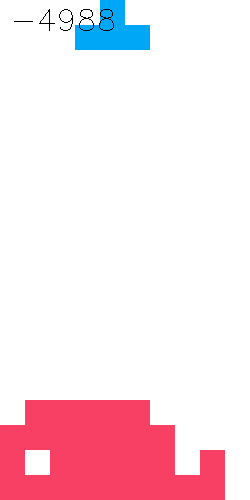

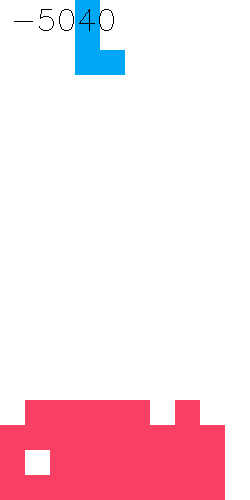

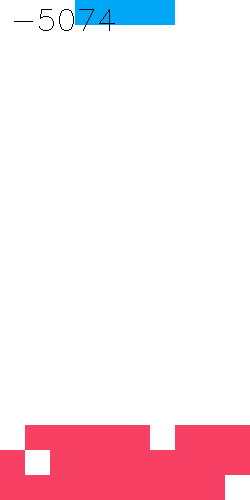

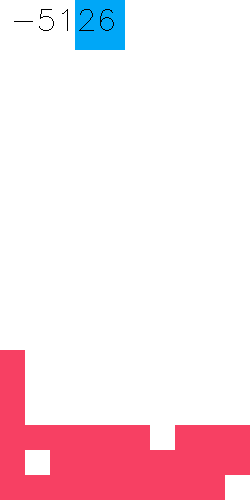

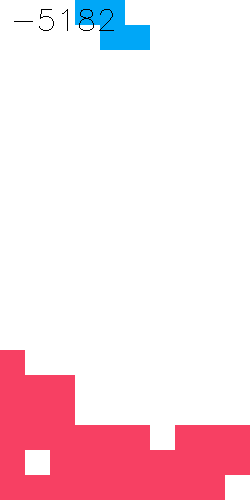

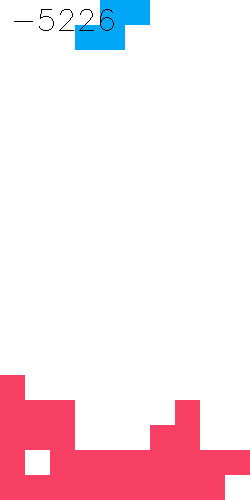

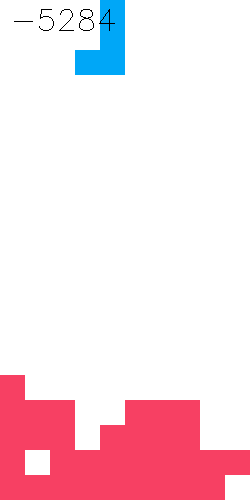

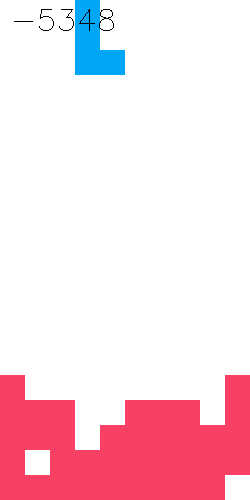

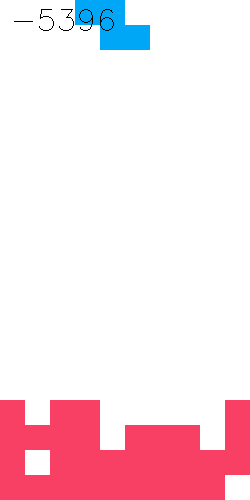

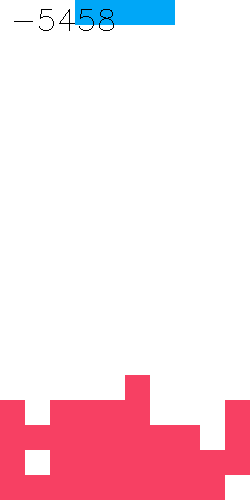

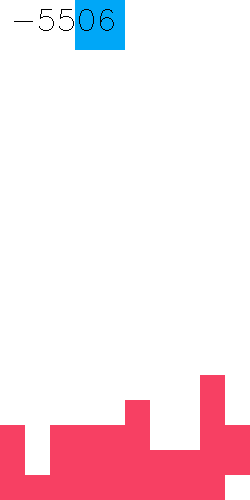

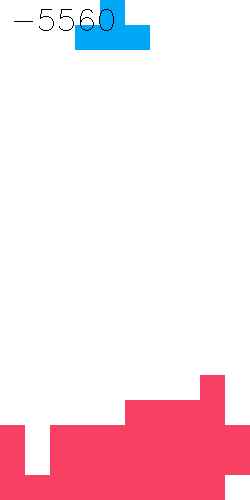

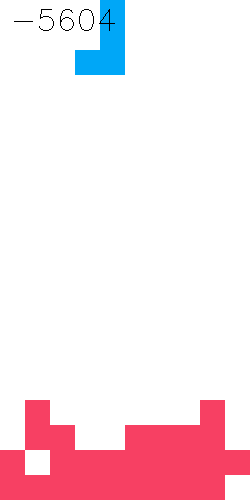

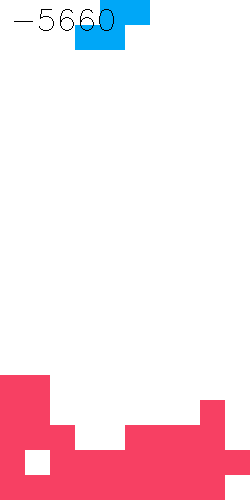

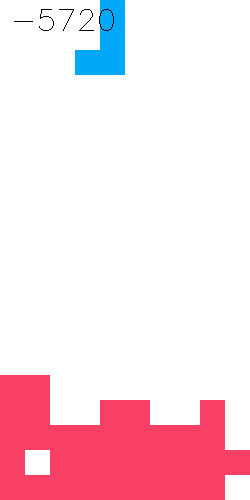

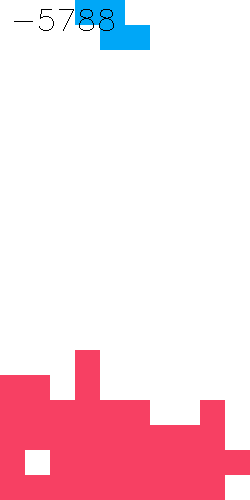

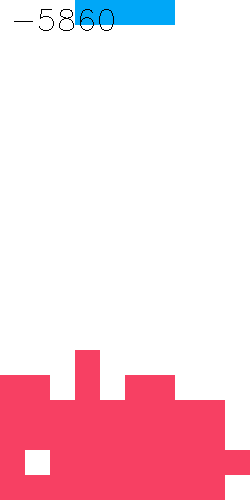

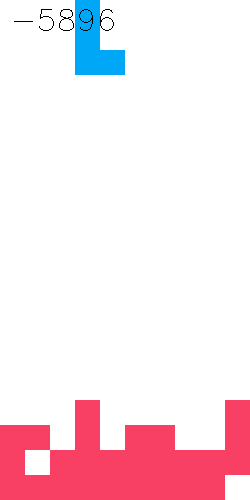

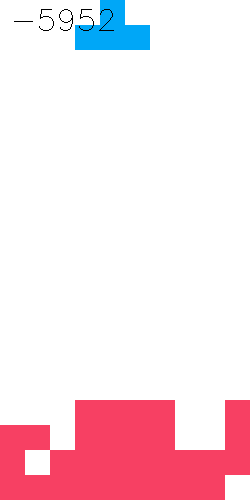

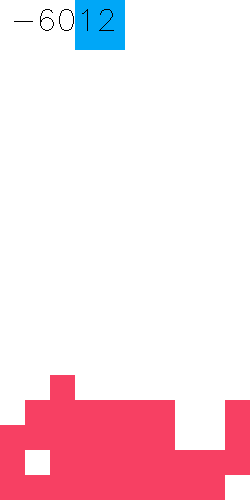

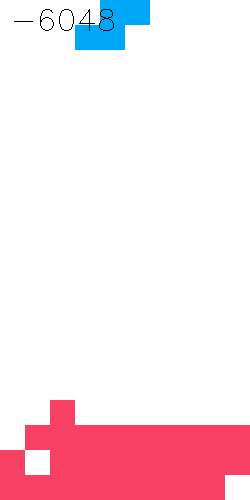

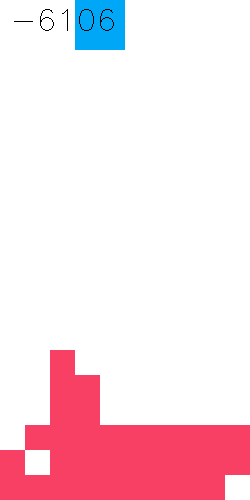

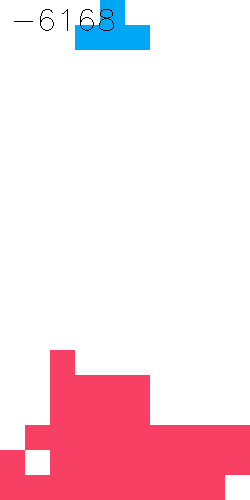

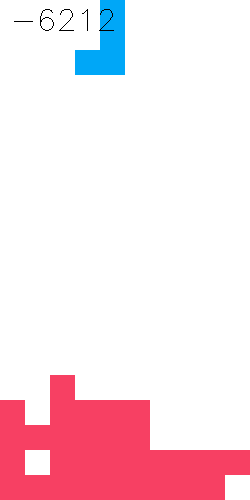

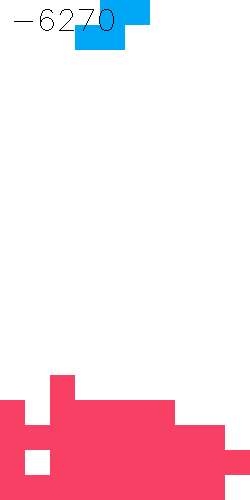

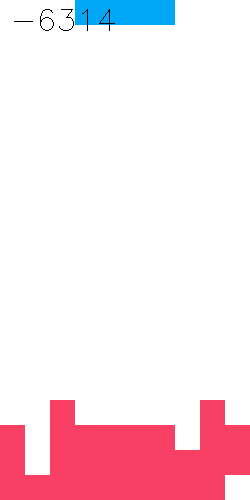

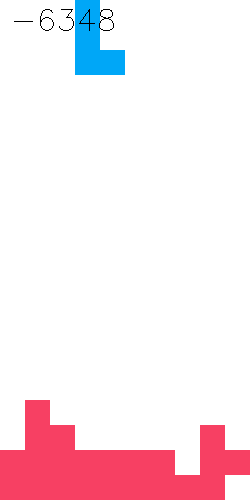

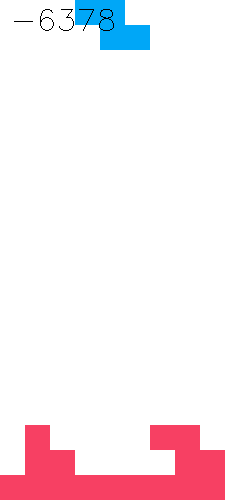

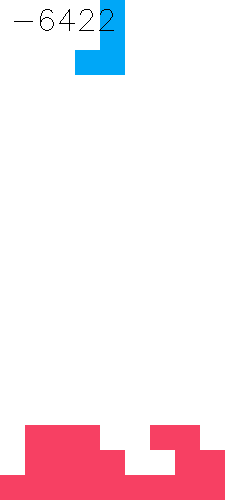

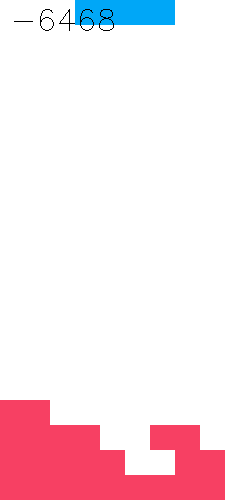

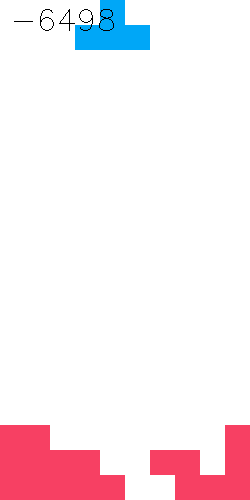

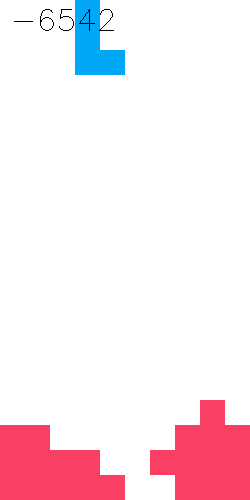

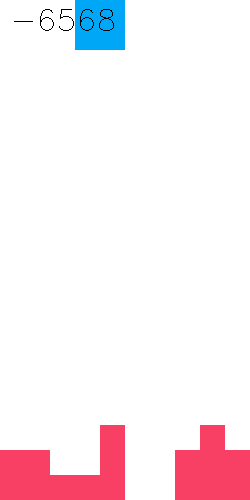

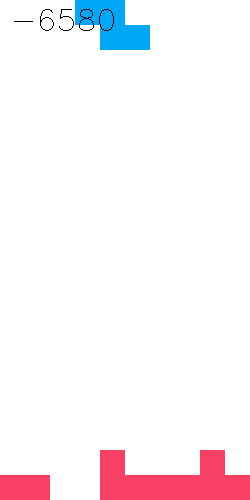

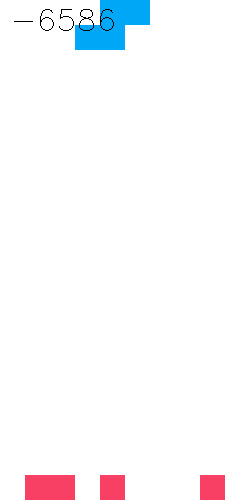

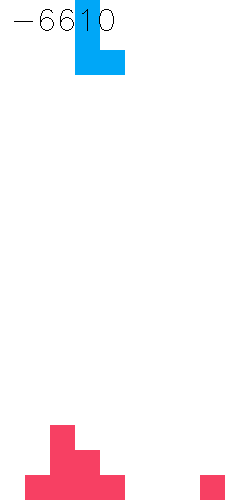

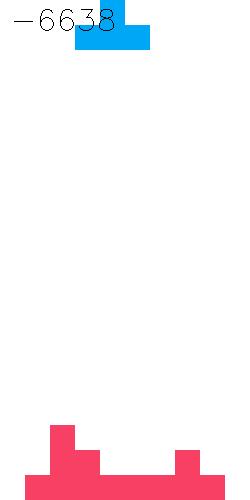

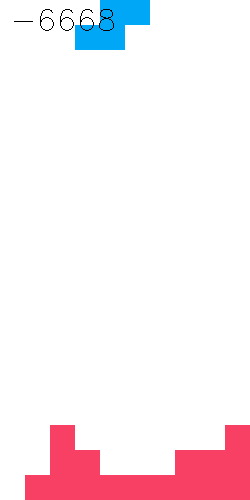

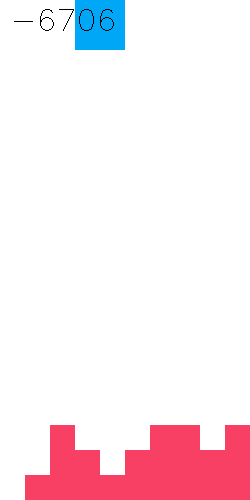

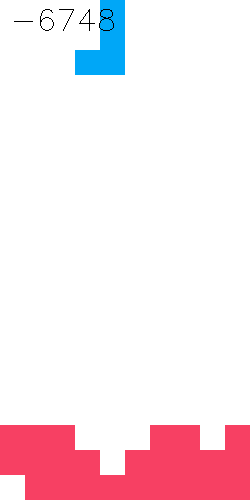

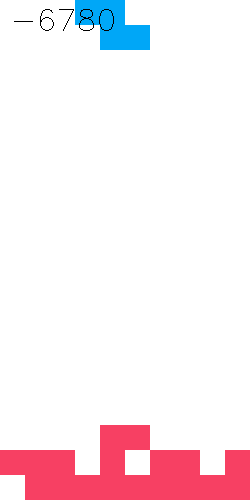

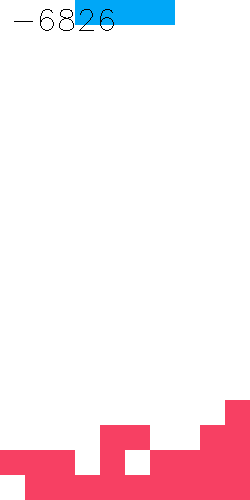

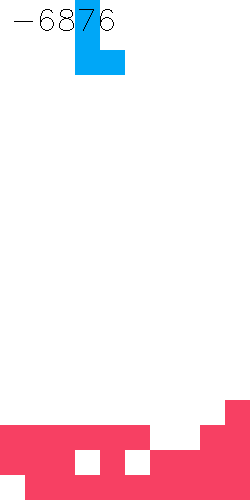

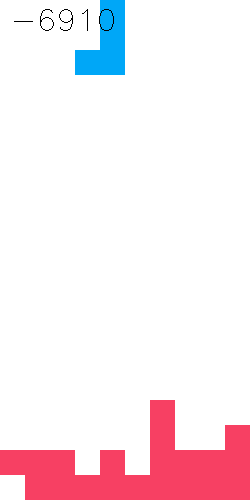

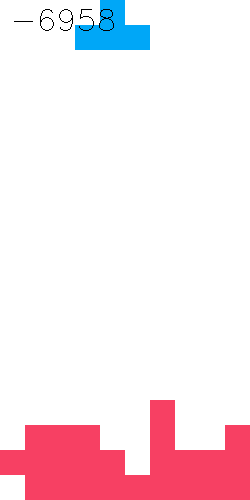

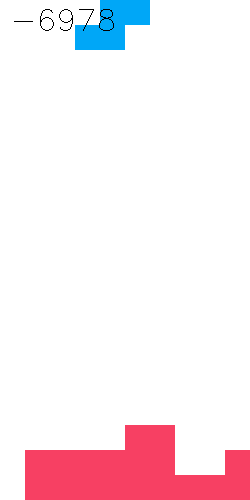

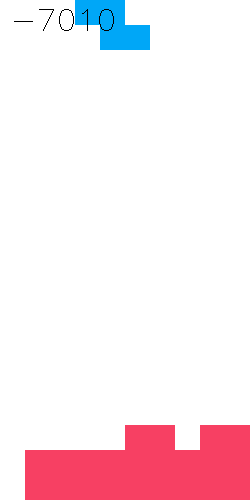

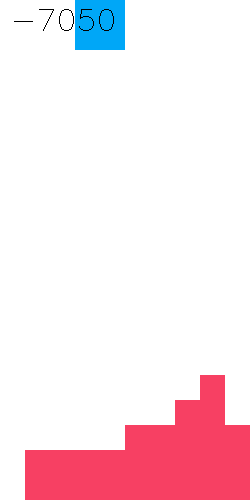

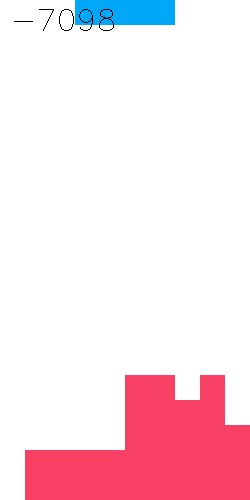

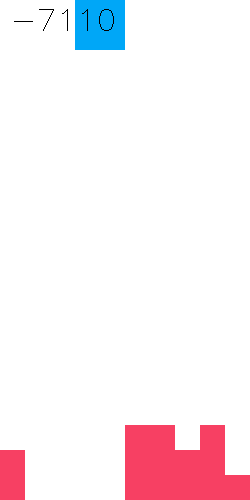

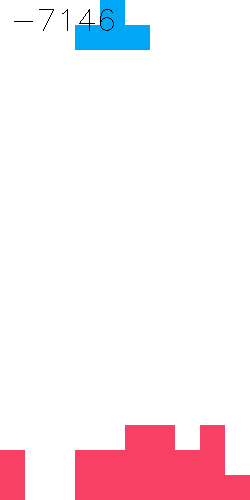

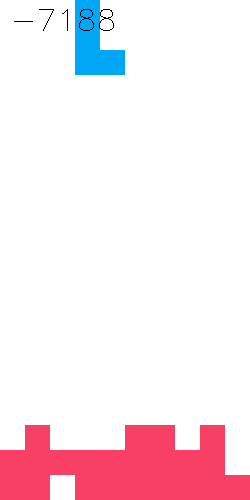

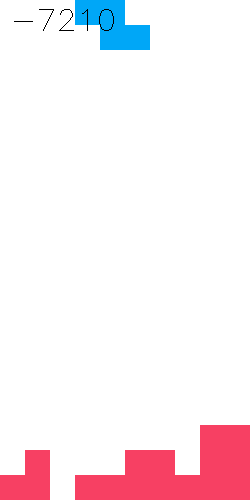

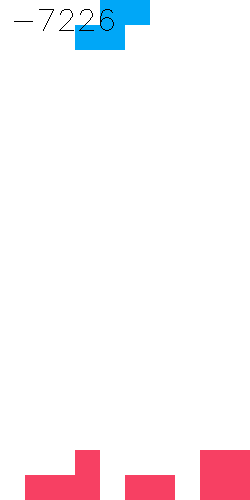

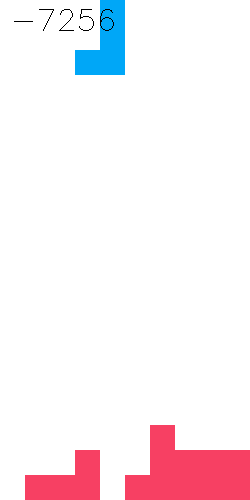

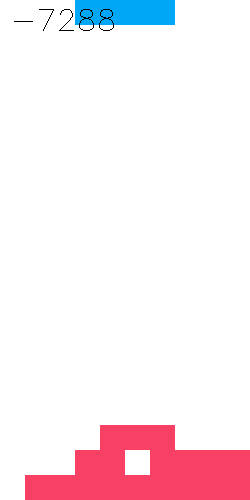

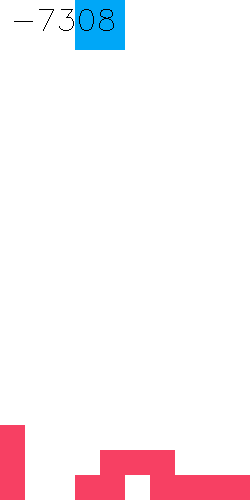

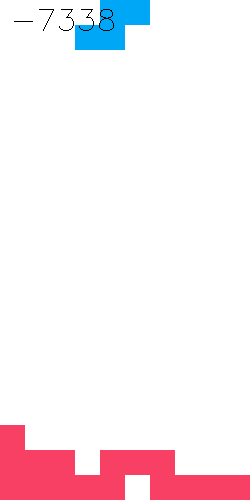

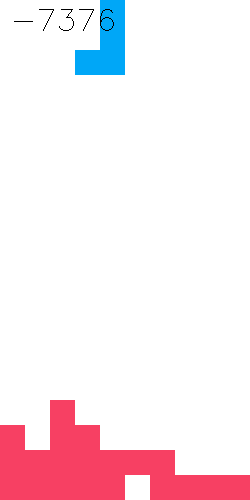

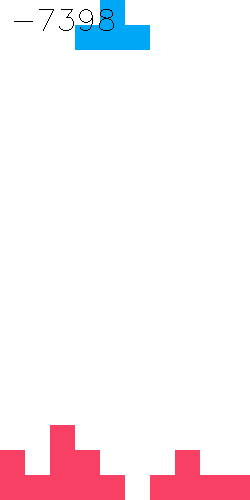

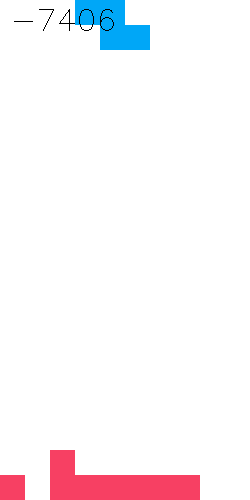

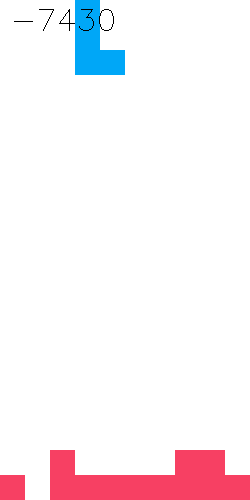

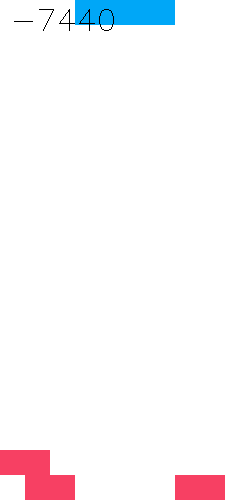

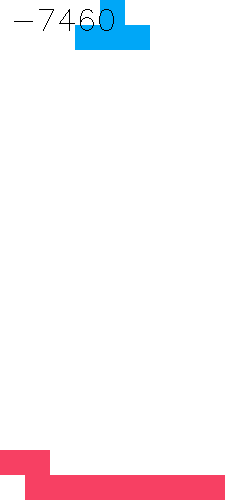

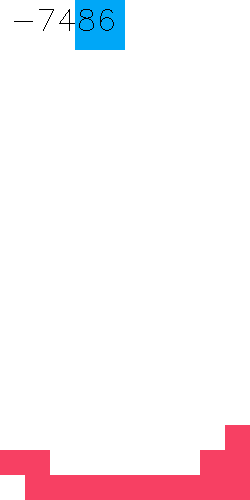

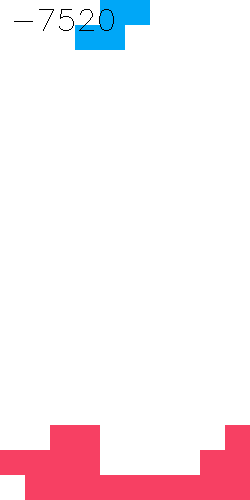

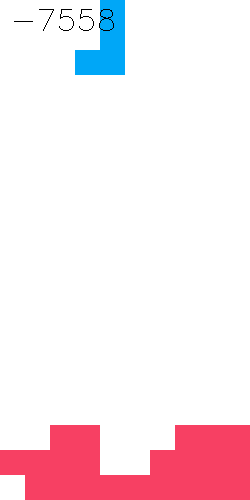

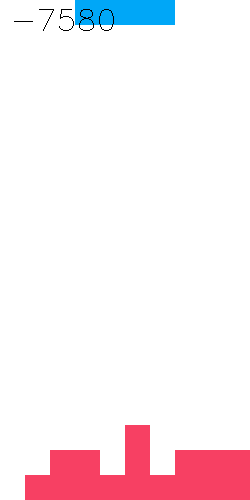

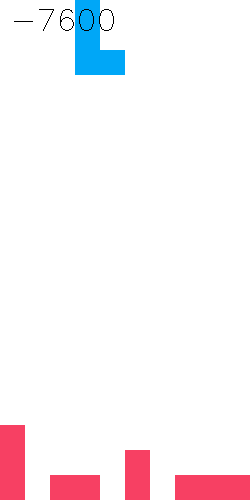

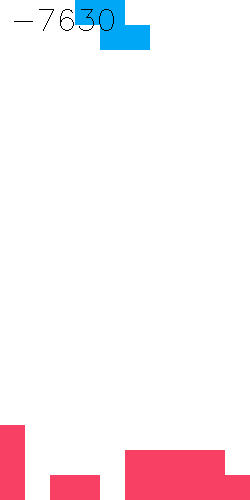

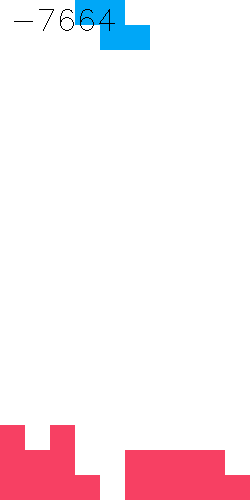

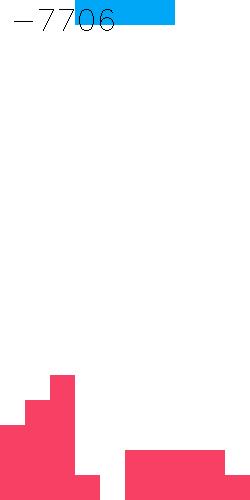

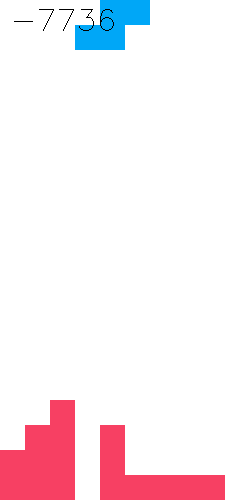

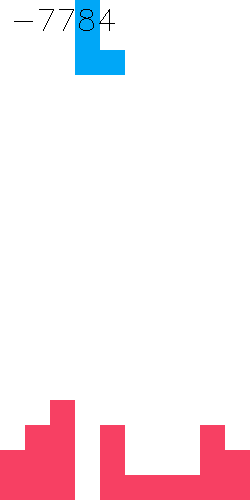

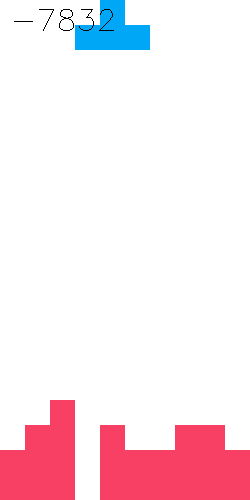

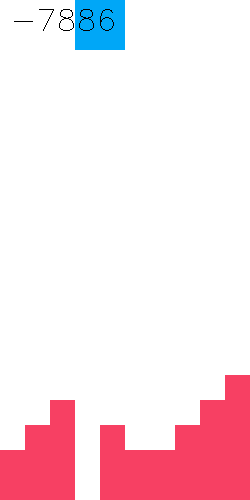

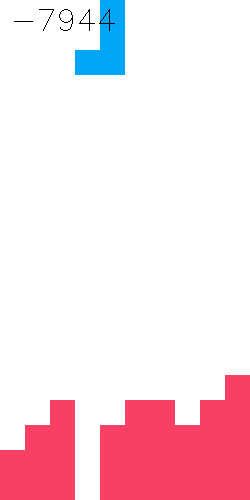

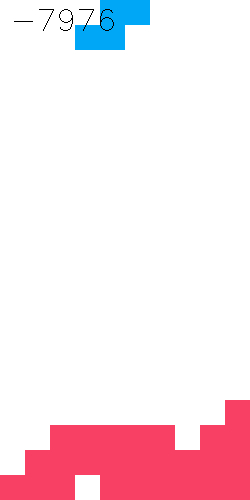

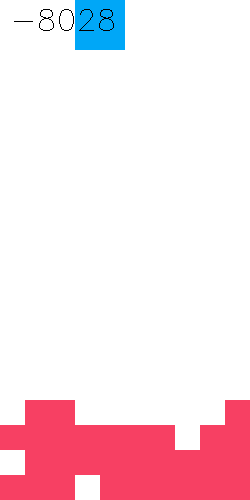

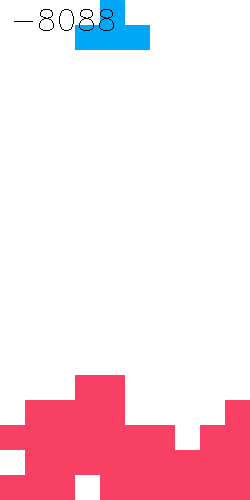

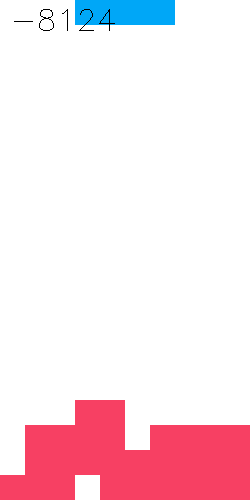

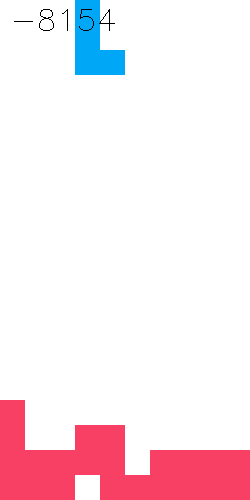

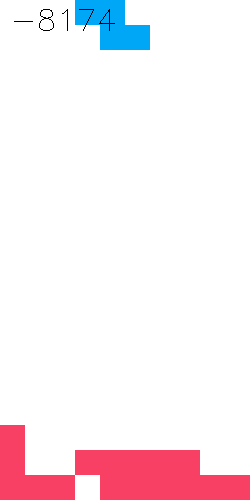

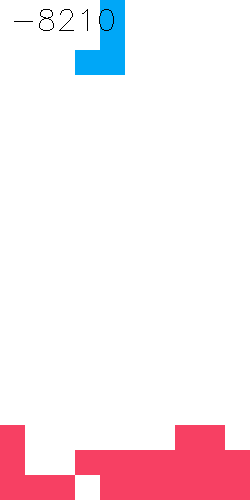

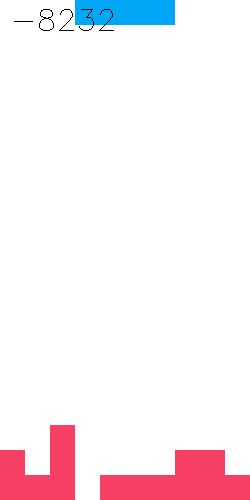

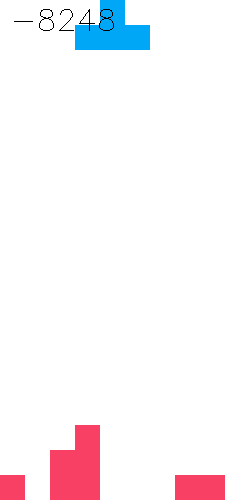

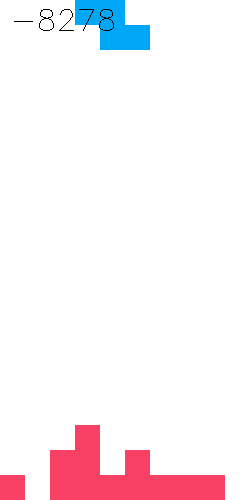

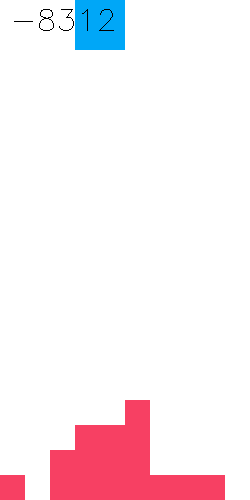

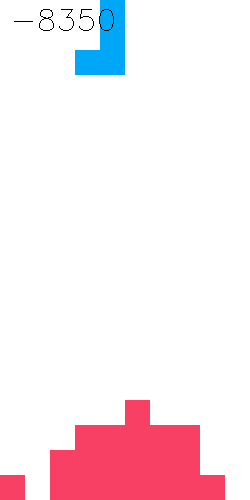

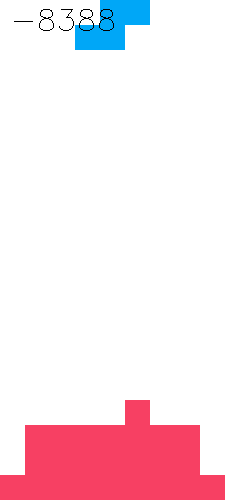

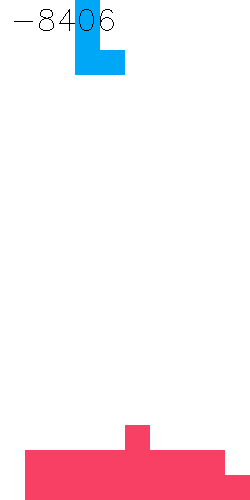

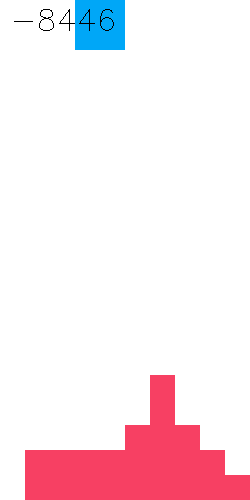

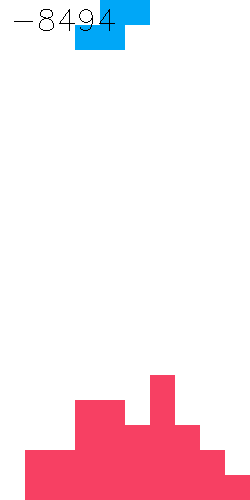

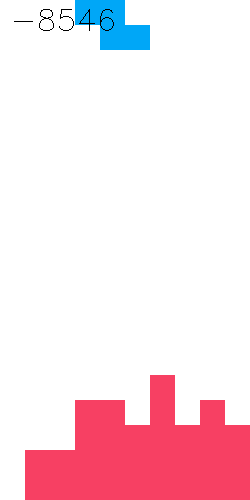

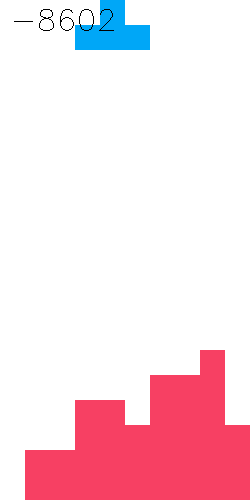

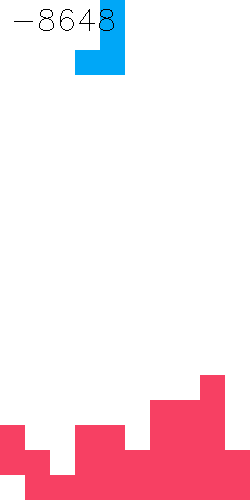

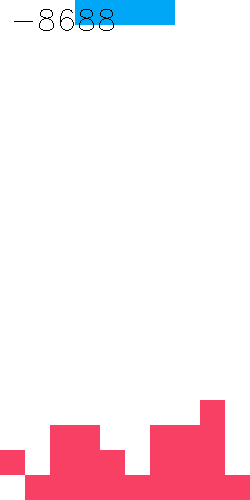

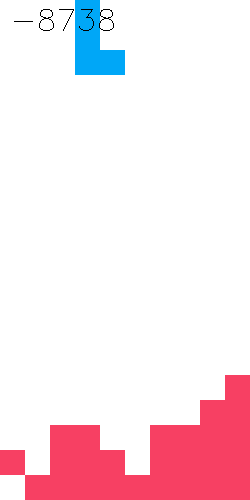

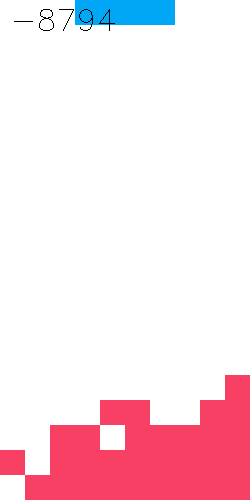

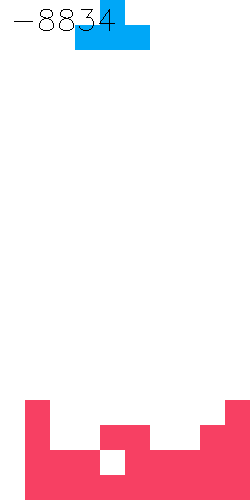

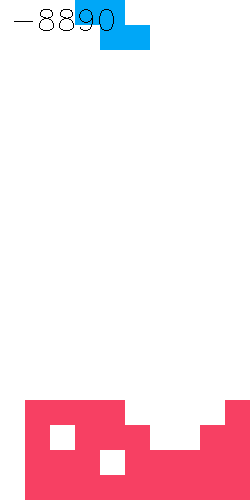

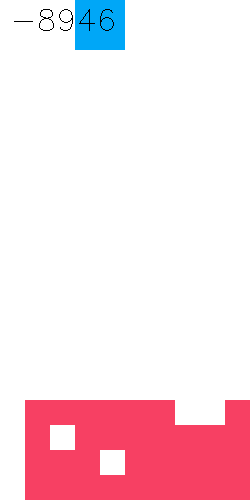

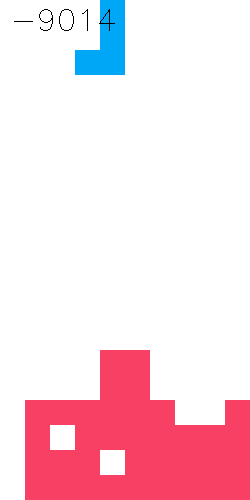

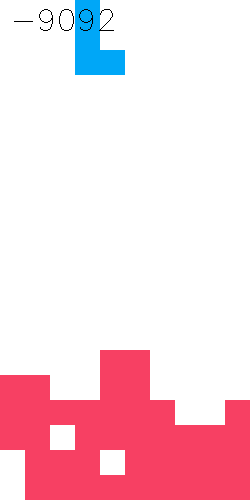

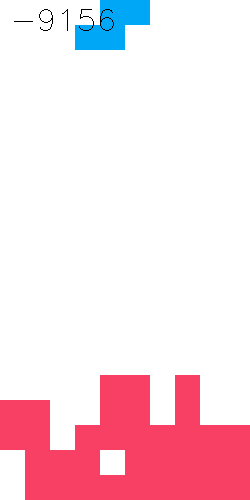

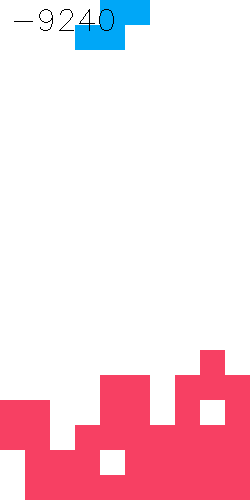

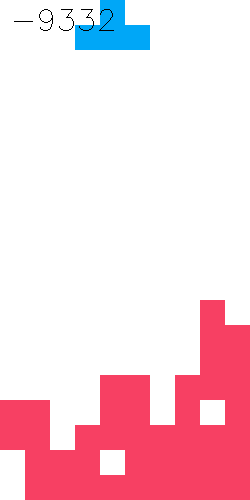

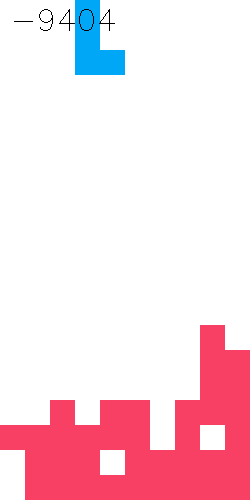

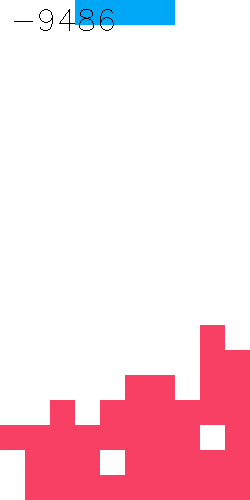

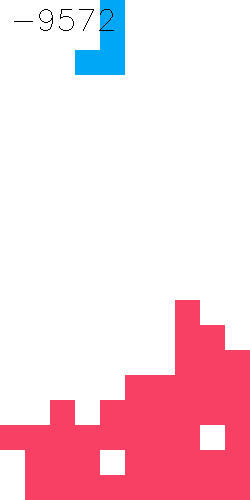

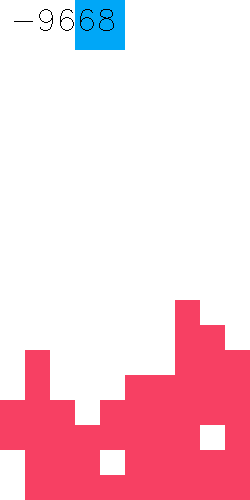

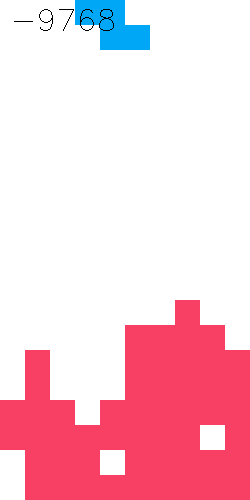

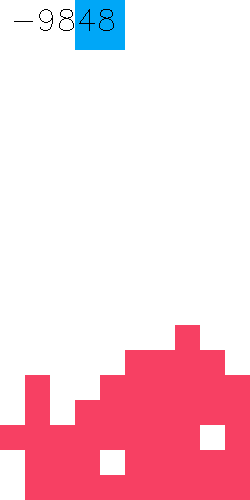

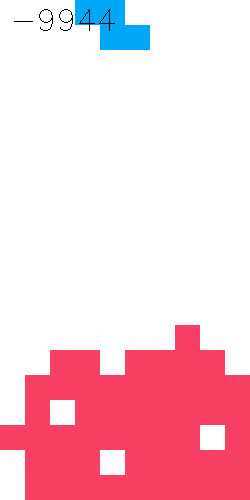

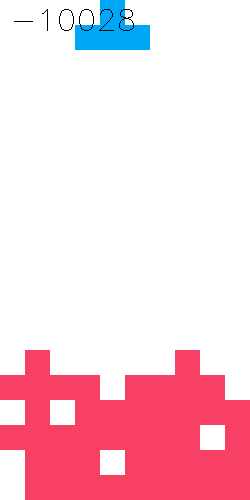

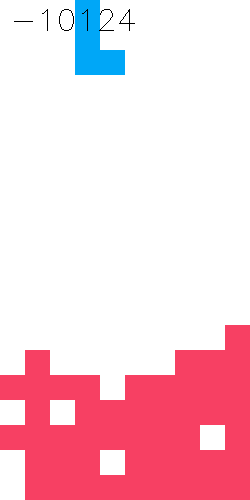

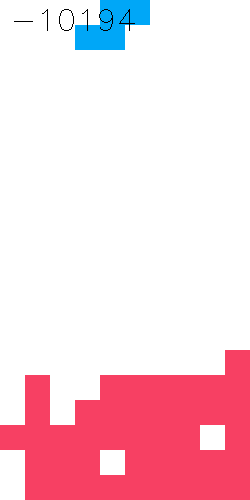

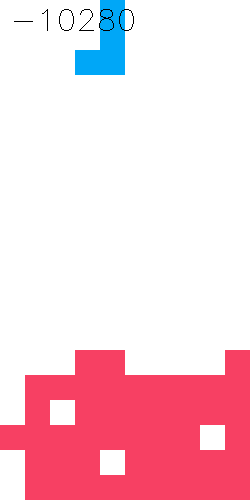

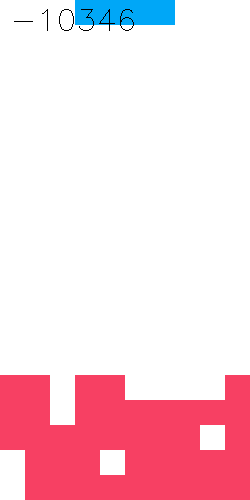

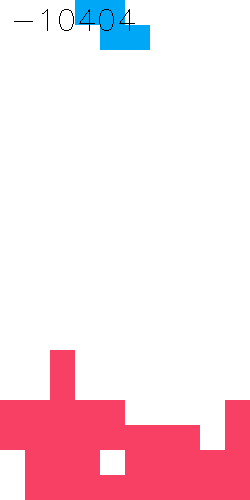

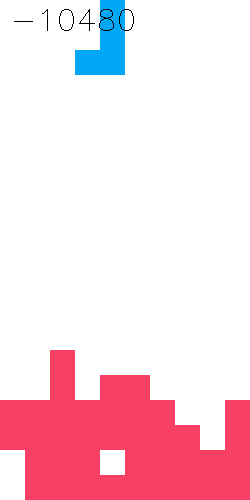

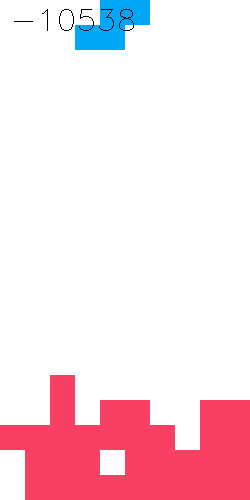

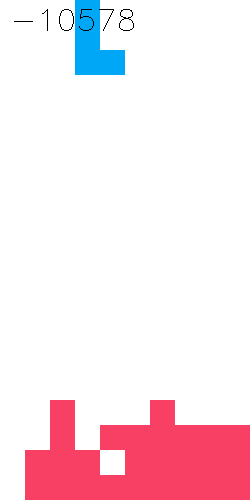

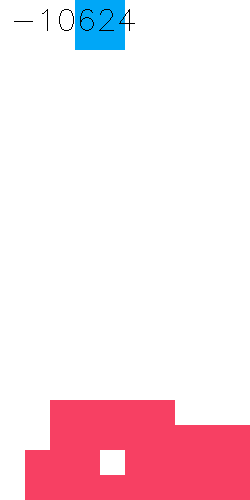

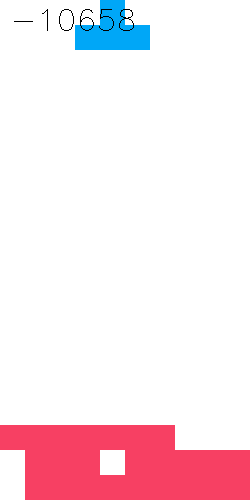

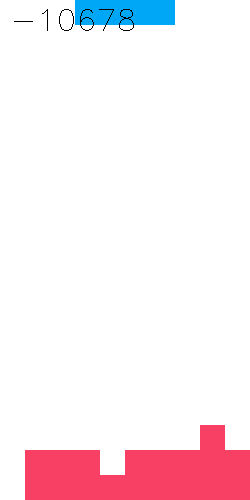

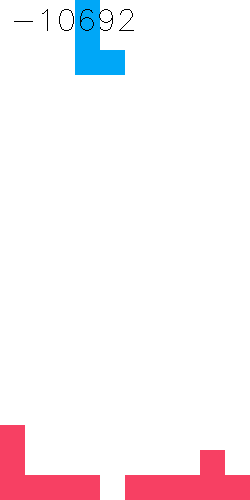

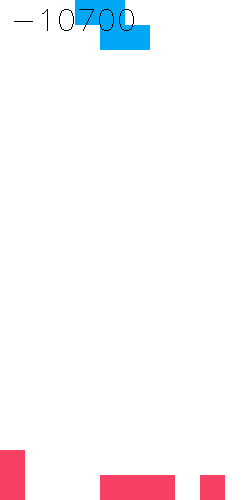

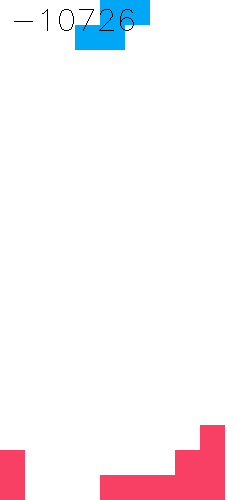

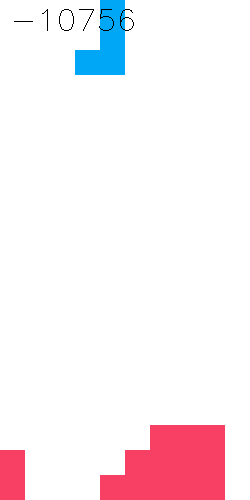

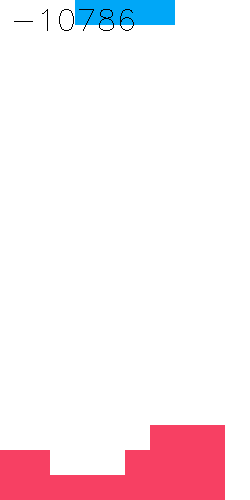

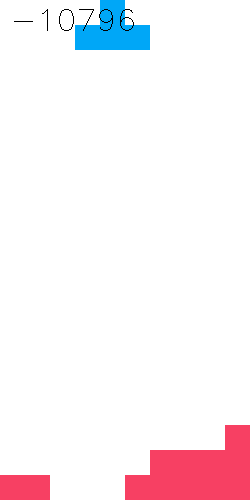

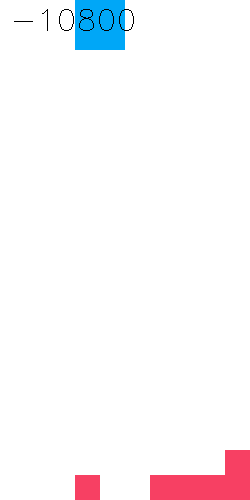

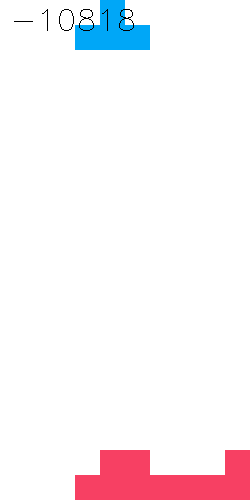

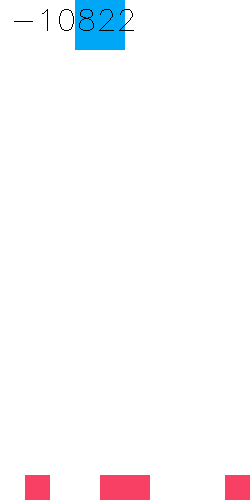

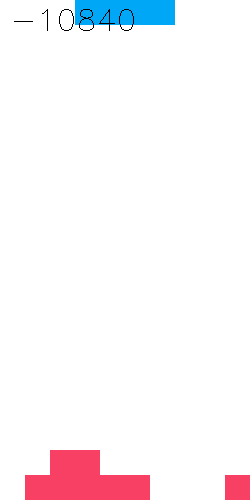

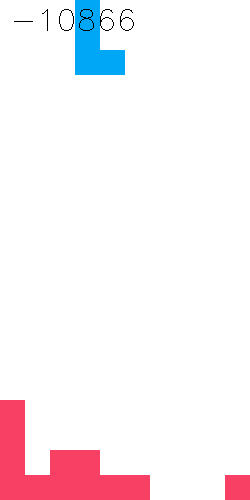

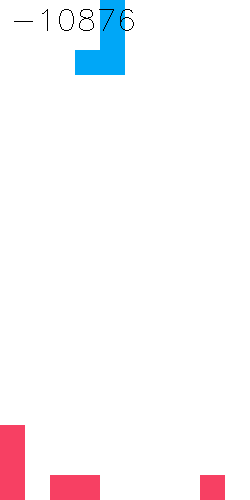

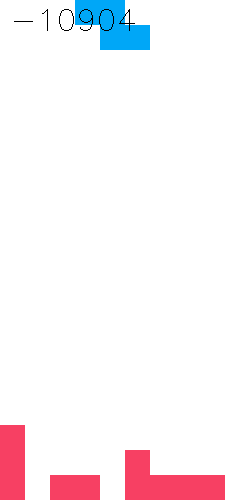

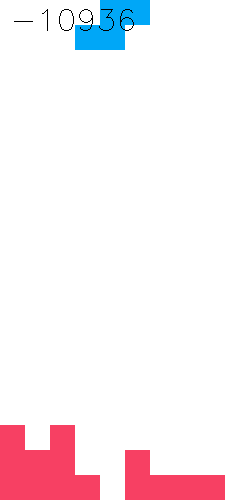

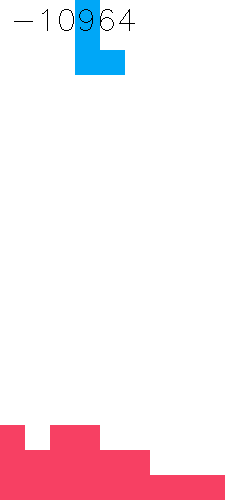

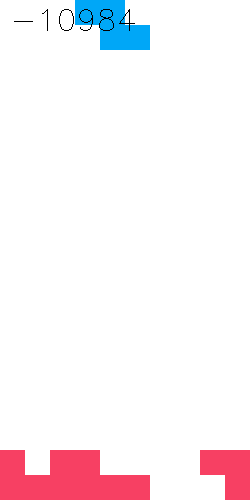

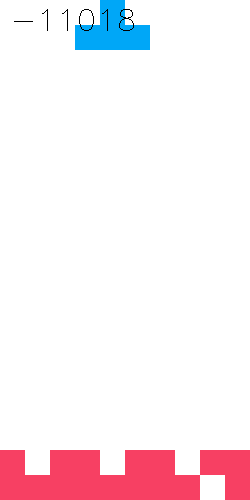

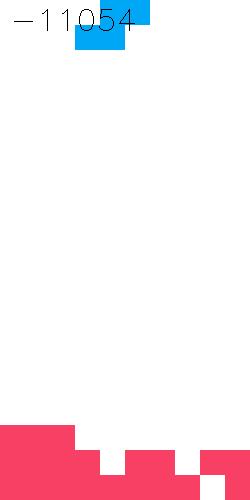

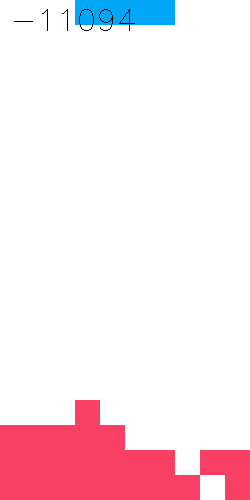

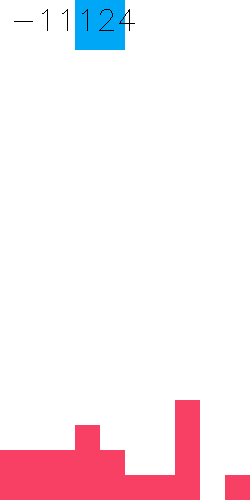

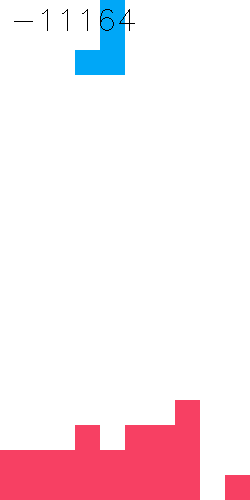

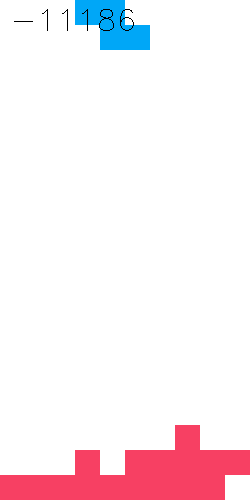

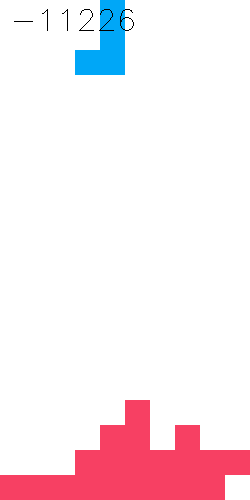

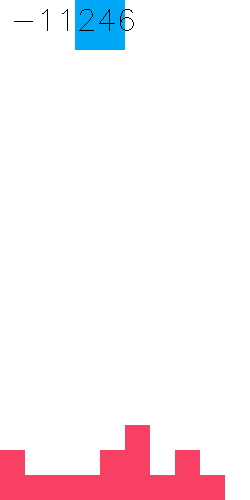

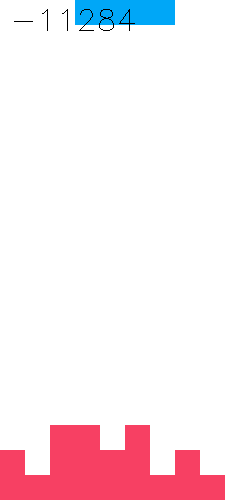

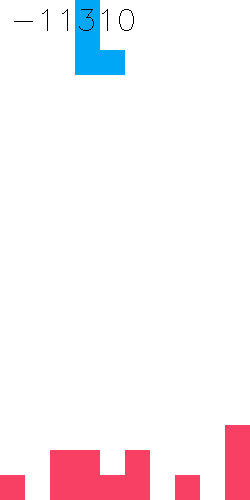

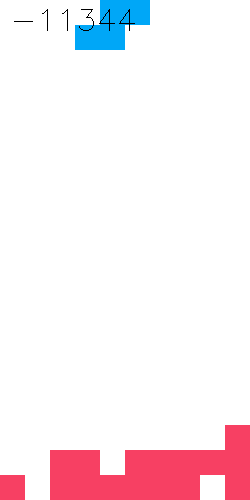

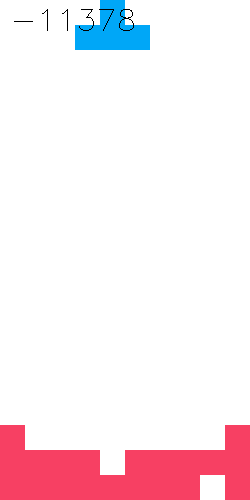

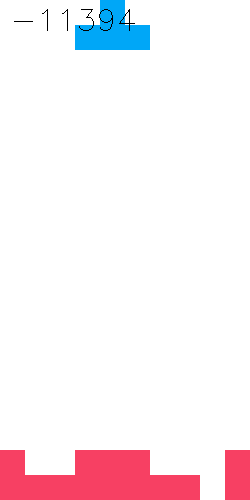

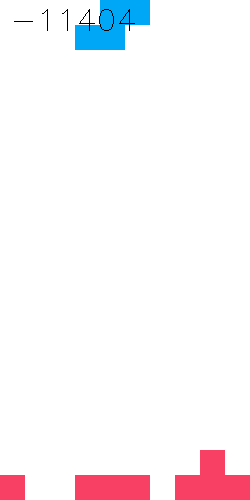

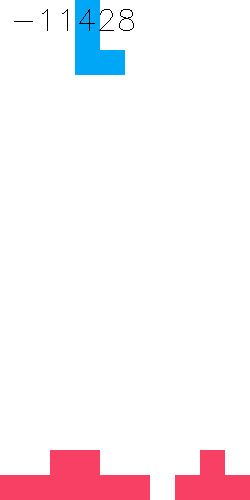

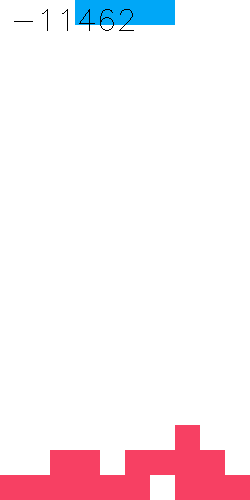

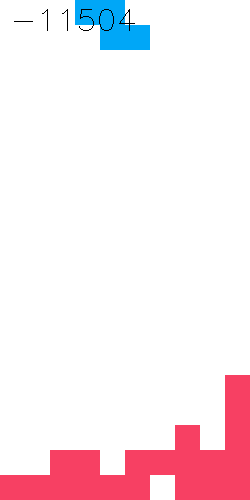

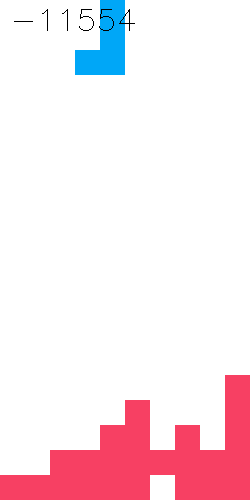

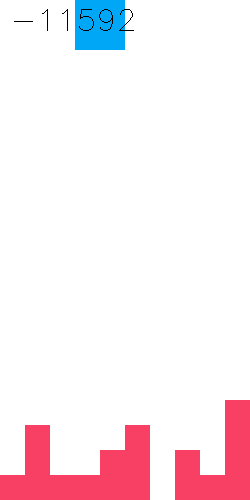

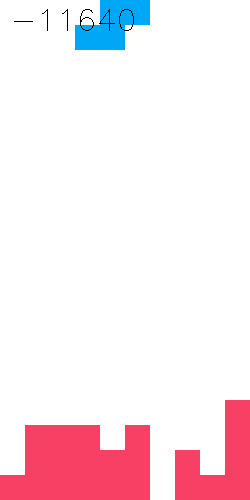

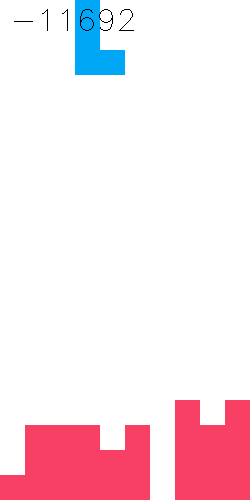

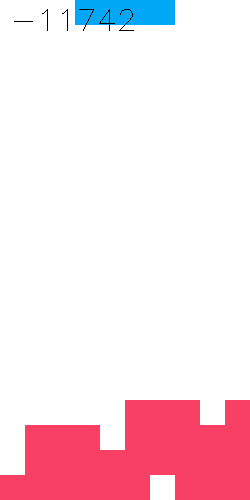

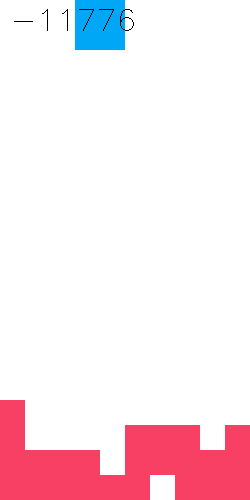

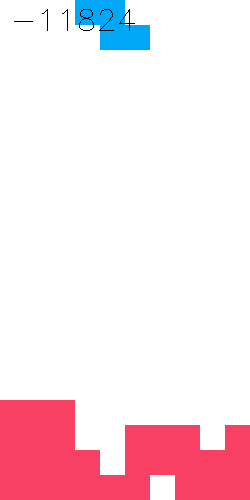

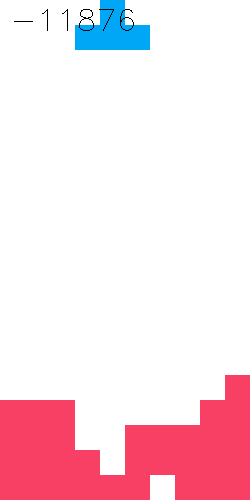

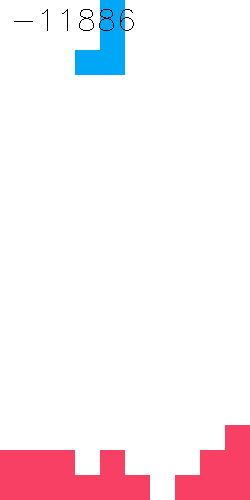

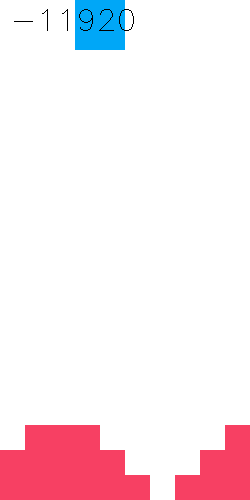

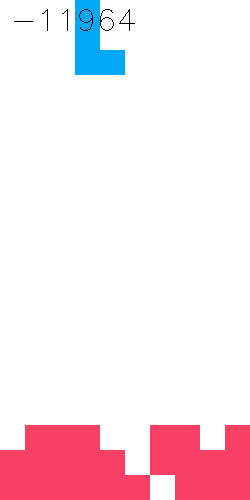

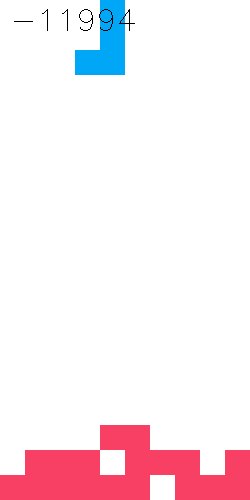

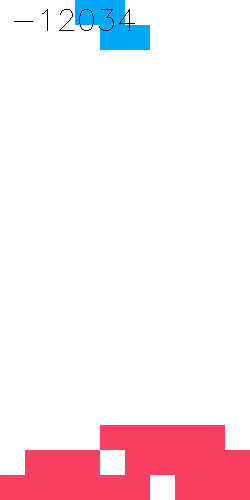

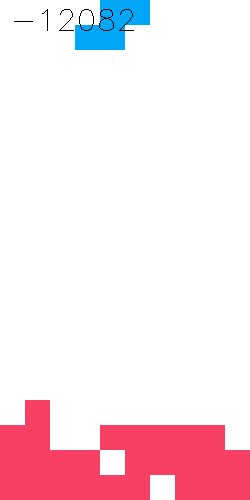

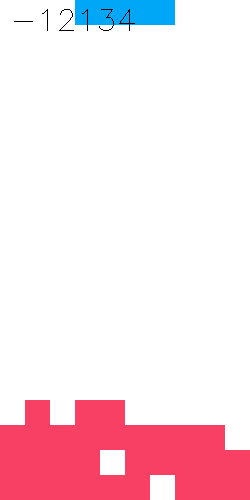

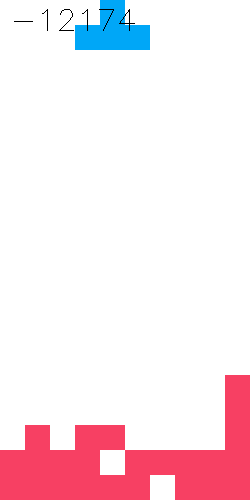

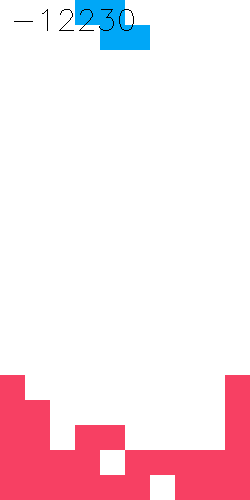

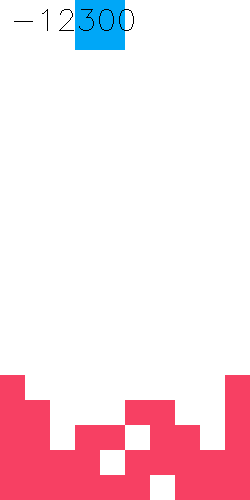

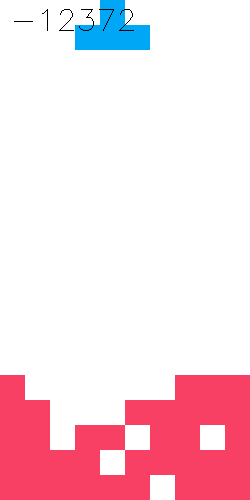

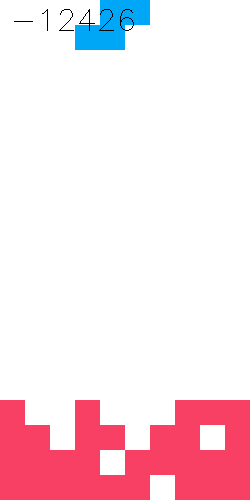

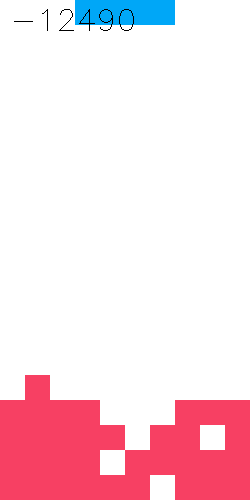

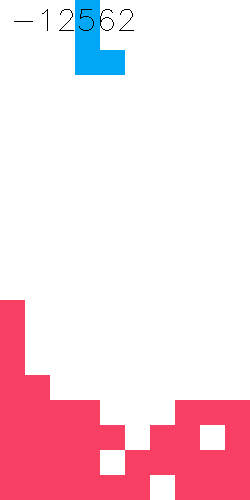

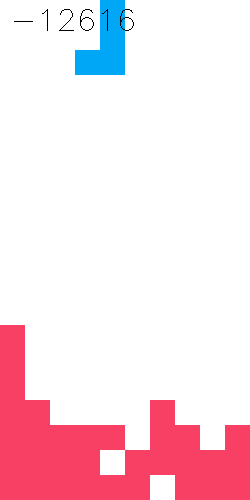

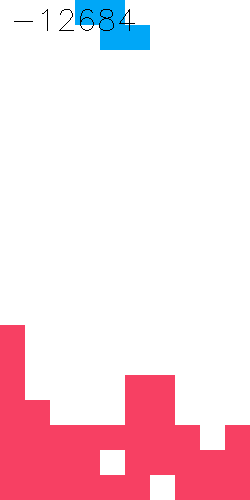

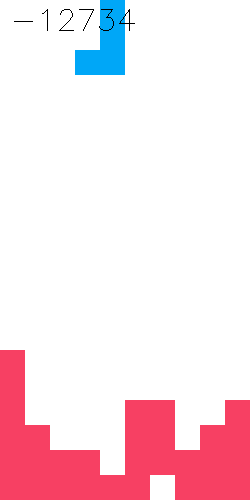

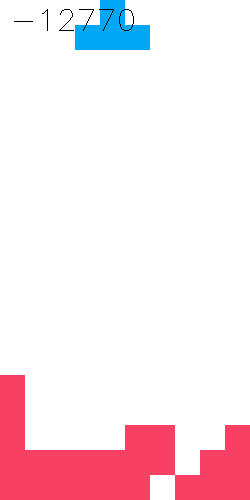

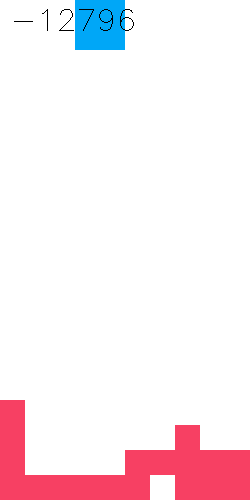

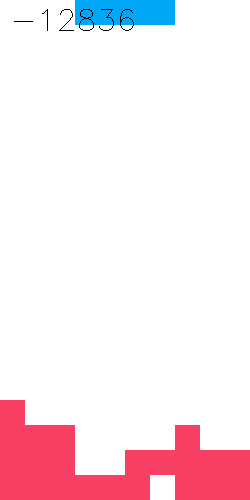

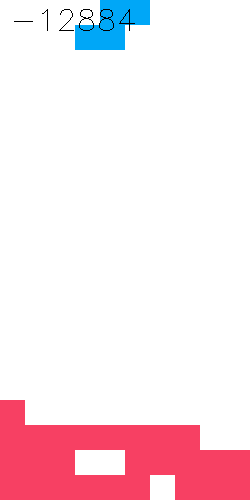

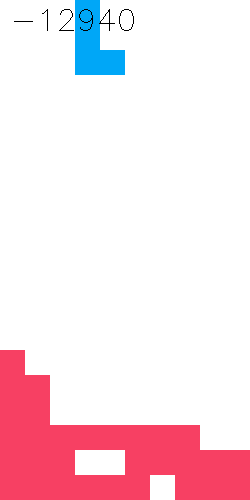

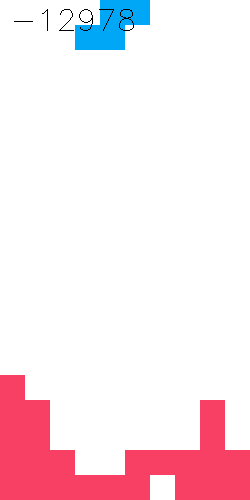

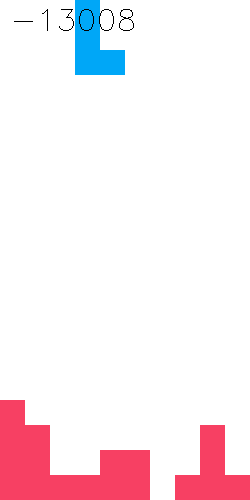

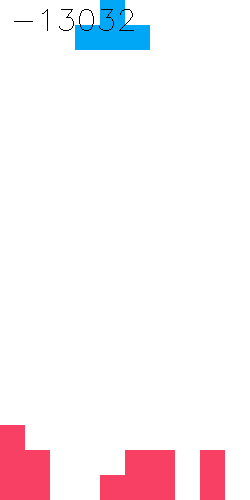

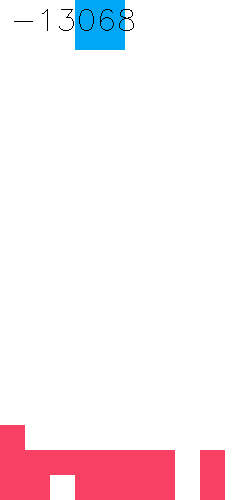

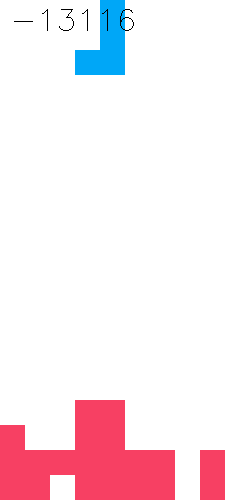

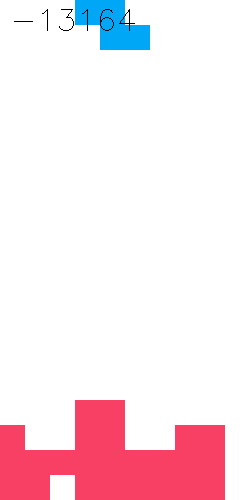

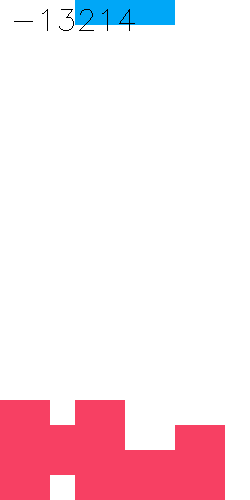

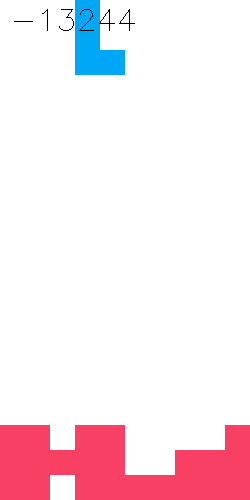

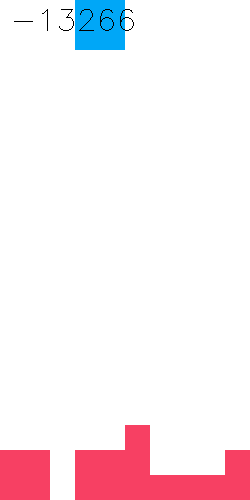

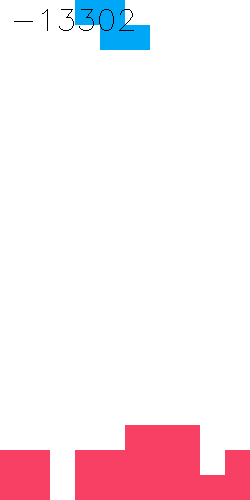

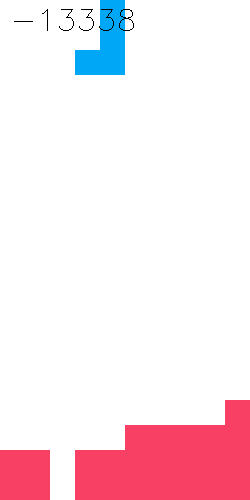

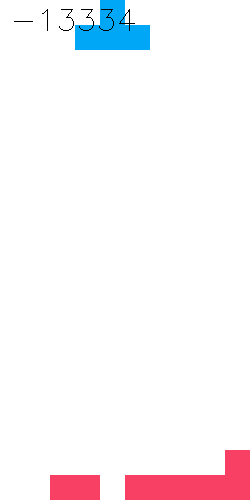

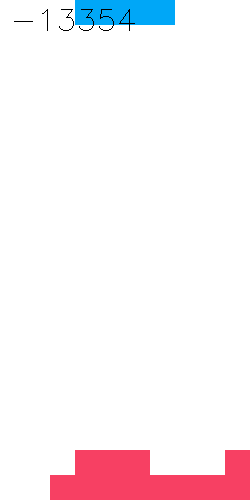

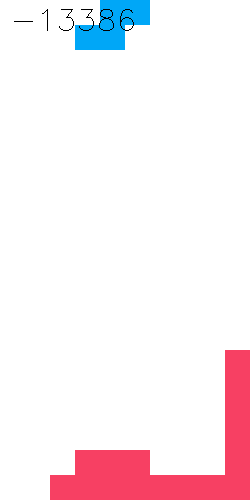

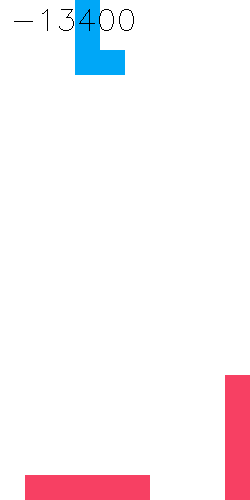

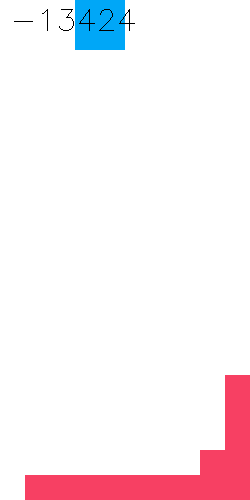

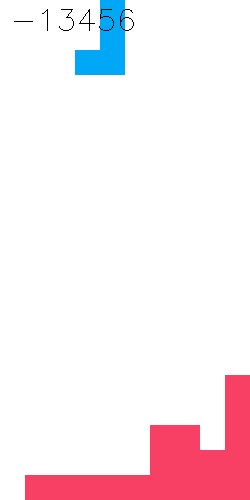

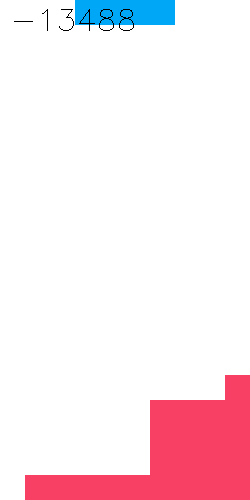

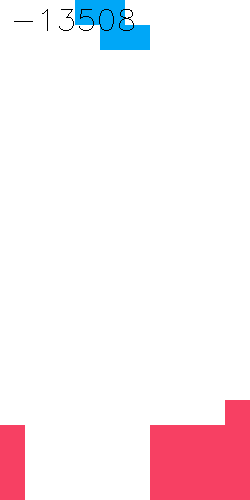

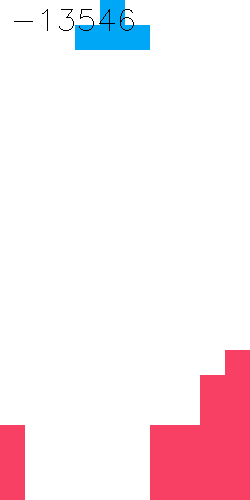

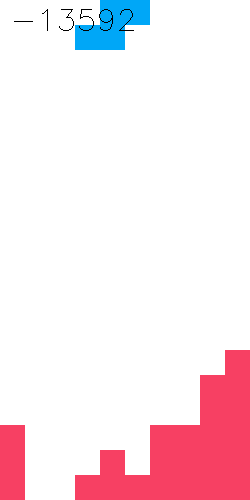

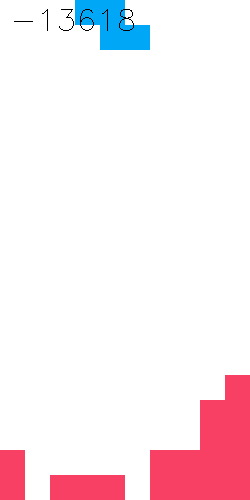

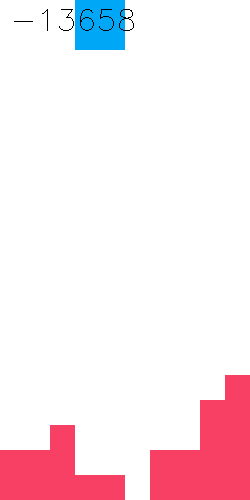

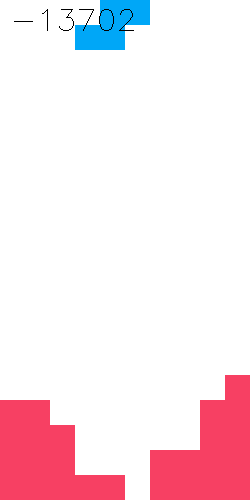

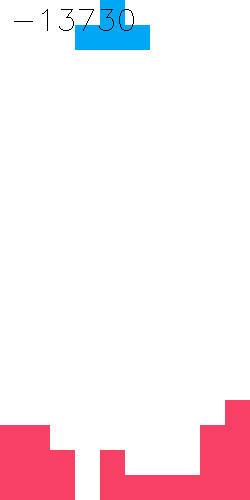

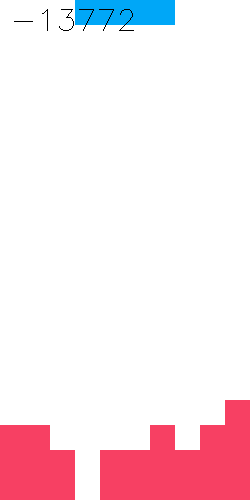

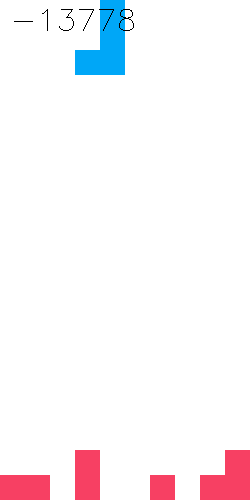

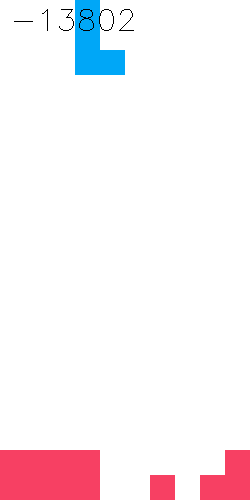

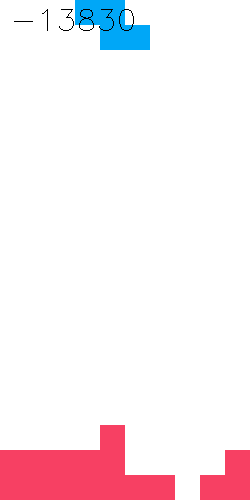

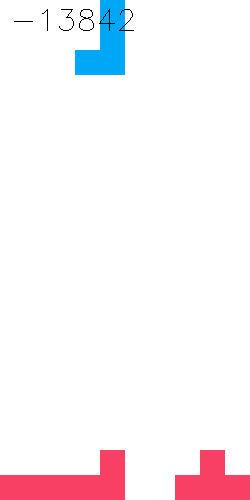

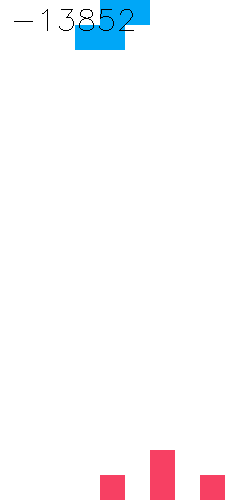

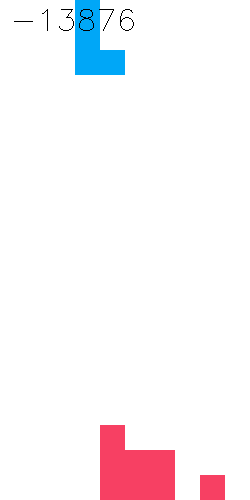

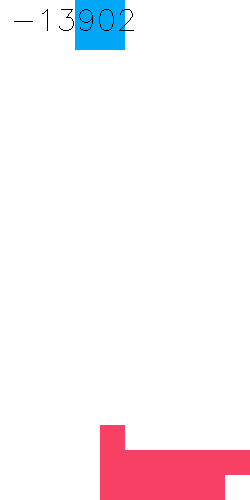

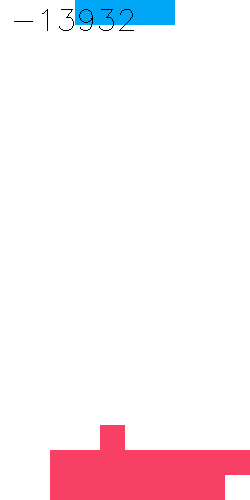

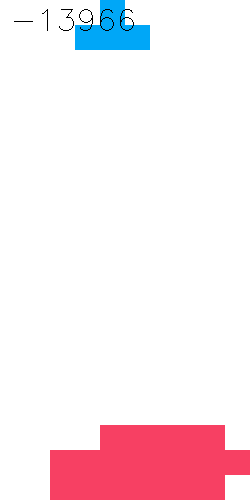

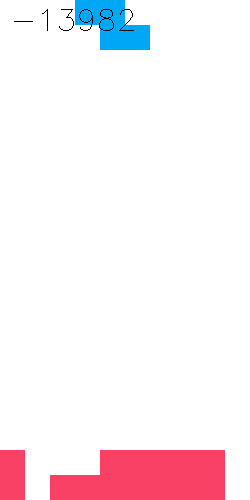

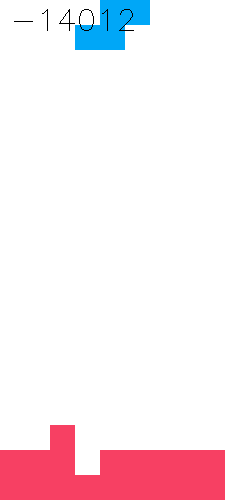

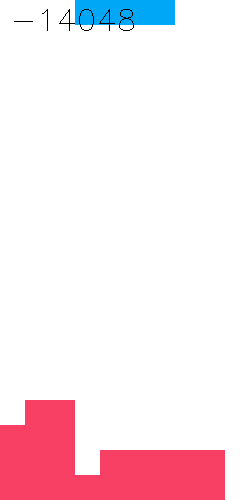

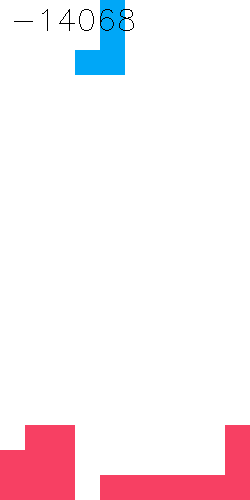

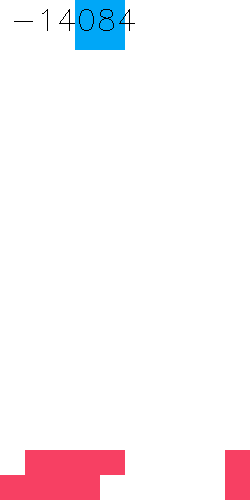

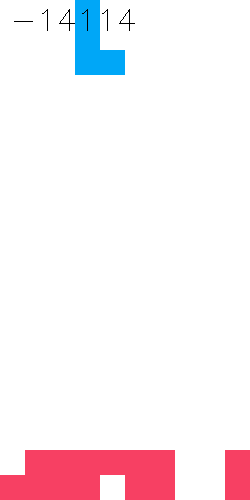

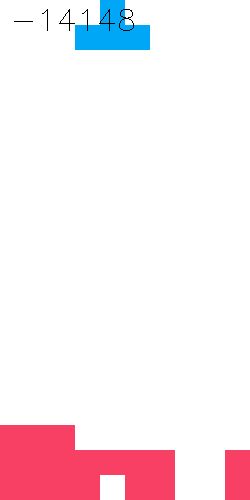

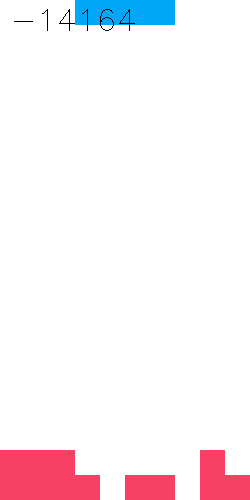

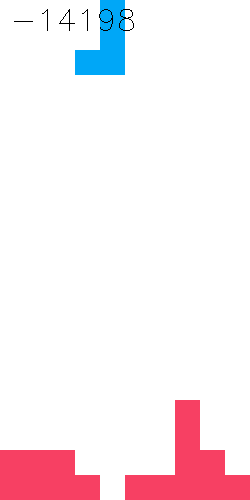

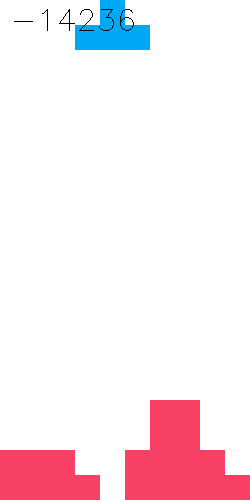

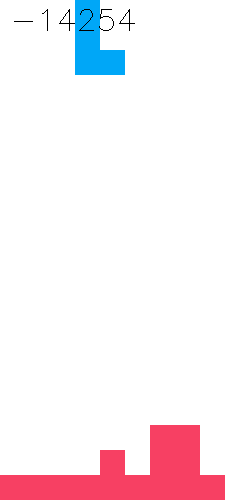

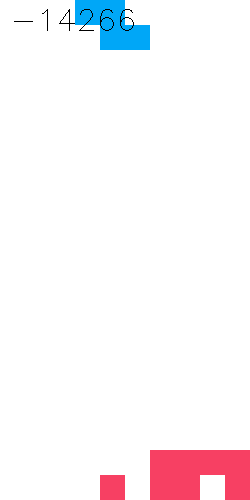

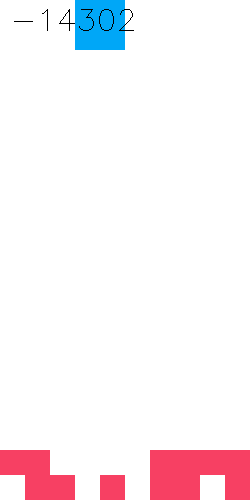

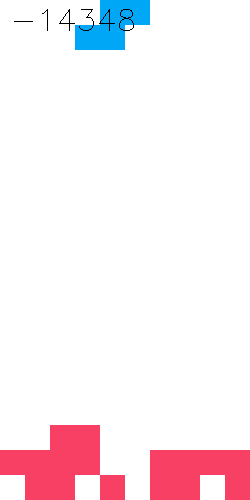

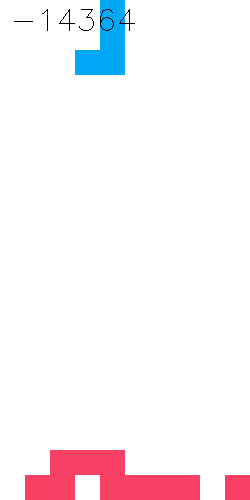

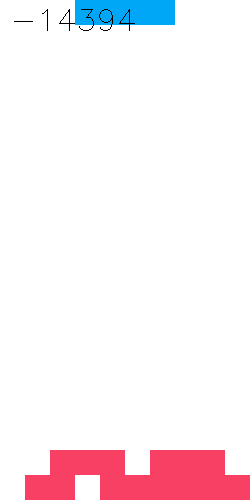

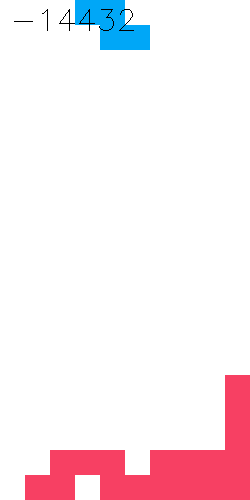

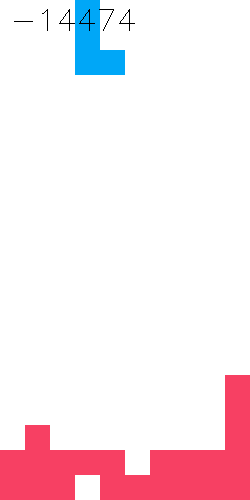

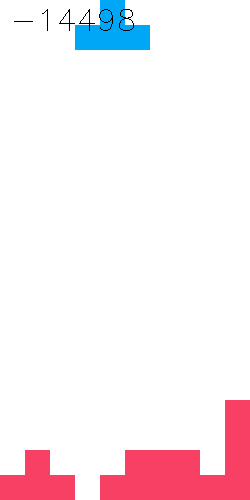

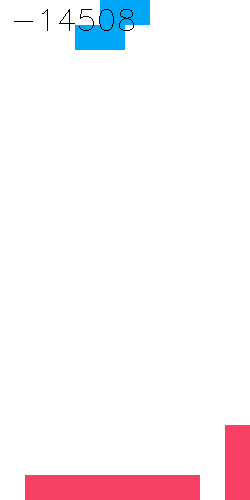

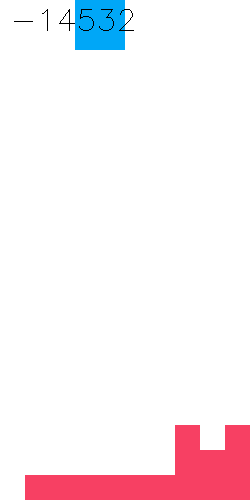

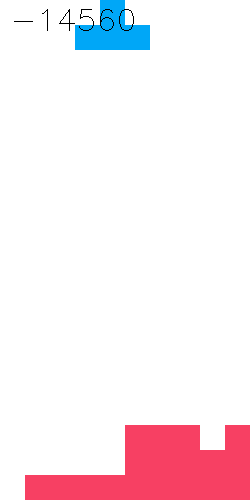

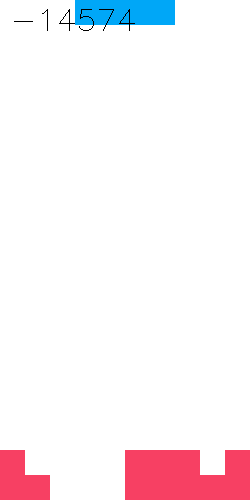

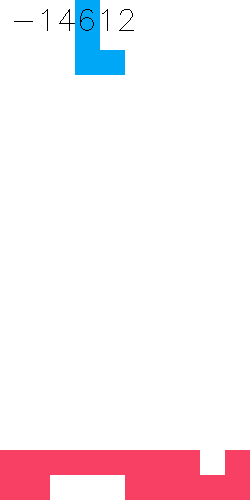

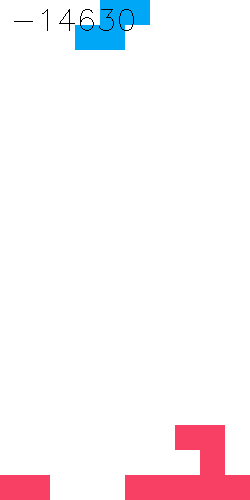

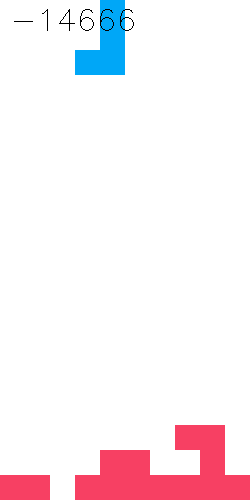

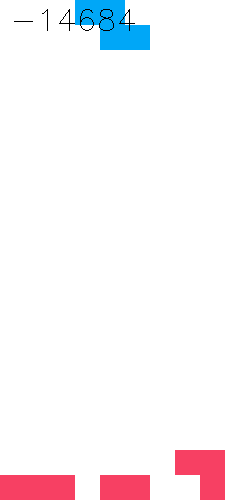

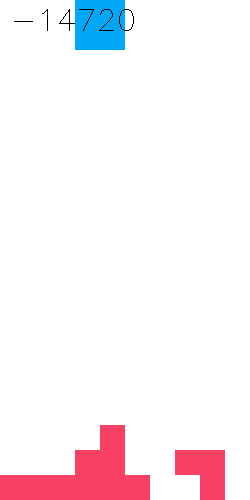

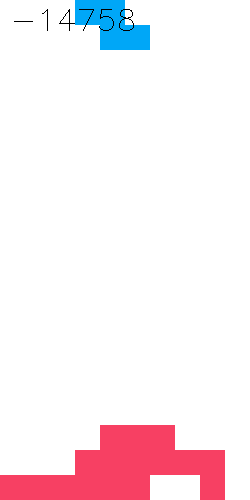

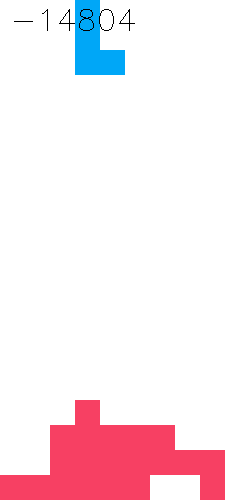

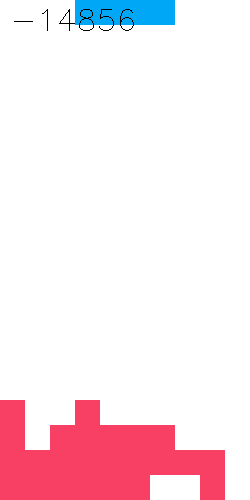

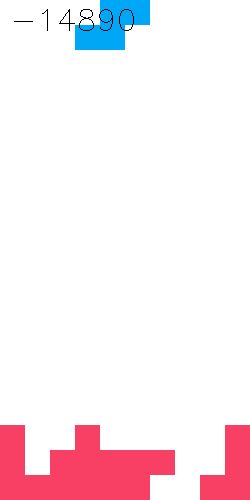

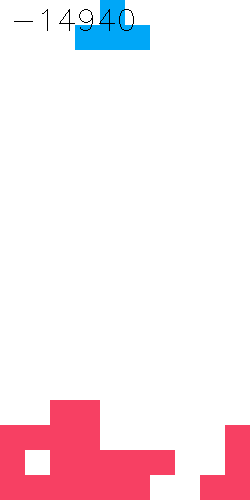

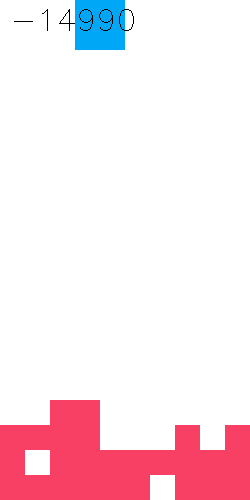

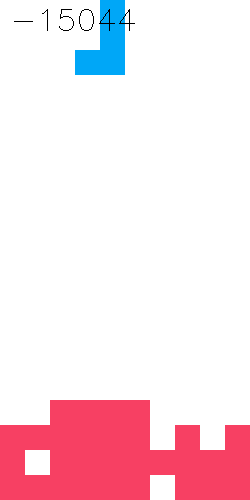

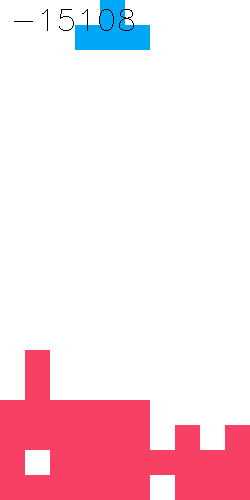

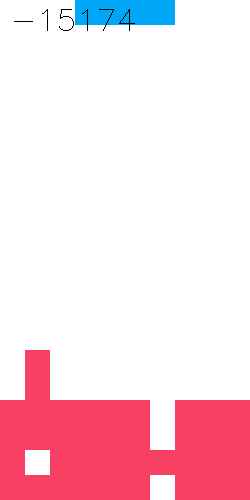

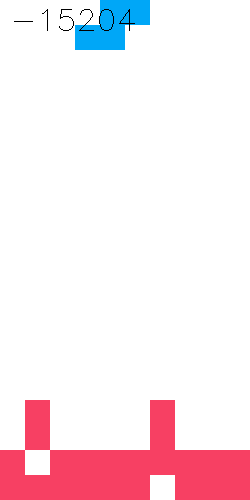

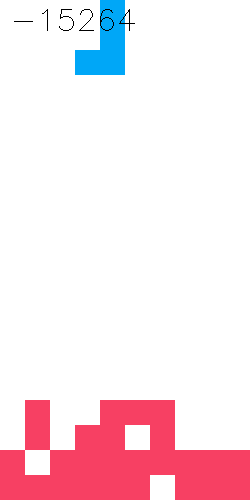

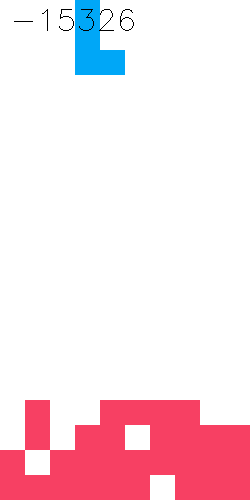

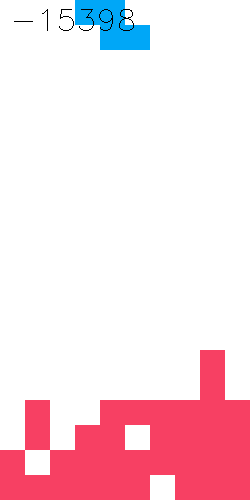

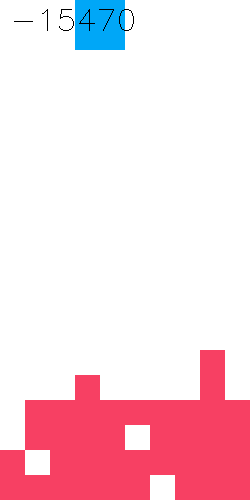

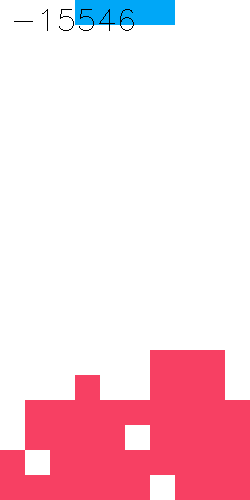

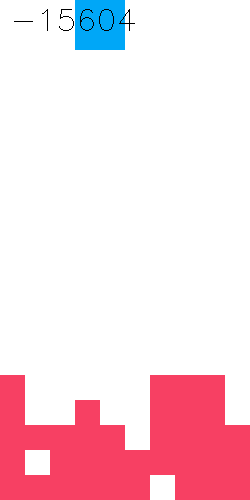

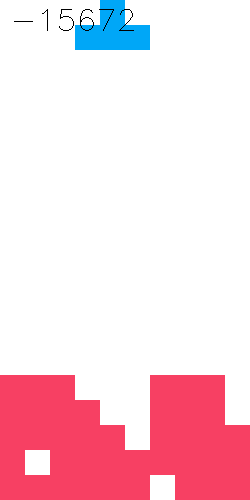

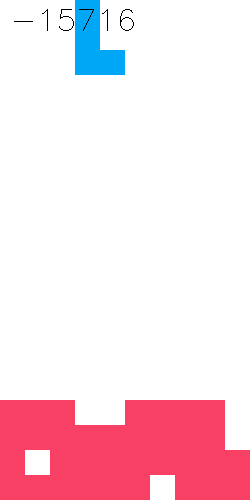

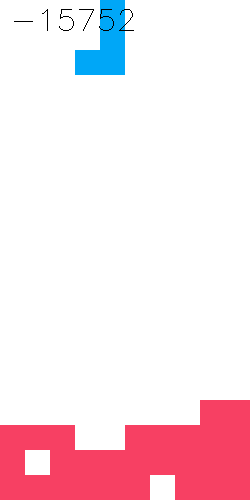

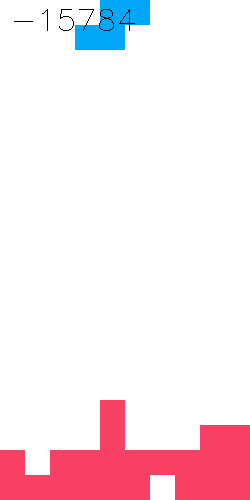

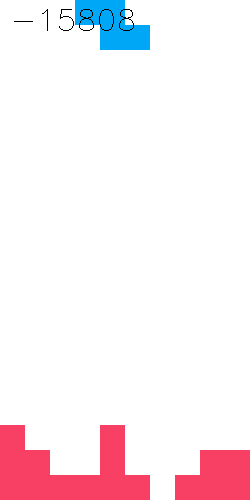

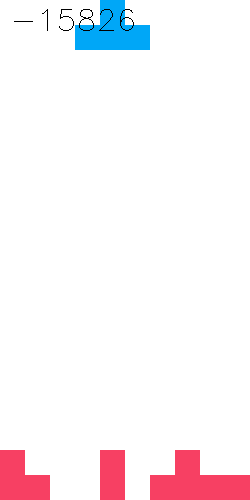

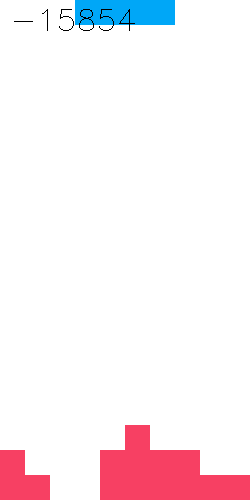

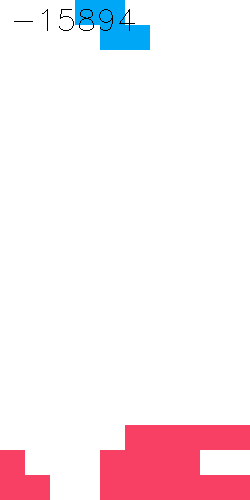

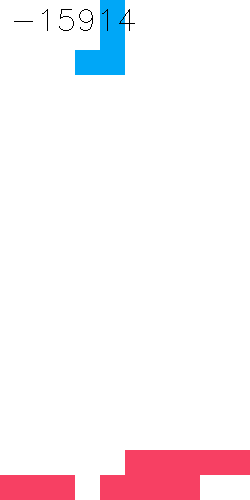

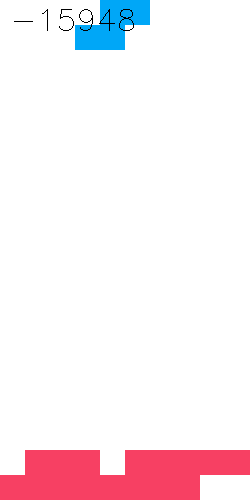

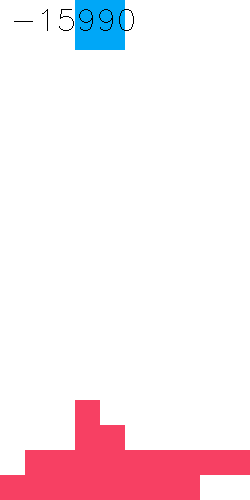

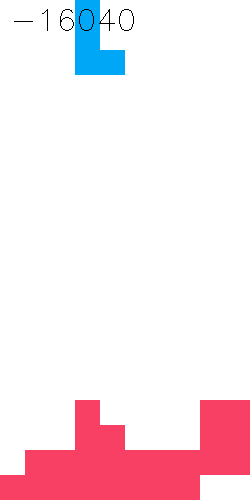

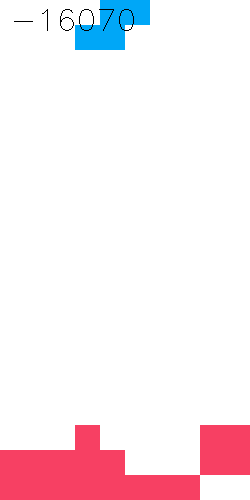

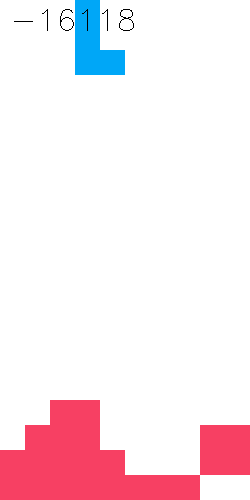

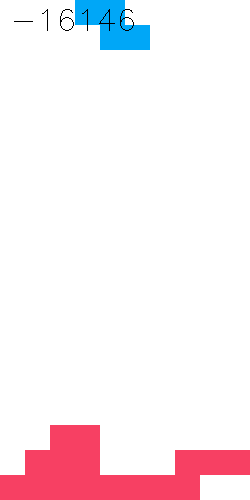

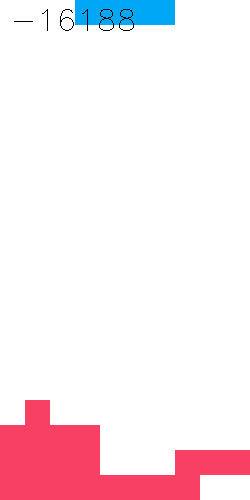

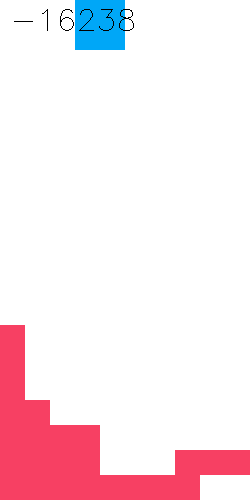

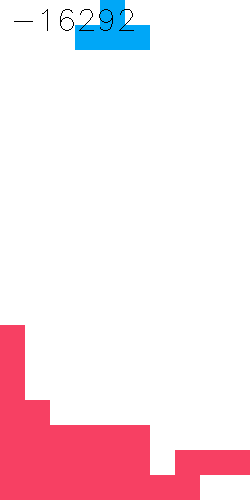

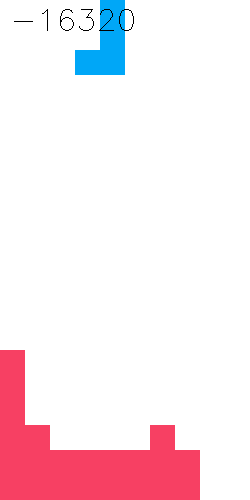

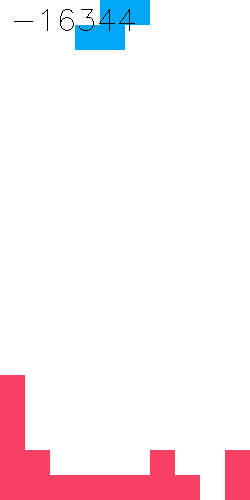

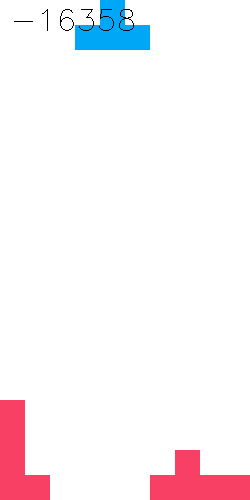

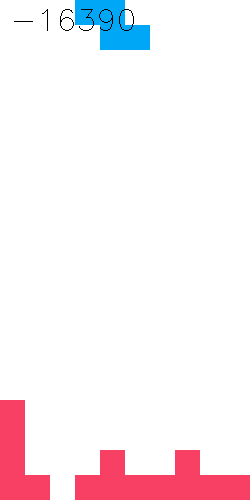

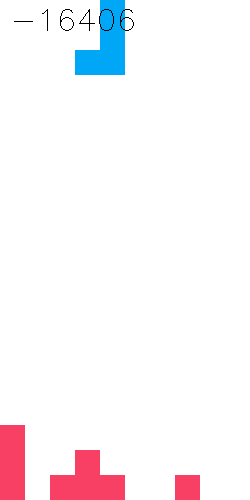

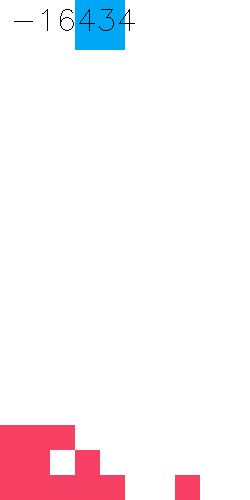

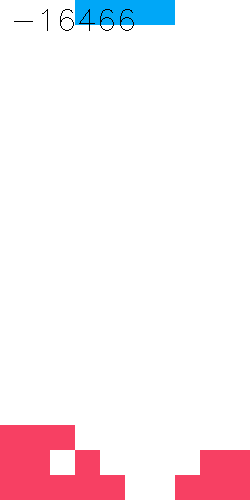

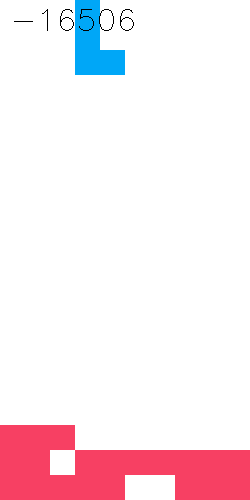

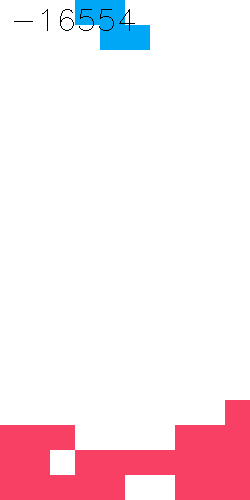

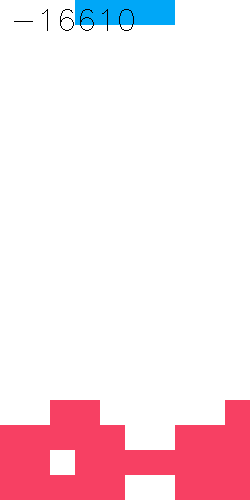

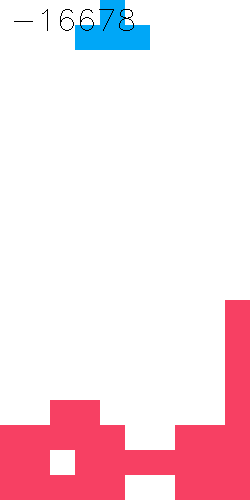

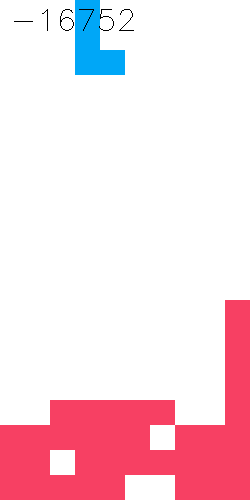

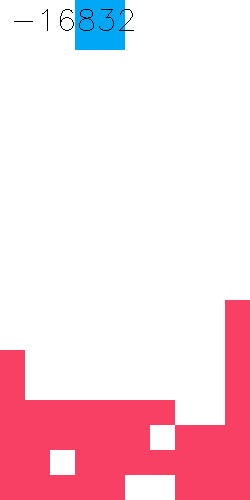

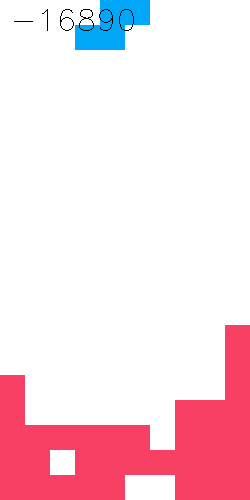

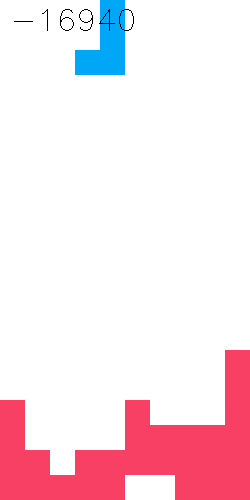

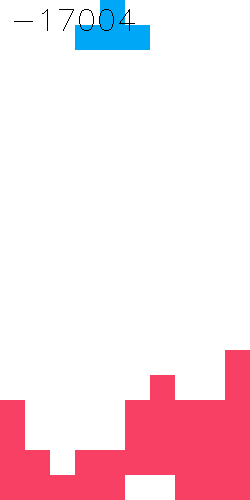

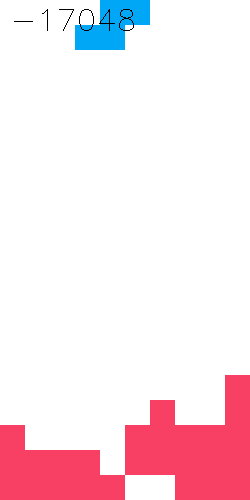

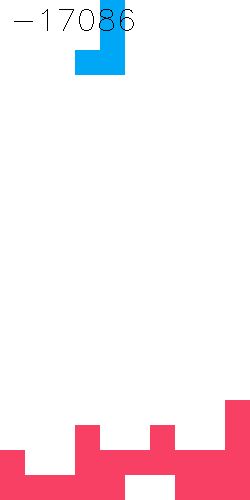

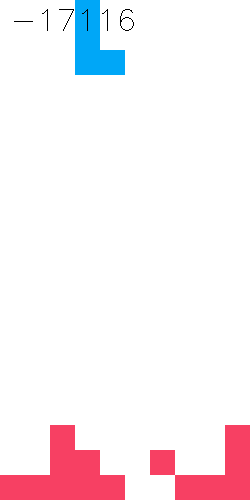

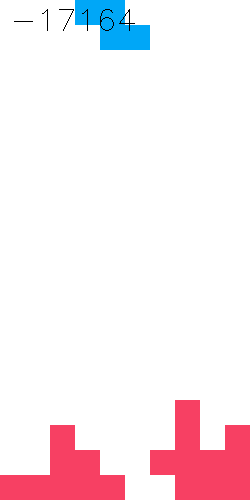

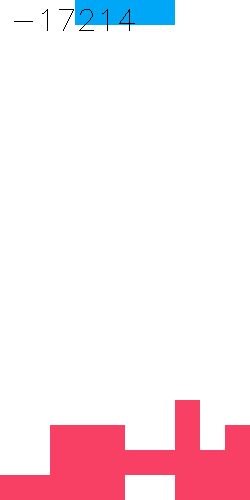

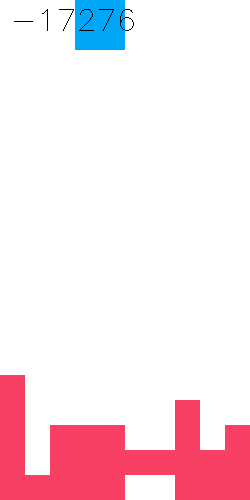

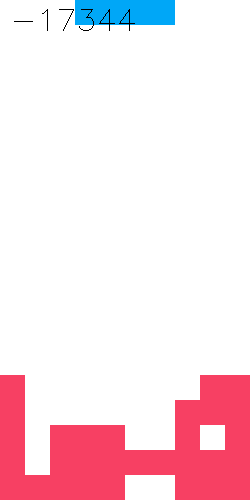

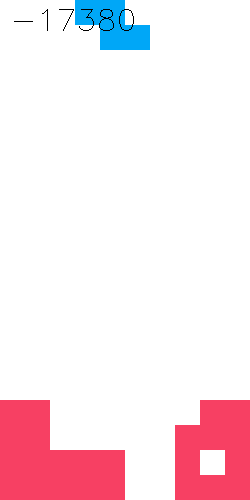

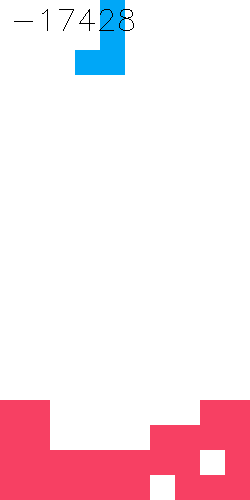

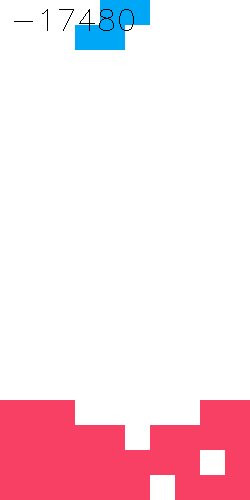

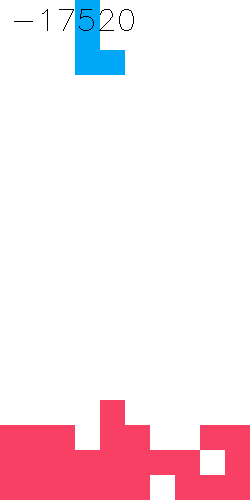

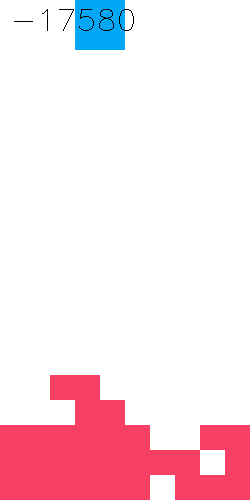

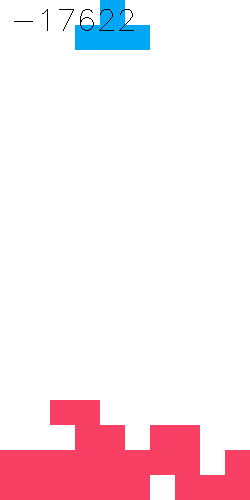

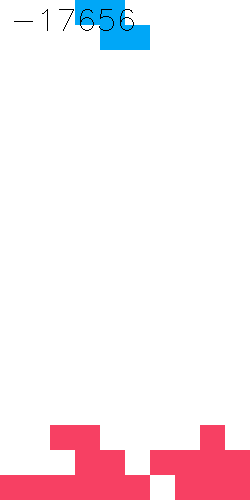

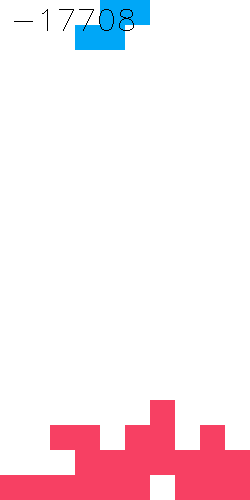

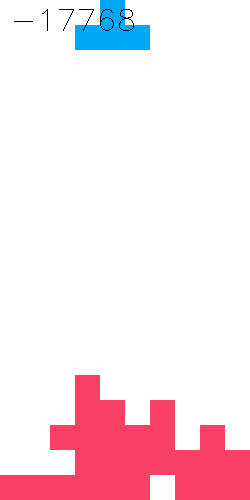

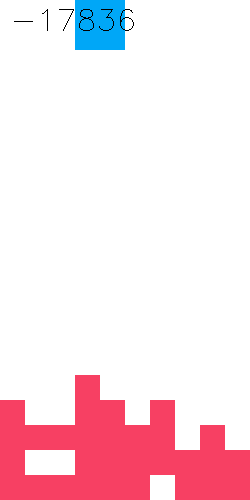

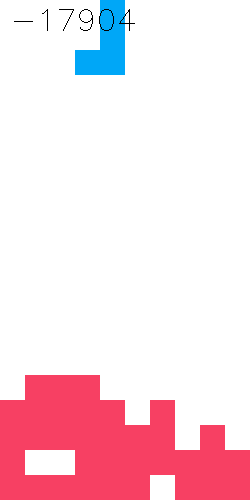

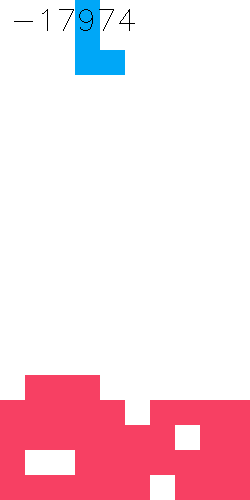

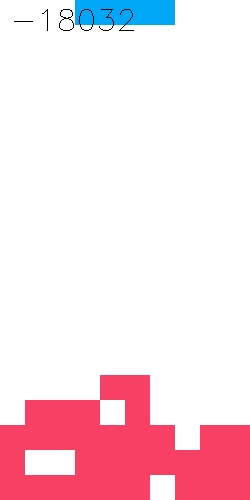

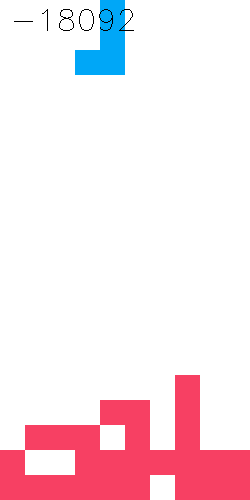

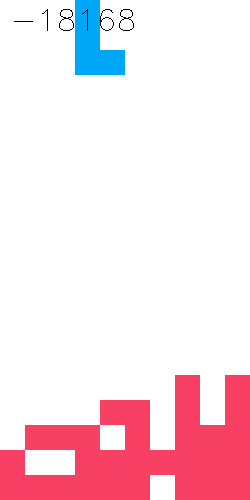

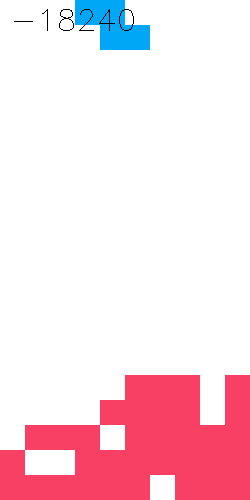

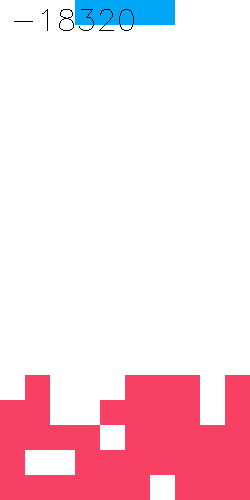

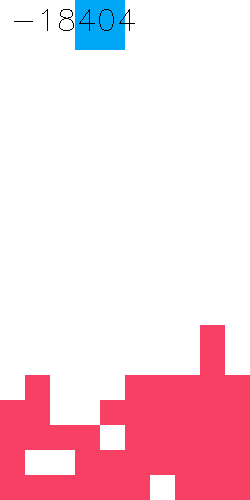

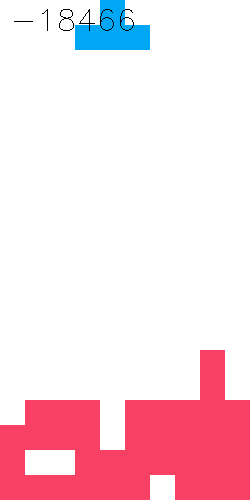

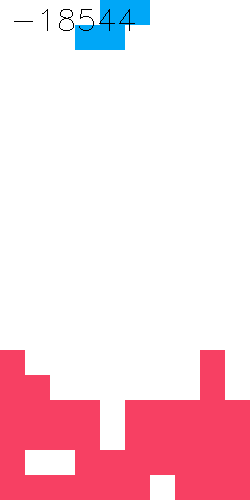

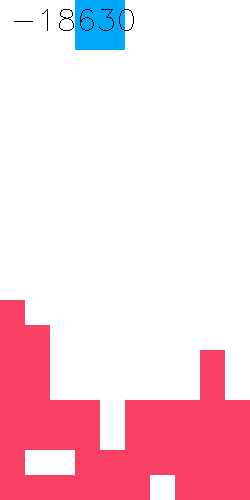

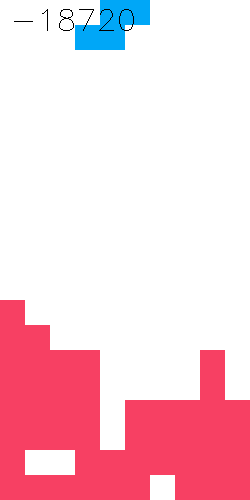

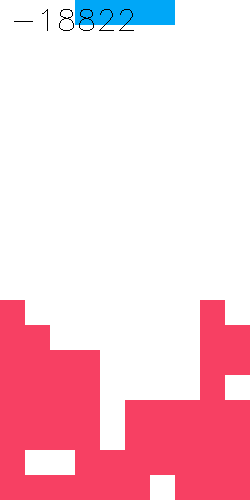

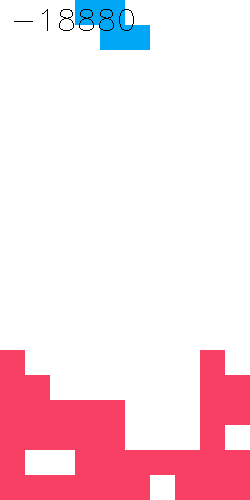

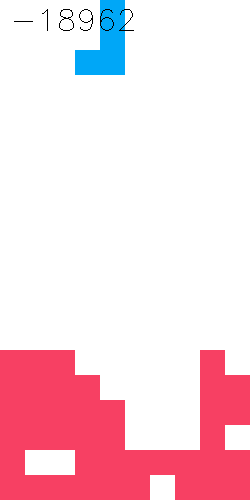

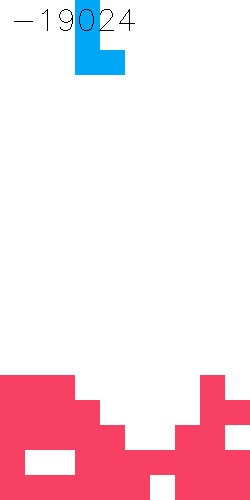

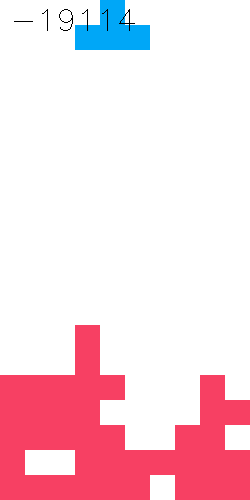

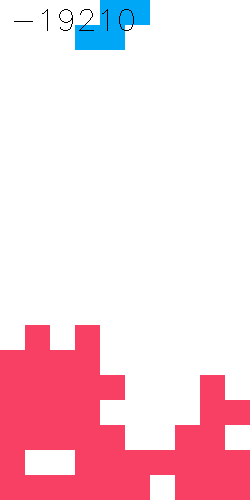

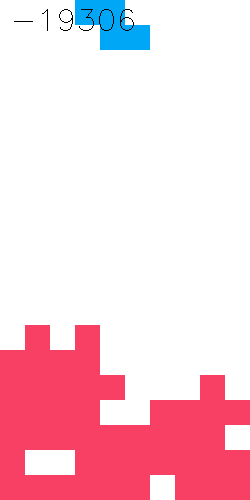

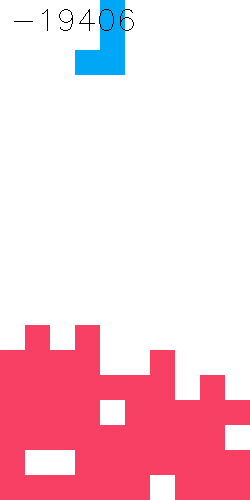

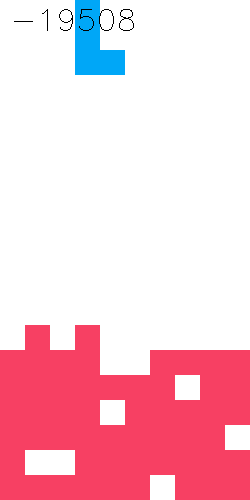

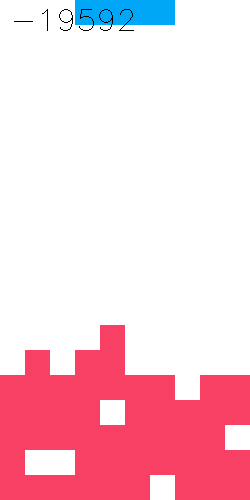

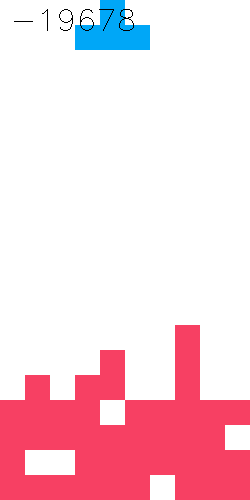

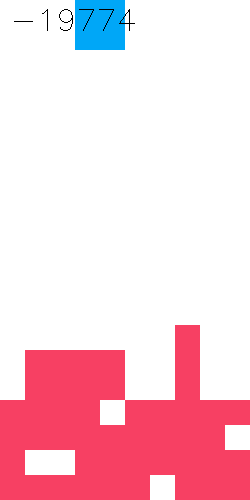

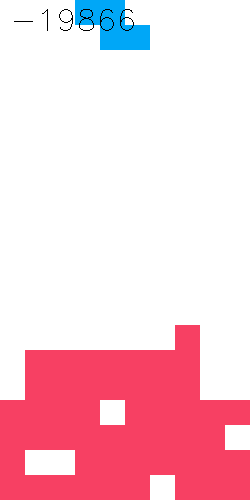

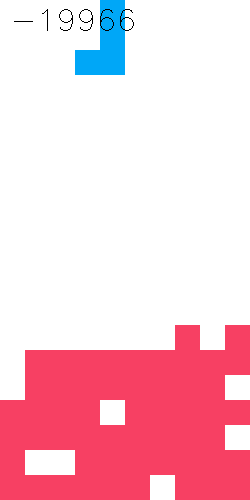

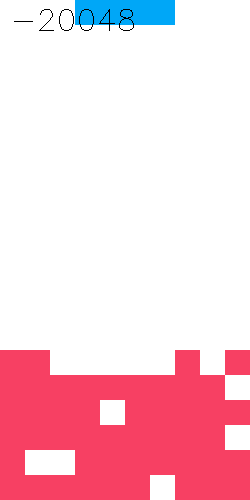

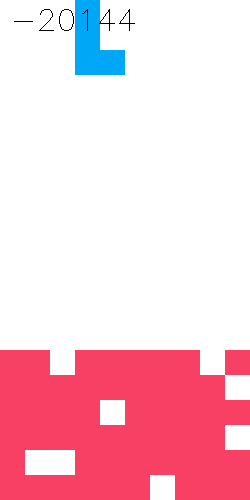

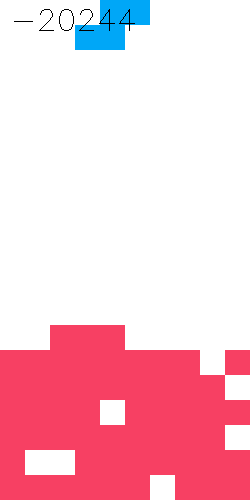

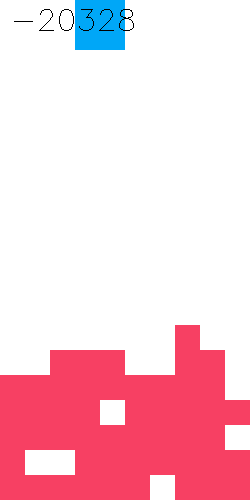

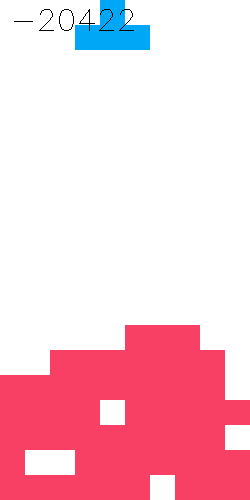

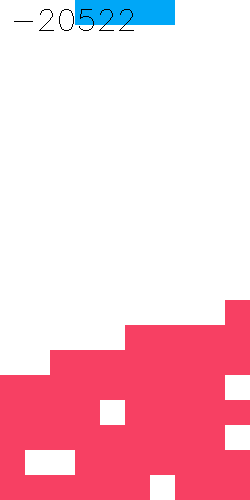

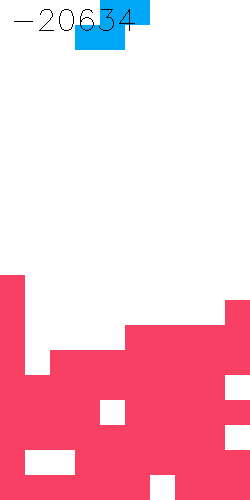

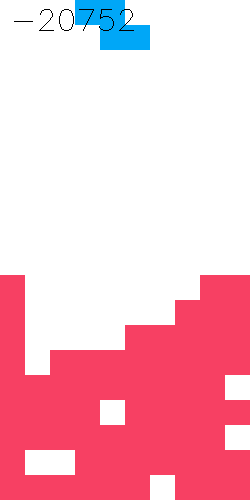

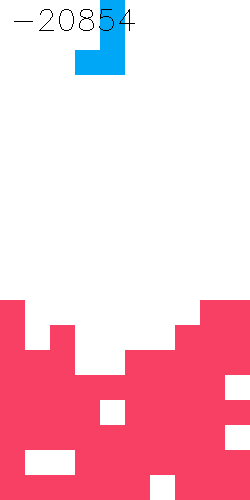

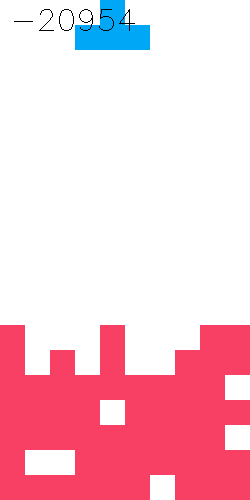

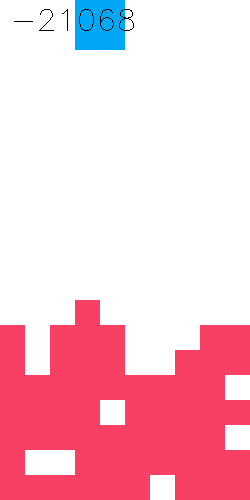

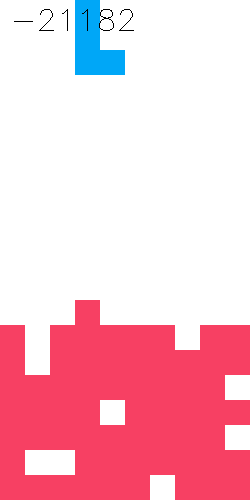

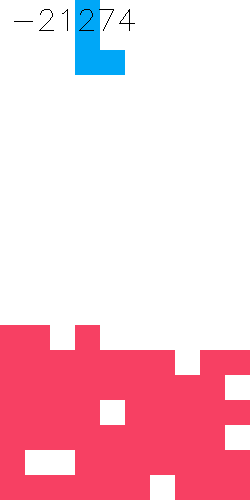

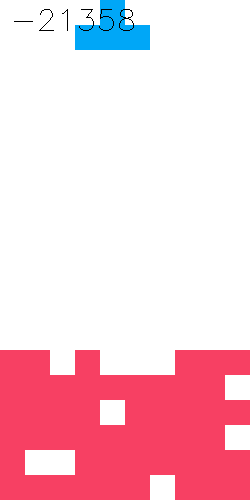

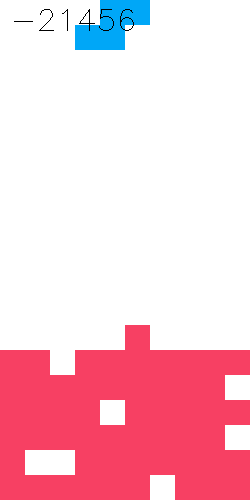

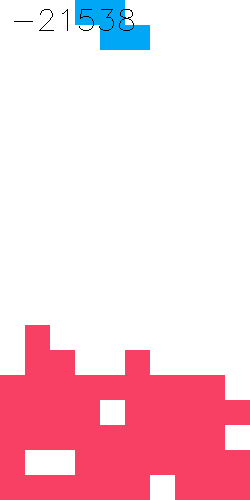

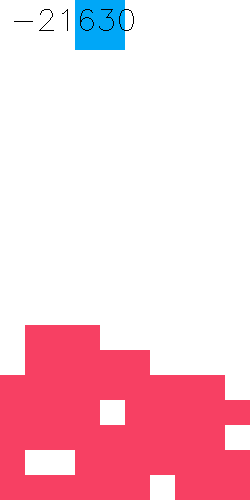

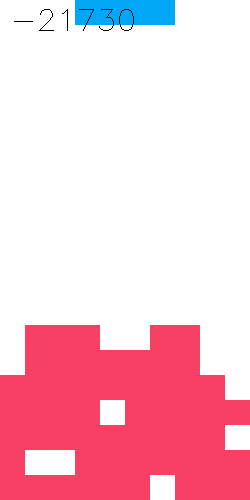

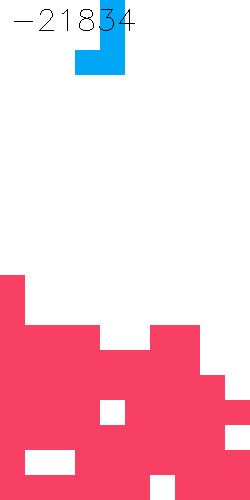

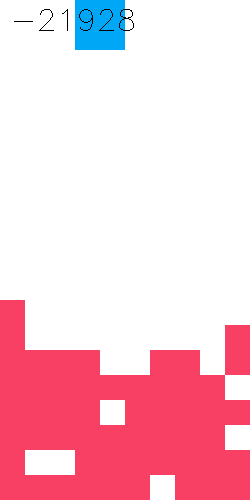

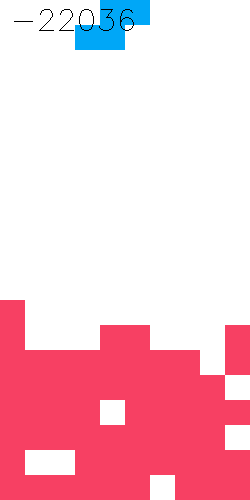

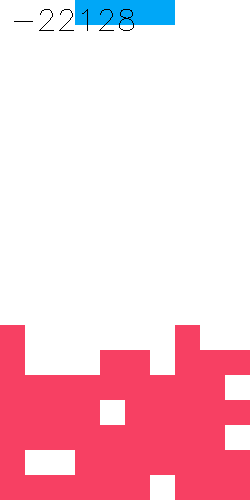

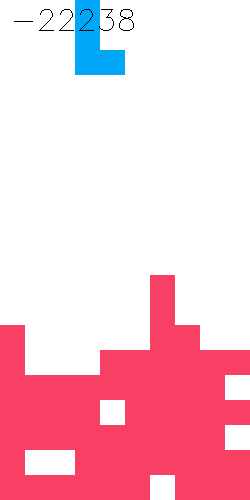

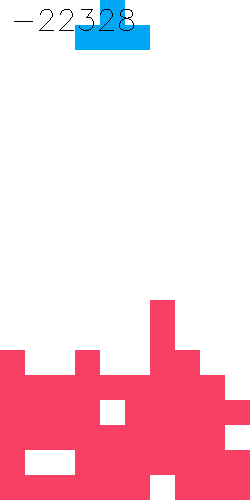

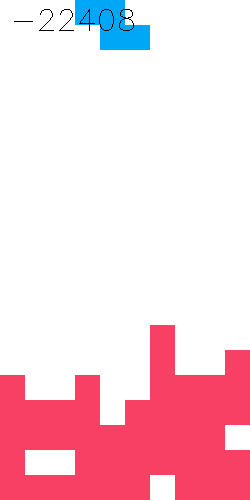

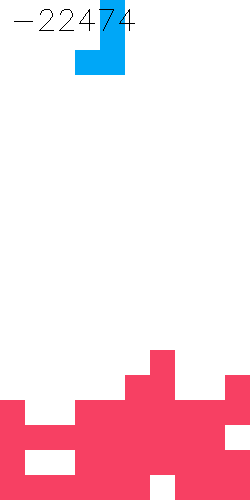

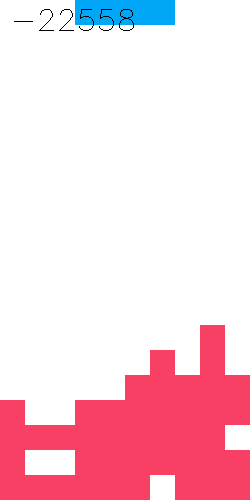

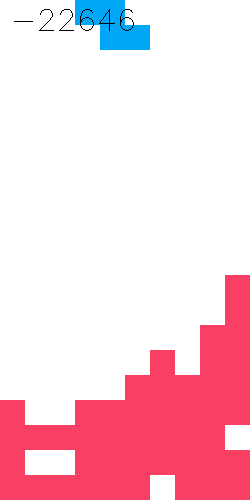

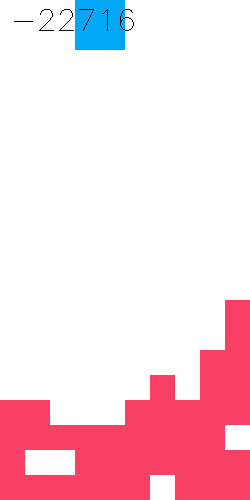

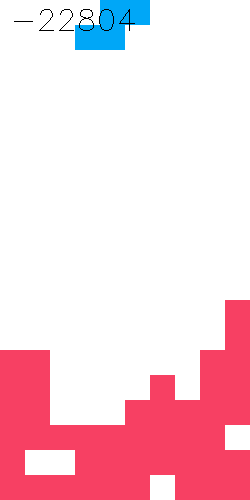

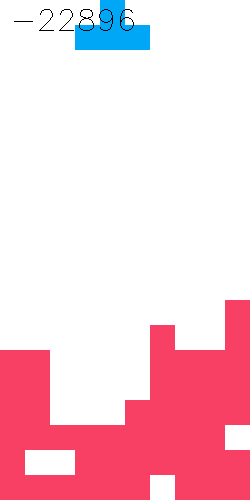

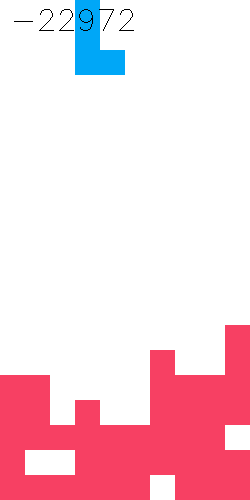

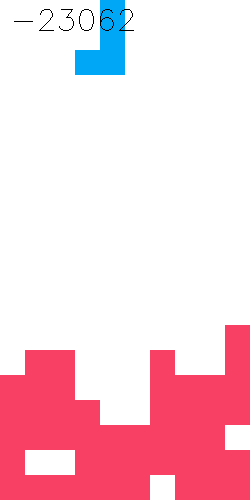

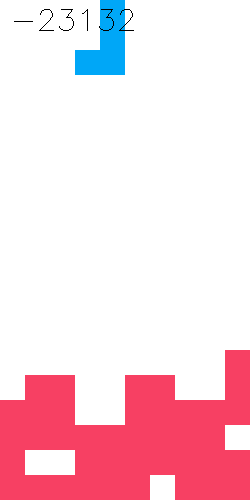

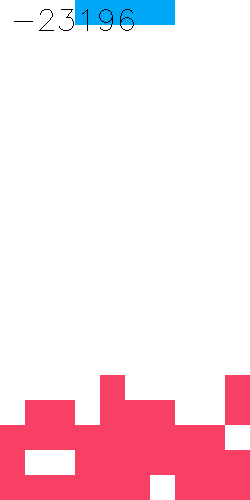

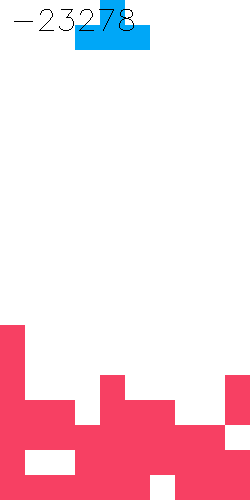

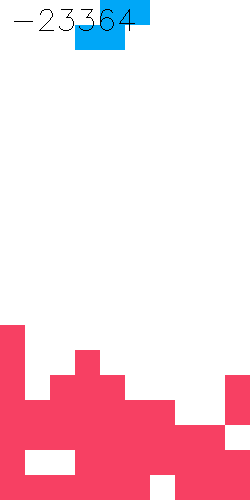

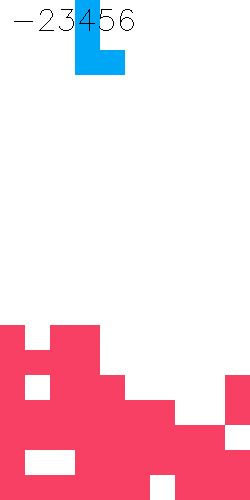

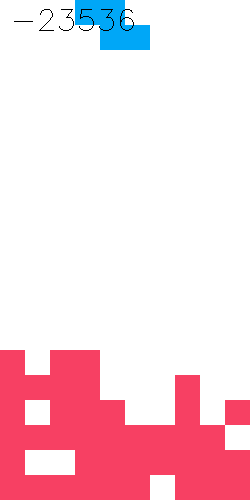

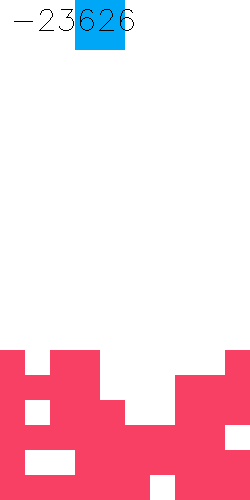

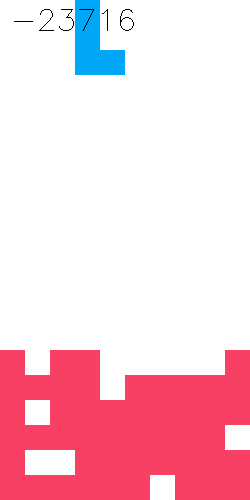

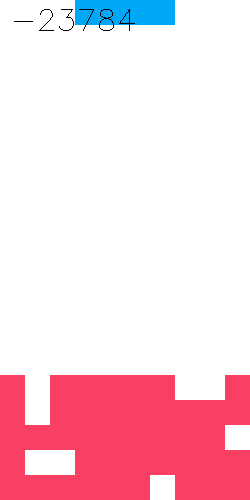

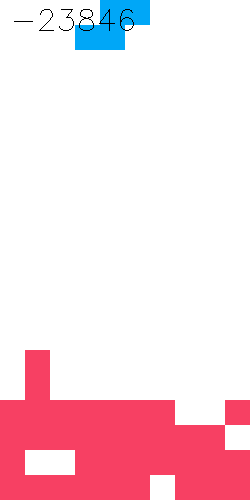

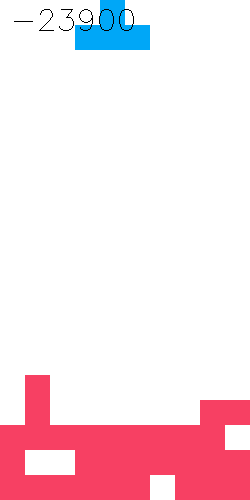

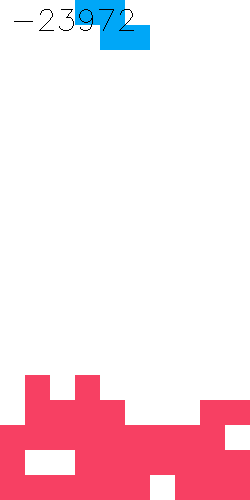

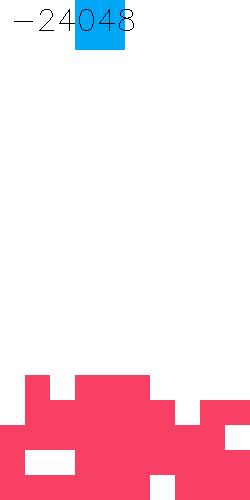

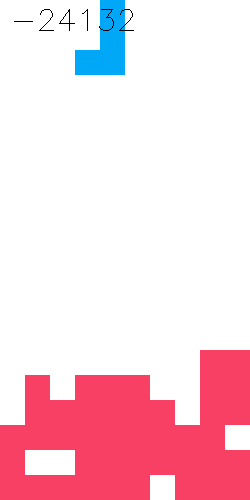

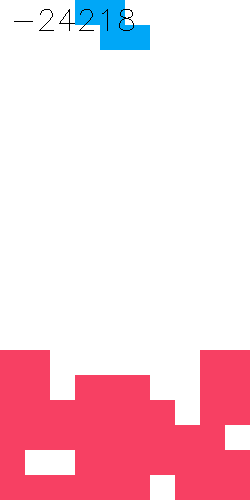

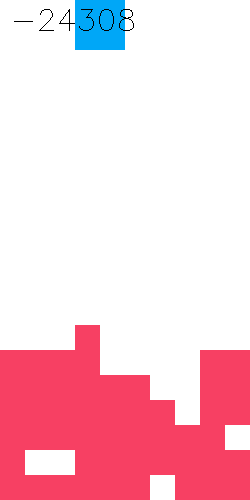

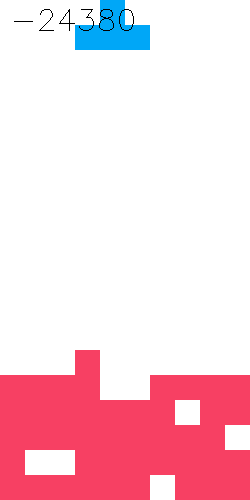

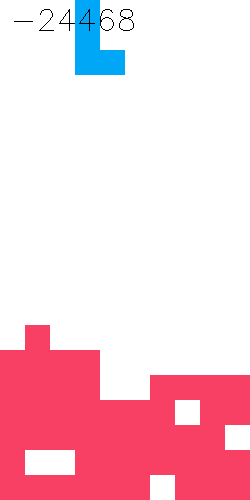

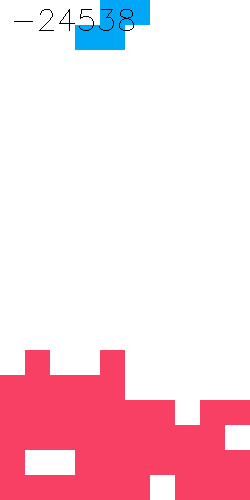

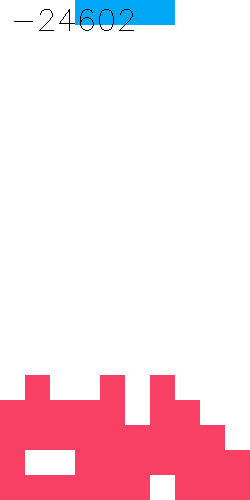

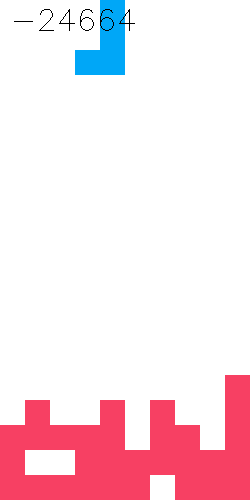

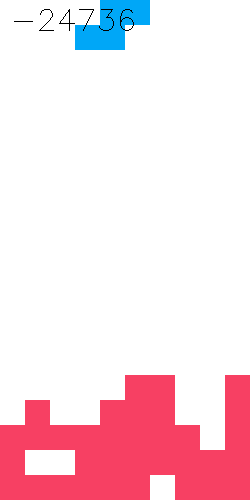

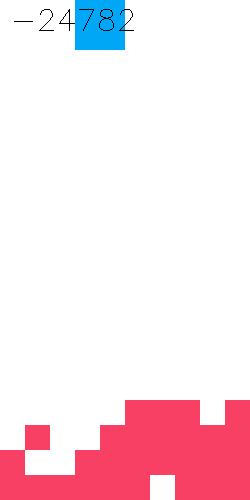

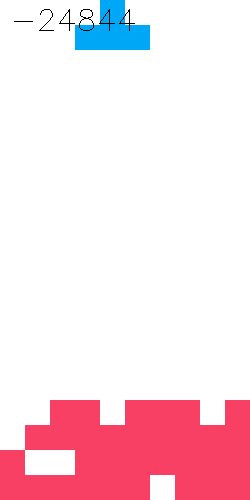

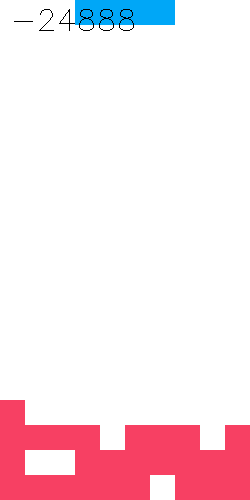

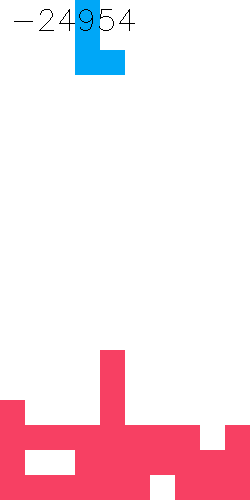

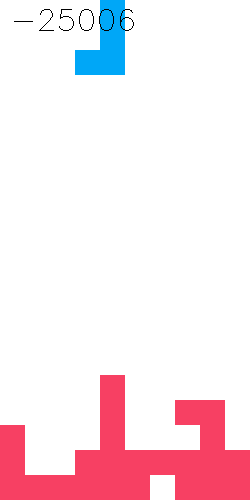

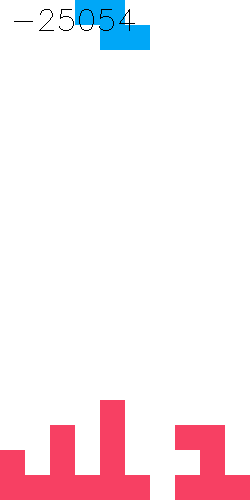

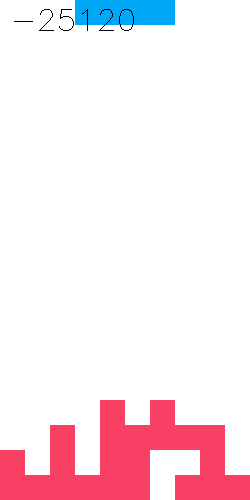

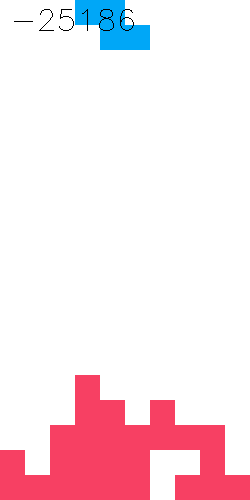

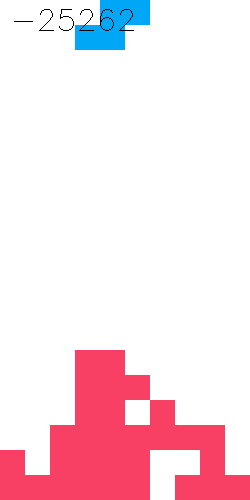

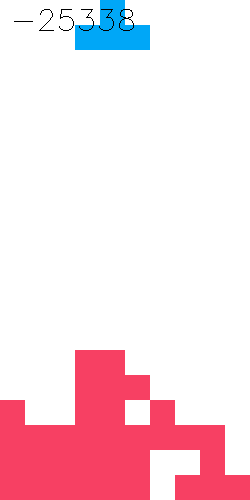

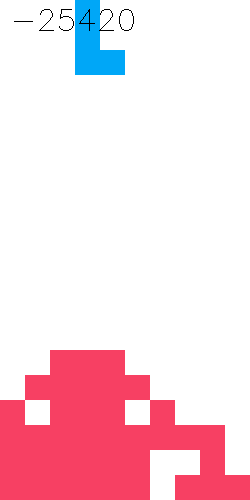

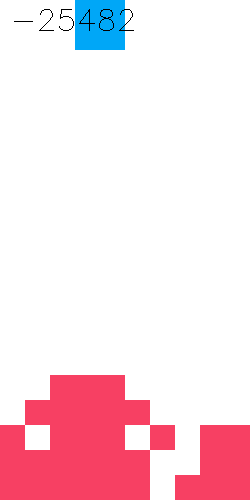

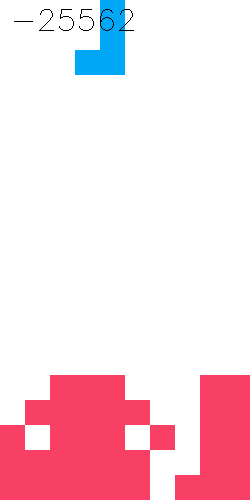

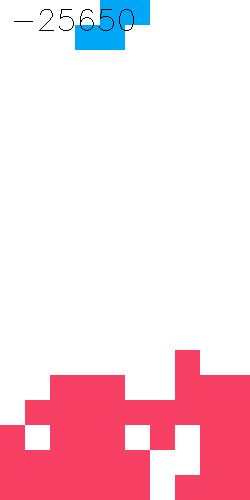

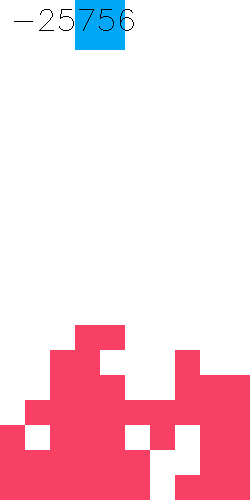

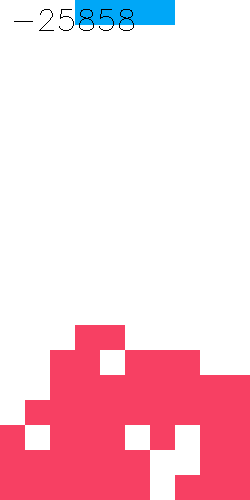

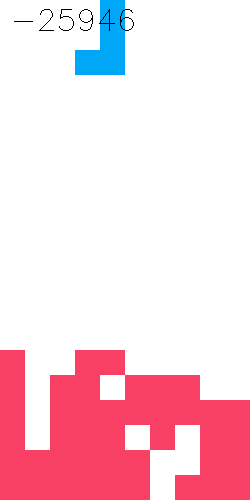

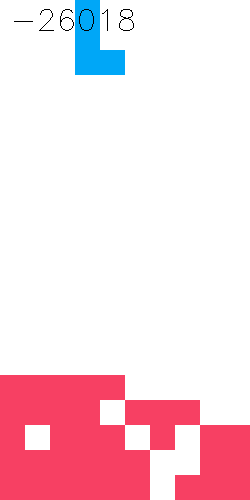

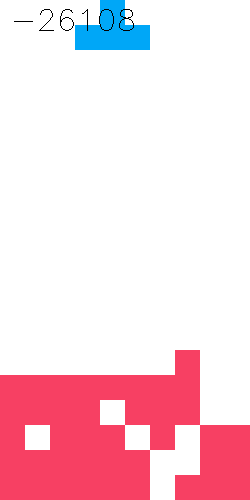

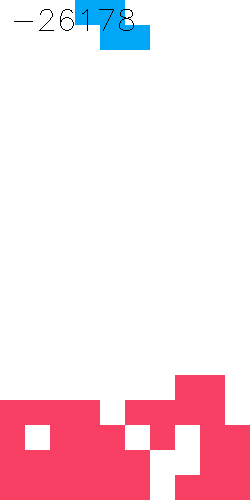

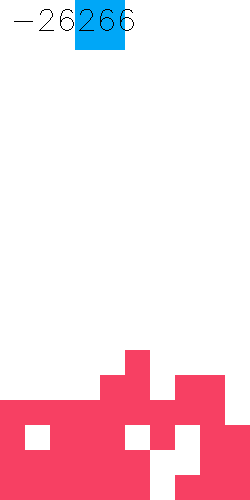

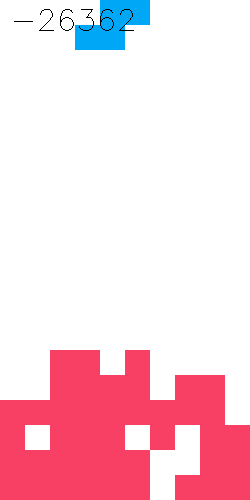

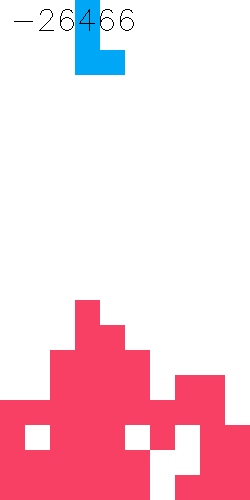

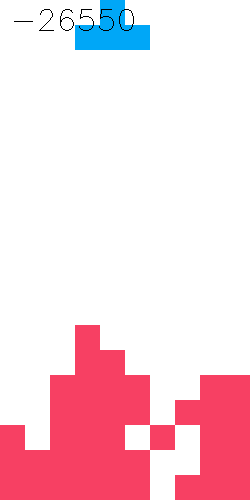

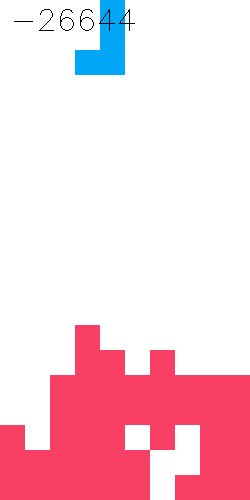

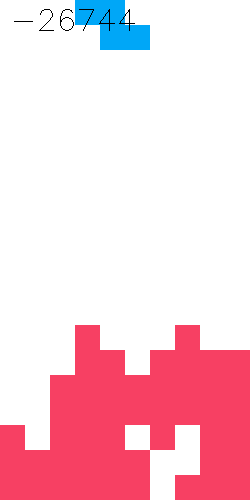

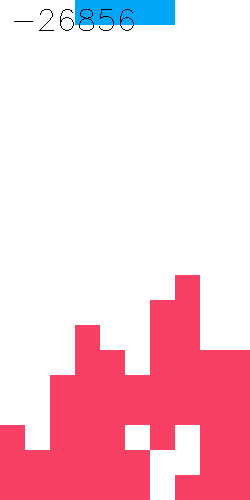

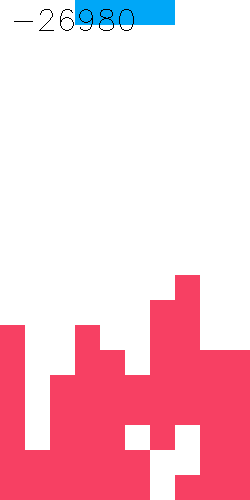

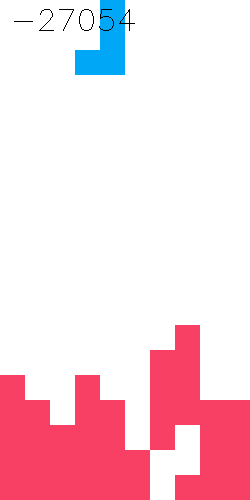

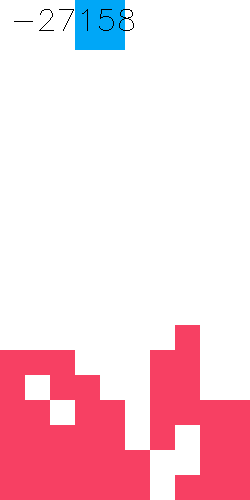

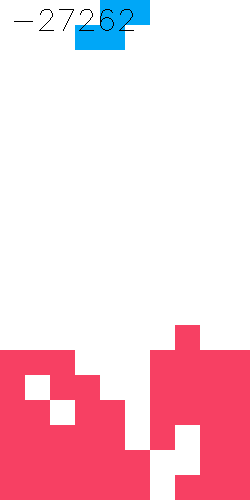

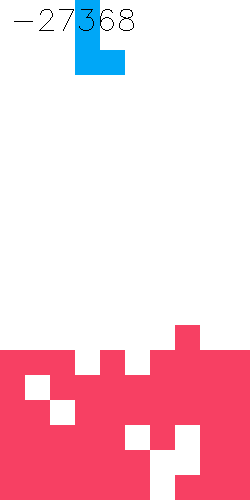

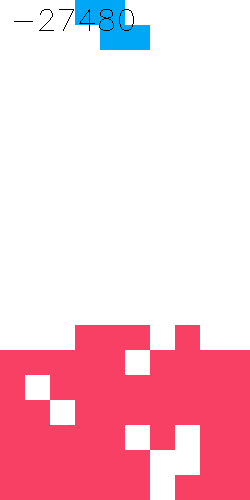

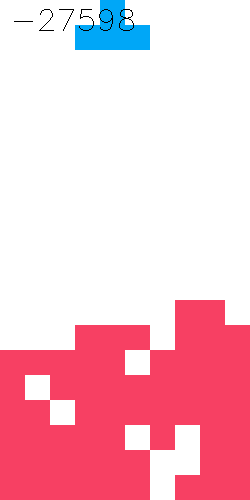

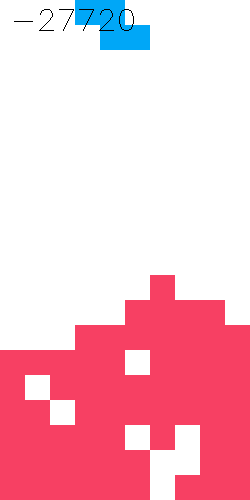

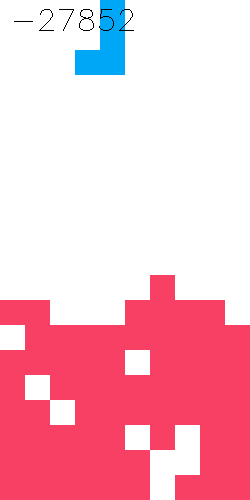

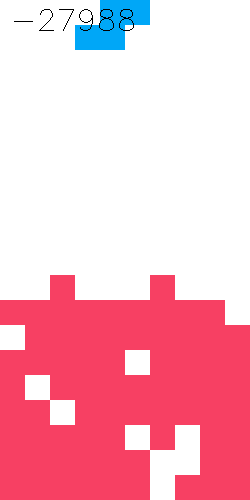

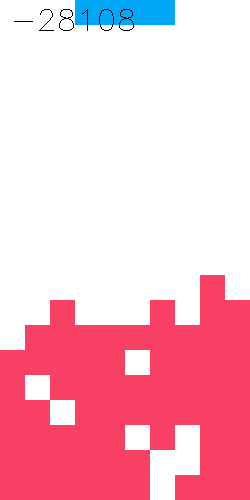

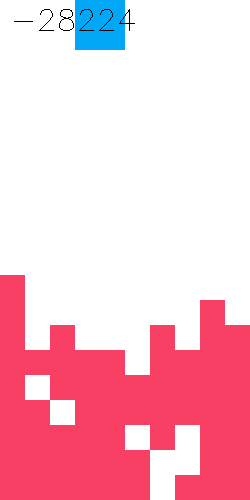

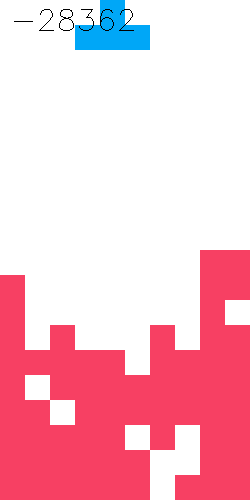

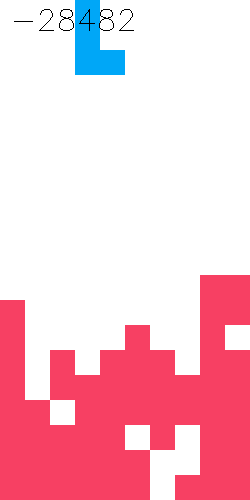

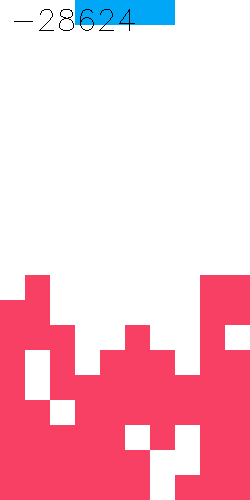

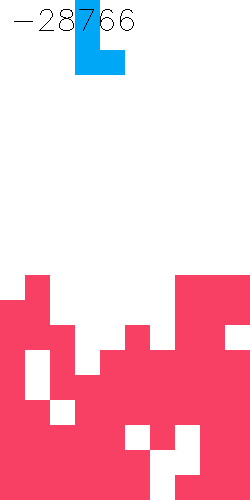

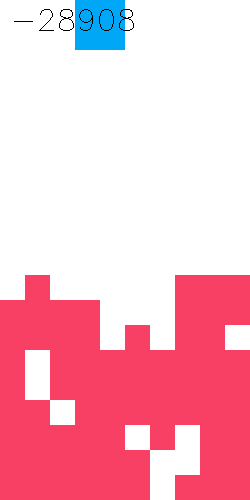

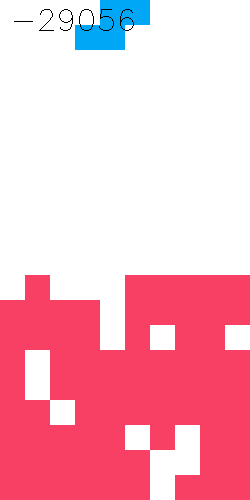

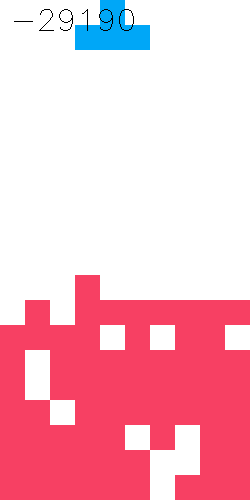

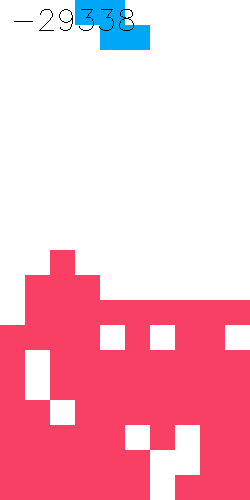

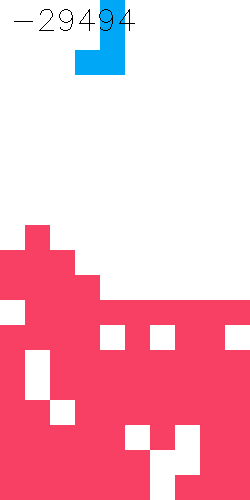

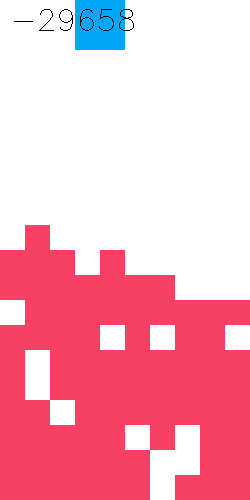

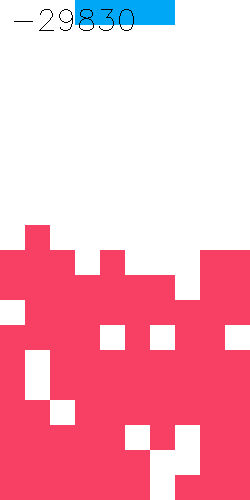

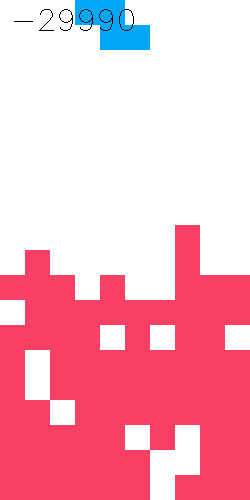

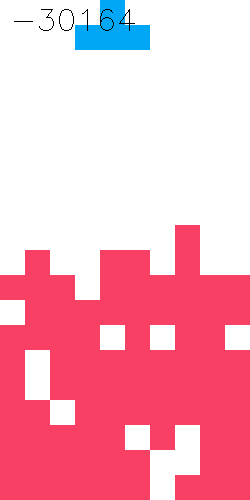

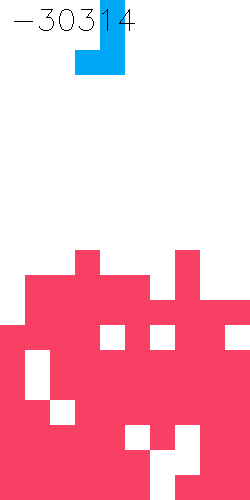

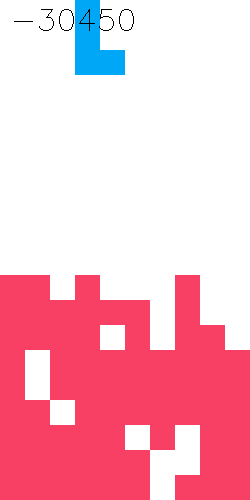

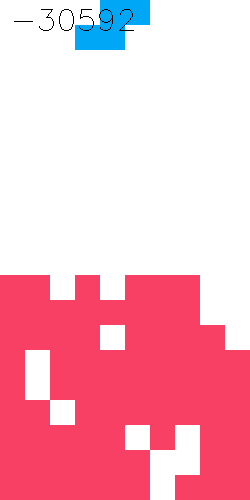

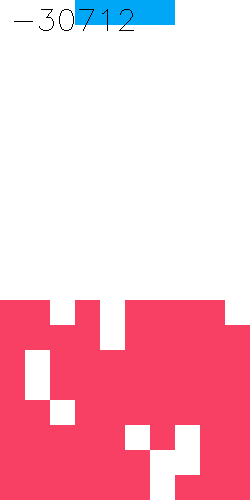

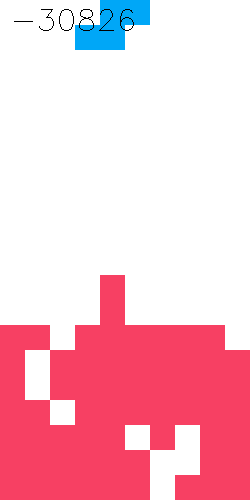

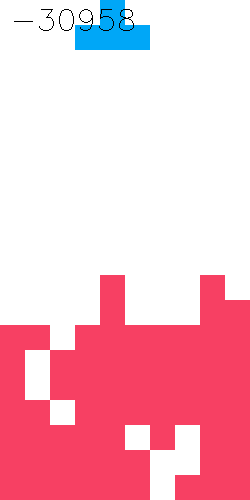

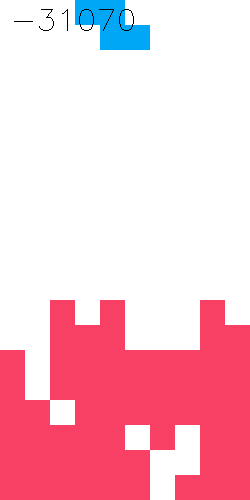

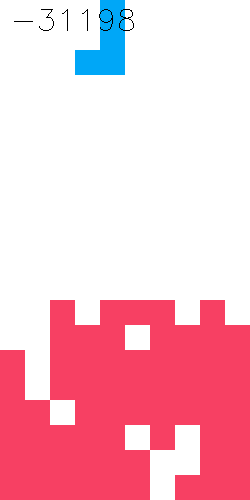

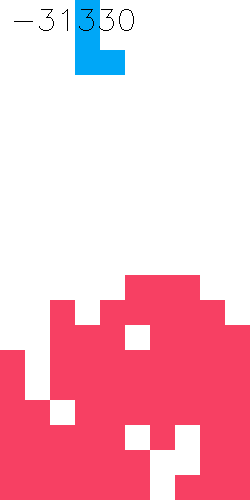

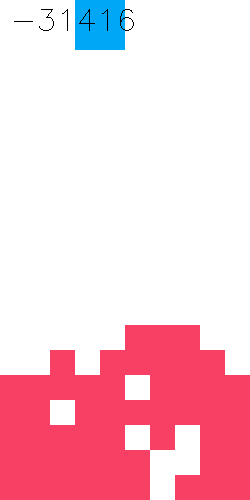

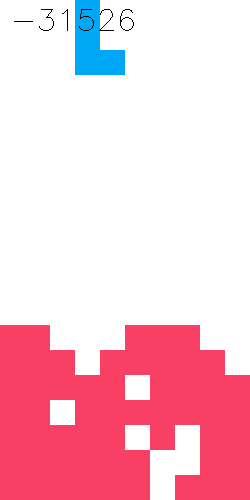

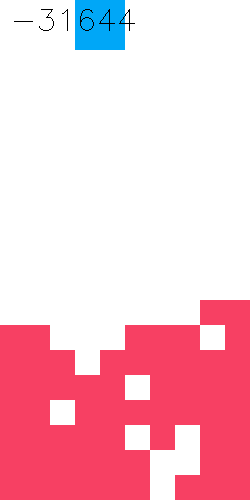

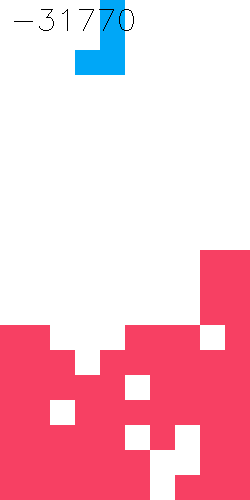

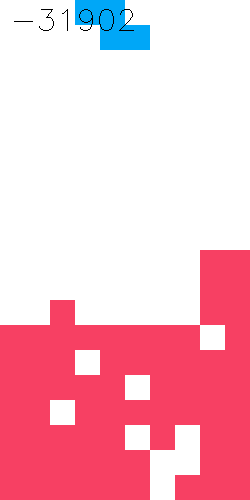

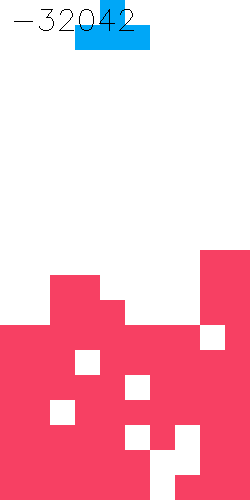

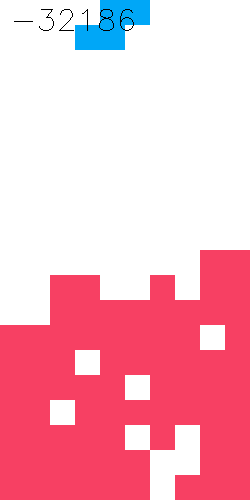

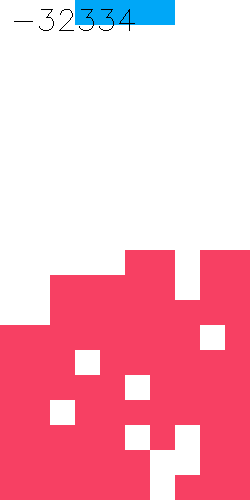

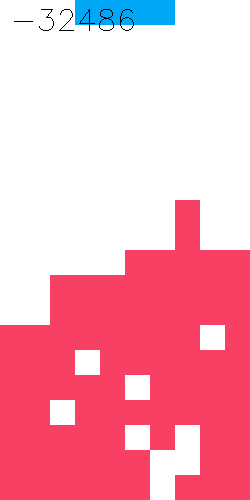

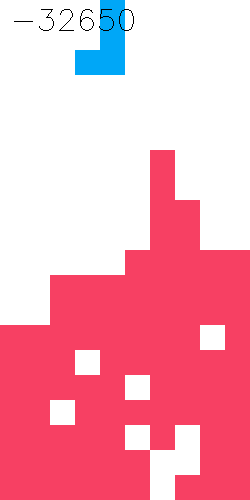

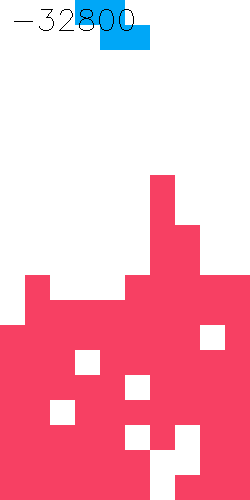

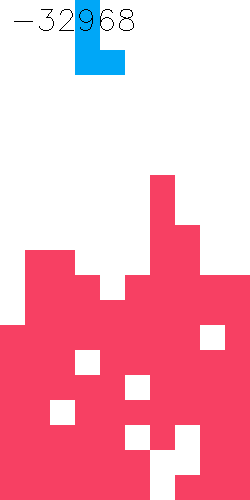

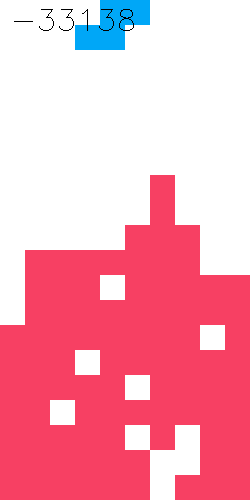

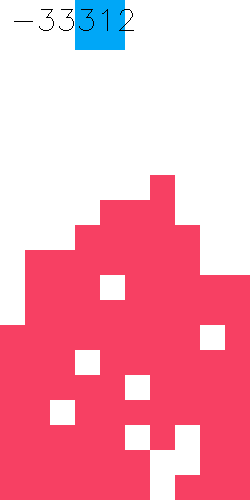

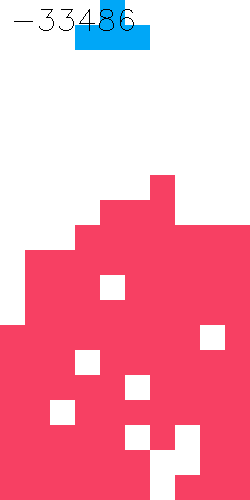

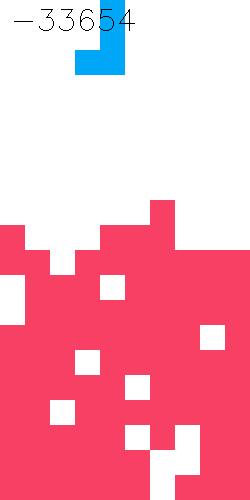

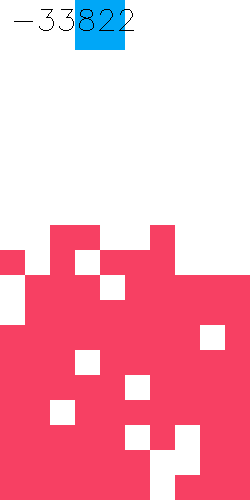

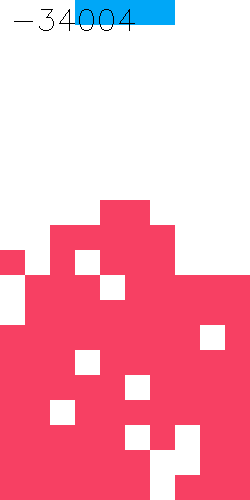

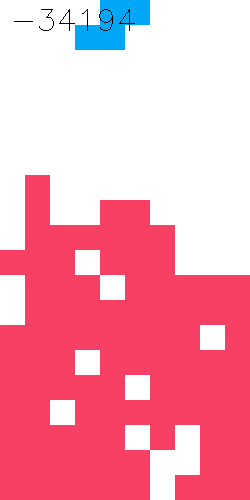

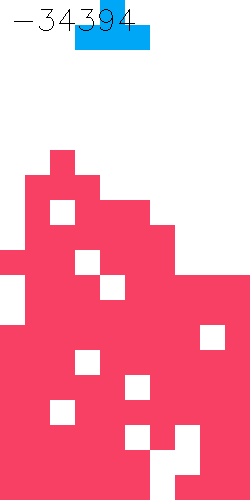

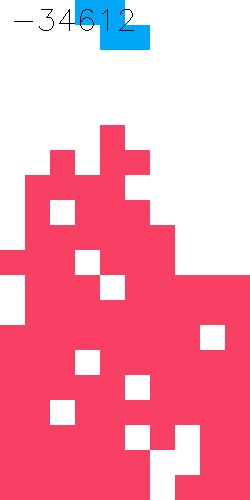

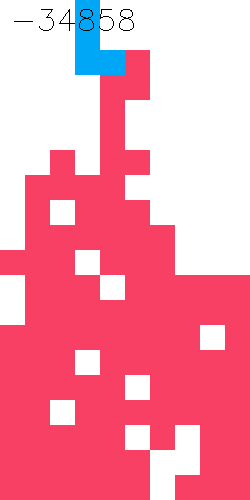

------
MEAN SCORE ::  -34958.0 MEAN LINES ::  227.0
------
MAX SCORE ::  -34958 MAX LINES ::  227
------
MIN SCORE ::  -34958 MIN LINES ::  227


In [ ]:
def render_g():
        '''Renders the current board  with google colab'''
        img = [env.COLORS[p] for row in env._get_complete_board() for p in row]
        img = np.array(img).reshape(env.BOARD_HEIGHT, env.BOARD_WIDTH, 3).astype(np.uint8)
        img = img[..., ::-1] # Convert RRG to BGR (used by cv2)
        img = Image.fromarray(img, 'RGB')
        img = np.array(img)
        img=cv2.resize(img,(env.BOARD_WIDTH *25, env.BOARD_HEIGHT * 25),interpolation = cv2.INTER_AREA)
        # img = np.array(img)
        img=cv2.putText(img, str(env.score), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 1)
        # #img2=cv2.imread('image', np.array(img))
        #cv2_imshow(img)
        # cv2.waitKey(1)
        return img
def render():
        '''Renders the current board  with google colab'''
        img = [env.COLORS[p] for row in env._get_complete_board() for p in row]
        img = np.array(img).reshape(env.BOARD_HEIGHT, env.BOARD_WIDTH, 3).astype(np.uint8)
        img = img[..., ::-1] # Convert RRG to BGR (used by cv2)
        img = Image.fromarray(img, 'RGB')
        img = np.array(img)
        img=cv2.resize(img,(env.BOARD_WIDTH *25, env.BOARD_HEIGHT * 25),interpolation = cv2.INTER_AREA)
        # img = np.array(img)
        img=cv2.putText(img, str(env.score), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 1)
        #img2=cv2.imread('image', np.array(img))
        cv2_imshow(img)
        cv2.waitKey(1)

def generate_video(frames,Root,lines):
  # create video of the game playing
  img = [] 
  fig = plt.figure()
  #plt.axis('off')
  plt.xticks([])
  plt.yticks([])

  for i in range(len(frames)):
      k=plt.imshow(frames[i],animated=True)
      img.append([k])
  print('finished')
  ani = animation.ArtistAnimation(fig, img, interval=500, blit=True,
                                  repeat_delay=1000)
  ani.save(Root+'/testing_play'+str(lines)+'cleared.mp4')
  plt.show()

agent.epsilon=0
scores_ev,wrong_action_ev,lines_cleared_ev=[],[],[]
start=0
n_games=1


for ep in range(start+1,n_games+1):
    vid=[]
    env.reset()
    if see_piece:
      current_state=env._get_complete_board()
    else:
      current_state=env.board
    done = False
    score=0
    tops=10
    lines=0
    ok=False
    what=0
    while not done:
        act=agent.choose_action(current_state)
        action=action_dictionary[act]
        reward, done,lc = env.play(action[0],action[1], render=ok,
                              render_delay=what)
        img=render_g()
        vid.append(img)
        render()
        if see_piece:
          next_state=env._get_complete_board()
        else:
          next_state=env.board

        current_state=next_state
        score+=reward

        lines+=lc

    scores_ev.append(score)
    lines_cleared_ev.append(lines)

print('------')
print('MEAN SCORE :: ',np.mean(scores_ev),'MEAN LINES :: ',np.mean(lines_cleared_ev))
print('------')
print('MAX SCORE :: ',np.max(scores_ev),'MAX LINES :: ',np.max(lines_cleared_ev))
print('------')
print('MIN SCORE :: ',np.min(scores_ev),'MIN LINES :: ',np.min(lines_cleared_ev))


In [ ]:
n_lines=lines_cleared_ev[-1]
generate_video(vid,Root,n_lines)

In [ ]:
agent.epsilon=0
scores_ev,wrong_action_ev,lines_cleared_ev=[],[],[]
start=0
n_games=1000

for ep in tqdm(range(start+1,n_games+1)):
    vid=[]
    env.reset()
    if see_piece:
      current_state=env._get_complete_board()
    else:
      current_state=env.board
    done = False
    score=0
    tops=10
    lines=0
    ok=False
    what=0
    while not done:
        act=agent.choose_action(current_state)
        action=action_dictionary[act]
        reward, done,lc = env.play(action[0],action[1], render=ok,
                              render_delay=what)
        # img=render_g()
        # vid.append(img)
        #render()
        if see_piece:
          next_state=env._get_complete_board()
        else:
          next_state=env.board

        current_state=next_state
        score+=reward
        lines+=lc
    scores_ev.append(score)
    lines_cleared_ev.append(lines)
print('------')
print('MEAN SCORE :: ',np.mean(scores_ev),'MEAN LINES :: ',np.mean(lines_cleared_ev))
print('------')
print('MAX SCORE :: ',np.max(scores_ev),'MAX LINES :: ',np.max(lines_cleared_ev))
print('------')
print('MIN SCORE :: ',np.min(scores_ev),'MIN LINES :: ',np.min(lines_cleared_ev))
#pickle.dump( lines_cleared_ev, open( Root+'/statistics/evaluation.p', "wb" ))

  0%|          | 0/1000 [00:00<?, ?it/s]

------
MEAN SCORE ::  -23924.436 MEAN LINES ::  145.118
------
MAX SCORE ::  -2100 MAX LINES ::  924
------
MIN SCORE ::  -117182 MIN LINES ::  8


In [ ]:
pickle.dump( lines_cleared_ev, open( Root+'/statistics/evaluation.p', "wb" ))

In [1]:
from plotting import plot_evaluation,refined_plot
def plot_evaluation(many,lines,filename):
  #plot function for evaluation of performance
  fig, ax1 = plt.subplots(figsize=(8,5))
  note='Mean : ' + str(np.mean(lines))+'\nMax : '+ str(np.max(lines))+'\nMin : '+str(np.min(lines))
  ax1.plot(lines)
  ax1.axhline(y=np.mean(lines),color='k', linestyle='--',label='Average Lines Cleared')
  ax1.legend(loc=5, borderaxespad=0.)
  ax1.text(3, 500, note, style='italic', fontsize=12,
         bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
  ax1.set(xlabel='Episode Number', ylabel='Lines Cleared',title='Lines Cleared in '+str(many)+' games, with cap 1000 lines')
  plt.grid()
  plt.savefig(filename)
refined_plot(steps_array, lines_c, eps_history, Root +'/good_learning_lines.png',stepping,'Lines Cleared')
plot_evaluation(1000,lines_cleared_ev,Root +'/model_'+str(f_episode)+'_evaluation2.png')